# CSEDM 2019

## Preliminaries

### Import Packages

In [19]:
import sys
sys.path.append('..')
from utilities import * 

### Constants

In [20]:
# paths
PATH_TO_INTERACTION_DATA = '../../../../../../data/ddia/CSEDM_2019_DataChallenge v1.1/MainTable.csv'

# dataset name
DATASET_NAME = 'csedm_2019'

# fields used in the analysis
USER_FIELD = 'SubjectID'
GROUP_FIELD = None
LEARNING_ACTIVITY_FIELD = 'ProblemID'
COURSE_FIELD = 'Course'
TIMESTAMP_FIELD = 'ServerTimestamp'
ORDER_FIELD = 'Order'

# fields used in dataset preparation
EVENT_TYPE_FIELD = 'EventType'

# strings and values used in dataset preparation
EVENT_TYPE_SUBMIT_VALUE_STR = 'Submit'
EVENT_TYPE_HINT_VALUE_STR = 'X-HintRequest'

# evaluation fields
# learning activity level
EVALUATION_LEARNING_ACTIVITY_SCORE_FIELD = None
EVALUATION_LEARNING_ACTIVITY_IS_CORRECT_FIELD = 'Correct'
# group level
EVALUATION_GROUP_SCORE_FIELD = None
EVALUATION_GROUP_IS_CORRECT_FIELD = None 
# course level
EVALUATION_COURSE_SCORE_FIELD = None
EVALUATION_COURSE_IS_CORRECT_FIELD = None 

# score threshold is correct
EVALUATION_LEARNING_ACTIVITY_SCORE_CORRECT_THRESHOLD = None
EVALUATION_GROUP_SCORE_CORRECT_THRESHOLD = None
EVALUATION_COURSE_SCORE_CORRECT_THRESHOLD = None

# evaluation min and max in dataset docu
EVALUATION_LEARNING_ACTIVITY_SCORE_MINIMUM_IN_DATASET_DOCU = None
EVALUATION_LEARNING_ACTIVITY_SCORE_MAXIMUM_IN_DATASET_DOCU = None
EVALUATION_GROUP_SCORE_MINIMUM_IN_DATASET_DOCU = None
EVALUATION_GROUP_SCORE_MAXIMUM_IN_DATASET_DOCU = None
EVALUATION_COURSE_SCORE_MINIMUM_IN_DATASET_DOCU = None
EVALUATION_COURSE_SCORE_MAXIMUM_IN_DATASET_DOCU = None

# used for generating html tables
HTML_TABLES_DATA_LIST = [[LEARNING_ACTIVITY_FIELD, EVALUATION_LEARNING_ACTIVITY_SCORE_FIELD, EVALUATION_LEARNING_ACTIVITY_IS_CORRECT_FIELD, EVALUATION_LEARNING_ACTIVITY_SCORE_CORRECT_THRESHOLD, EVALUATION_LEARNING_ACTIVITY_SCORE_MINIMUM_IN_DATASET_DOCU, EVALUATION_LEARNING_ACTIVITY_SCORE_MAXIMUM_IN_DATASET_DOCU], 
                         [GROUP_FIELD, EVALUATION_GROUP_SCORE_FIELD, EVALUATION_GROUP_IS_CORRECT_FIELD, EVALUATION_GROUP_SCORE_CORRECT_THRESHOLD, EVALUATION_GROUP_SCORE_MINIMUM_IN_DATASET_DOCU, EVALUATION_GROUP_SCORE_MAXIMUM_IN_DATASET_DOCU], 
                         [COURSE_FIELD, EVALUATION_COURSE_SCORE_FIELD, EVALUATION_COURSE_IS_CORRECT_FIELD, EVALUATION_COURSE_SCORE_CORRECT_THRESHOLD, EVALUATION_COURSE_SCORE_MINIMUM_IN_DATASET_DOCU, EVALUATION_COURSE_SCORE_MAXIMUM_IN_DATASET_DOCU]]

### Import Pickled Objects

In [21]:
# seq_distances = pickle_read(PATH_TO_SEQUENCE_DISTANCES_PICKLE_FOLDER,
#                             DATASET_NAME + SEQUENCE_DISTANCE_DICT_PER_GROUP_PICKLE_NAME)

# learning_activity_sequence_stats_per_group = pickle_read(PATH_TO_SEQUENCE_STATISTICS_PICKLE_FOLDER,
#                                                          DATASET_NAME + SEQUENCE_STATISTICS_TABLES_PICKLE_NAME)

# html_table = pickle_read(PATH_TO_HTML_TABLES_PICKLE_FOLDER,
#                          DATASET_NAME + HTML_TABLES_PICKLE_NAME)

# cluster_eval = pickle_read(PATH_TO_SEQUENCE_CLUSTER_EVALUATION_METRIC_ANALYSIS_PICKLE_FOLDER,
#                            DATASET_NAME + SEQUENCE_CLUSTER_EVALUATION_METRIC_ANALYSIS_PER_GROUP_OBJECT_PICKLE_NAME)

### Functions

In [22]:
def calculate_eval_metrics(df: pd.DataFrame,
                           evaluation_is_correct_field=None,
                           event_type_field=None,
                           event_type_submit_value_str=None,
                           event_type_hint_value_str=None,
                           server_timestamp_field=None):
    """Calculate evaluation metrics per single learning_activity. This function should be used as input of the
    add_evaluation_fields function.

    Parameters
    ----------
    df : pd.DataFrame
        A subset of the interactions dataframe containing data of a single learning_activity
    evaluation_is_correct_field : _type_
        The learning_activity evaluation is_correct field column, by default None
    event_type_field : _type_
        The event_type field column, by default None
    event_type_submit_value_str : _type_
        The submit value of the event_type field, by default None
    event_type_hint_value_str : _type_
        The hint value of the event type field, by default None

    Returns
    -------
    tuple
        A tuple of evaluation metric scalars per learning activity
    """
    # number interactions (submit and hint request)
    number_interactions_total = df.shape[0]

    # number attempts
    number_attempts_total = sum(df[event_type_field]==event_type_submit_value_str)

    # number hints
    number_hints_total = sum(df[event_type_field]==event_type_hint_value_str)

    # total time
    # (timedelta between first and last run_program interaction, can be 0 for only 1 interaction)
    time_total = round((df[server_timestamp_field].iloc[-1] - df[server_timestamp_field].iloc[0]).total_seconds())

    # scores
    # single score
    single_score = None
    # single score hint lowest 
    single_score_hint_lowest = None 
    # single score not first attempt lowest
    single_score_not_first_attempt_lowest = None
    # highest score
    score_highest = None
    # highest score without hint
    score_highest_without_hint = None
    # score first attempt
    score_first_attempt = None
    # score last attempt
    score_last_attempt = None
    # number interactions until highest score
    number_interactions_until_score_highest = None
    # number attempts until highest score
    number_attempts_until_score_highest = None
    # number hints until highest score
    number_hints_until_score_highest = None
    # time until highest score
    time_until_score_highest = None

    # corrects
    # correct
    is_correct = df[evaluation_is_correct_field].any()
    # correct without hint
    if is_correct: 
        index_correct = np.argmax(df[evaluation_is_correct_field])
        is_correct_without_hint = event_type_hint_value_str not in df[event_type_field][:index_correct + 1].to_list() 
    else:
        is_correct_without_hint = False 
    # correct first attempt
    try:
        is_correct_first_attempt = df[evaluation_is_correct_field][df[event_type_field]==event_type_submit_value_str].to_list()[0]
    except:
        is_correct_first_attempt = False
    # correct first attempt without hint
    is_correct_first_attempt_without_hint = df[evaluation_is_correct_field].to_list()[0]
    # correct last attempt
    try:
        is_correct_last_attempt = df[evaluation_is_correct_field][df[event_type_field]==event_type_submit_value_str].to_list()[-1]
    except:
        is_correct_last_attempt = False
    # correct last attempt without hint
    if is_correct_last_attempt:
        index_correct_last_attempt_without_hint = df[event_type_field][df[event_type_field]==event_type_submit_value_str].tail(1).index.values[0]
        is_correct_last_attempt_without_hint = event_type_hint_value_str not in df[event_type_field][:index_correct_last_attempt_without_hint].to_list()
    else:
        is_correct_last_attempt_without_hint = False
    # number interactions until correct
    if is_correct:
        number_interactions_until_correct = np.argmax(df[evaluation_is_correct_field]) + 1
    else:
        number_interactions_until_correct = -1 # -1 means that there was no correct -> therefore also no interactions until correct
    # number attempts until correct
    if is_correct:
        number_attempts_until_correct = np.argmax(df[evaluation_is_correct_field][df[event_type_field]==event_type_submit_value_str]) + 1
    else:
        number_attempts_until_correct = -1 # -1 means that there was no correct -> therefore also no attempts until correct
    # number hints until correct
    if is_correct:
        index_first_correct = np.argmax(df[evaluation_is_correct_field])
        number_hints_until_correct = sum(df[event_type_field][:index_first_correct].isin([event_type_hint_value_str]))
    else:
        number_hints_until_correct = -1 # -1 means that there was no correct -> therefore also no hints until correct
    # time until correct
    # (timedelta between first run_program interaction and first is_correct run_program interaction, can be 0 for only 1 interaction)
    if is_correct:
        index_is_correct = np.argmax(df[evaluation_is_correct_field])
        time_until_correct = round((df[server_timestamp_field].iloc[index_is_correct] - df[server_timestamp_field].iloc[0]).total_seconds())
    else:
        time_until_correct = -1 # -1 means that there was no correct -> therefore also no attempts until correct
    
    return (number_interactions_total,
            number_attempts_total,
            number_hints_total,
            time_total,
            single_score,
            single_score_hint_lowest,
            single_score_not_first_attempt_lowest,
            score_highest,
            score_highest_without_hint,
            score_first_attempt,
            score_last_attempt,
            number_interactions_until_score_highest,
            number_attempts_until_score_highest,
            number_hints_until_score_highest,
            time_until_score_highest,
            is_correct,
            is_correct_without_hint,
            is_correct_first_attempt,
            is_correct_first_attempt_without_hint,
            is_correct_last_attempt,
            is_correct_last_attempt_without_hint,
            number_interactions_until_correct,
            number_attempts_until_correct,
            number_hints_until_correct,
            time_until_correct)

## Dataset Preparation

### Import Data

In [23]:
interactions = pd.read_csv(PATH_TO_INTERACTION_DATA)

### Set Data Type

In [24]:
interactions = typecast_fields(interactions,
                               TIMESTAMP_FIELD,
                               GROUP_FIELD,
                               USER_FIELD,
                               LEARNING_ACTIVITY_FIELD)

### Merge and Filter Data

### Transform Categorical Variable Values

In [25]:
interactions, value_mapping_df = map_new_to_old_values(interactions, 
                                                       GROUP_FIELD, 
                                                       USER_FIELD, 
                                                       LEARNING_ACTIVITY_FIELD)

### Filter Sequences by NAs in Dataset 

In [26]:
pct_na = get_nas_in_data(interactions)

EventType                         0.0 %
EventID                           0.0 %
Order                             0.0 %
SubjectID                         0.0 %
ToolInstances                     0.0 %
CodeStateID                       0.0 %
ServerTimestamp                   0.0 %
ProblemID                         0.0 %
Correct            1.0617760617760617 %
dtype: object


In [27]:
interactions, na_indices_list = drop_learning_activity_sequence_if_contains_na_in_field(interactions, 
                                                                                        GROUP_FIELD, 
                                                                                        USER_FIELD, 
                                                                                        field_list=[LEARNING_ACTIVITY_FIELD, 
                                                                                                    TIMESTAMP_FIELD, 
                                                                                                    ORDER_FIELD, 
                                                                                                    EVALUATION_LEARNING_ACTIVITY_IS_CORRECT_FIELD], 
                                                                                        field_value_tuple_filter_list=[])



Input length: 3108
Outpunt length: 2390
Number of rows removed: 718
Percentage of rows removed: 23.1017%
--------------------------------------------------
Input number of sequences: 89
Output number of sequences: 83
Number of sequences removed: 6
Percentage of sequences removed: 6.7416%


In [28]:
interactions = drop_na_by_fields(interactions,
                                 field_list=[USER_FIELD])

Input length: 2390
Outpunt length: 2390
Number of rows removed: 0
Percentage of rows removed: 0%


In [29]:
pct_na = get_nas_in_data(interactions)

EventType          0.0 %
EventID            0.0 %
Order              0.0 %
SubjectID          0.0 %
ToolInstances      0.0 %
CodeStateID        0.0 %
ServerTimestamp    0.0 %
ProblemID          0.0 %
Correct            0.0 %
dtype: object


### Sort by Timestamp

In [12]:
interactions = sort_by_timestamp(interactions, 
                                 ORDER_FIELD, 
                                 higher_level_sort_list=[USER_FIELD, TIMESTAMP_FIELD])

### Evaluation Score Fields Ranges

In [13]:
evaluation_score_range_dict = return_and_plot_evaluation_score_range(interactions,
                                                                     LEARNING_ACTIVITY_FIELD,
                                                                     EVALUATION_LEARNING_ACTIVITY_SCORE_FIELD,
                                                                     GROUP_FIELD,
                                                                     EVALUATION_GROUP_SCORE_FIELD,
                                                                     EVALUATION_COURSE_SCORE_FIELD)

### Transform Data

#### Add Evaluation Fields

In [14]:
interactions = add_evaluation_fields(interactions,
                                     GROUP_FIELD,
                                     USER_FIELD,
                                     LEARNING_ACTIVITY_FIELD,
                                     TIMESTAMP_FIELD,
                                     ORDER_FIELD,
                                     np.mean,
                                     EVALUATION_GROUP_SCORE_FIELD,
                                     EVALUATION_GROUP_IS_CORRECT_FIELD,
                                     EVALUATION_COURSE_SCORE_FIELD,
                                     EVALUATION_COURSE_IS_CORRECT_FIELD,
                                     False,
                                     False,
                                     EVALUATION_GROUP_SCORE_CORRECT_THRESHOLD,
                                     EVALUATION_COURSE_SCORE_CORRECT_THRESHOLD,
                                     operator.gt,
                                     operator.gt,
                                     calculate_eval_metrics,
                                     evaluation_is_correct_field=EVALUATION_LEARNING_ACTIVITY_IS_CORRECT_FIELD,
                                     event_type_field=EVENT_TYPE_FIELD,
                                     event_type_submit_value_str=EVENT_TYPE_SUBMIT_VALUE_STR,
                                     event_type_hint_value_str=EVENT_TYPE_HINT_VALUE_STR,
                                     server_timestamp_field=TIMESTAMP_FIELD)

100%|██████████| 83/83 [00:00<00:00, 17514.07it/s]

= Repeated Consecutive Learning Activity Removal =
Initial number of rows: 2390
Final number of rows: 794
Removed number of rows: 1596
Removed percentage of rows: 66.77824267782427%


### Rename Fields

In [15]:
interactions, fields_mapping_df = rename_fields(interactions,
                                                GROUP_FIELD,
                                                USER_FIELD,
                                                LEARNING_ACTIVITY_FIELD,
                                                TIMESTAMP_FIELD)

### Add Sequence ID Field

In [16]:
interactions = add_sequence_id_field(interactions,
                                     GROUP_FIELD)

### Check Dataset

In [17]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794 entries, 0 to 793
Data columns (total 86 columns):
 #   Column                                                                                   Non-Null Count  Dtype         
---  ------                                                                                   --------------  -----         
 0   Timestamp                                                                                794 non-null    datetime64[ns]
 1   User                                                                                     794 non-null    object        
 2   Topic                                                                                    0 non-null      float64       
 3   Learning Resource                                                                        794 non-null    object        
 4   Sequence ID                                                                              794 non-null    object        
 5   Learning Resour

In [18]:
pct_na = get_nas_in_data(interactions)
pct_na

Timestamp                                                                                    0.0 %
User                                                                                         0.0 %
Topic                                                                                      100.0 %
Learning Resource                                                                            0.0 %
Sequence ID                                                                                  0.0 %
Learning Resource Interactions Total                                                         0.0 %
Learning Resource Attempts Total                                                             0.0 %
Learning Resource Hints Total                                                                0.0 %
Learning Resource Time in Seconds Total                                                      0.0 %
Learning Resource Single Score                                                             100.0 %
Learning R

### Create HtmlTables Dataset Info Object

In [19]:
html_table = HtmlTables(DATASET_NAME,
                        interactions, 
                        evaluation_score_range_dict, 
                        HTML_TABLES_DATA_LIST)

### Save the Dataset, Mapping Information and HtmlTables Object 

In [20]:
save_interaction_and_mapping_df(interactions,
                                fields_mapping_df,
                                value_mapping_df,
                                PATH_TO_CLEANED_DATASETS,
                                DATASET_NAME)

In [21]:
pickle_write(html_table,
             PATH_TO_HTML_TABLES_PICKLE_FOLDER,
             DATASET_NAME + HTML_TABLES_PICKLE_NAME)

## Dataset Characteristics

### Dataset Information

---
**Has GROUPING Field:** False

---
**Available Evaluation Metrics**  
Possible Values: 
>- True 
>- False
>- Derived (For 'Is Correct' fields)

Score Threshold to be correct:   
>    Learning Activity Is Correct Threshold:  
>    Group Is Correct Threshold:  
>    Course Is Correct Threshold:  

>**I. Learning Activity Level**:

- **Number of Interactions Total:** True

- **Number of Attempts Total:** True

- **Number of Hints Total:** True

- **Score Highest:** False

- **Score Highest without Hint:** False

- **Score First Attempt:** False

- **Score Last Attempt:** False

- **Number of Interactions until Highest Score:** False

- **Number of Attempts until Highest Score:** False

- **Number of Hints until Highest Score:** False

- **Is Correct:** True
        
- **Is Correct without Hint:** True

- **Is Correct at First Attempt:** True

- **Is Correct at First Attempt without Hint:** True
        
- **Is Correct at Last Attempt :** True

- **Is Correct at Last Attempt without Hint:** True

- **Number of Interactions until Correct:** True

- **Number of Attempts until Correct:** True

- **Number of Hints until Correct:** True


>**II. Group level**:

- **Group Score:** False

- **Group Is Correct:** False


>**III. Course level**:

- **Course Score:** False  

- **Course Is Correct:** False

---
**Additional Information:**

- The CSEDM 2019 dataset has very few users, which makes sequence clustering and subsequent ANOVA problematic
- Field values of Time in Seconds Total, Time in Seconds until Correct can be 0 if there is only one interaction(Submit, or Hint-Request interactions) at learning activity or if the interactions where made in the same minute(there is no exact logging of seconds)
- Field values of Time in Seconds Total, Time in Seconds until Correct can be very large due to users continuously attempting to solve learning activity over large time periods(i.e., days)

### Available Fields

In [22]:
html_table.display_available_fields()

<table border="1" class="dataframe">
  <thead>
    <tr>
      <th style = "background-color: royalblue; color: white; text-align:center"> </th>
      <th style = "background-color: royalblue; color: white; text-align:center">Is Available</th>
    </tr>
    <tr>
      <th style = "background-color: royalblue; color: white; text-align:center">Field</th>
      <th style = "background-color: royalblue; color: white; text-align:center">csedm_2019</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Timestamp</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">User</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Sequence ID</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Interactions Total</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Attempts Total</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Hints Total</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Time in Seconds Total</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Single Score</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Single Score (Hint Taken Equals Lowest Score)</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Single Score (Not First Attempt Equals Lowest Score)</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Highest Score</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Highest Score Without Hint</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource First Attempt Score</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Last Attempt Score</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Interactions Until Highest Score</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Attempts Until Highest Score</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Hints Until Highest Score</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Time in Seconds Until Highest Score</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Is Correct</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Is Correct Without Hints</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource First Attempt Is Correct</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource First Attempt Is Correct Without Hints</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Last Attempt Is Correct</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Last Attempt Is Correct Without Hints</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Interactions Until Correct</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Attempts Until Correct</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Hints Until Correct</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Learning Resource Time in Seconds Until Correct</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Score</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Is Correct</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Interactions Total All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Attempts Total All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Hints Total All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Time in Seconds Total All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Single Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Single Score (Hint Taken Equals Lowest Score) All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Single Score (Not First Attempt Equals Lowest Score) All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Highest Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Highest Score Without Hint All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic First Attempt Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Last Attempt Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Interactions Until Highest Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Attempts Until Highest Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Hints Until Highest Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Time in Seconds Until Highest Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Is Correct All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Is Correct Without Hints All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic First Attempt Is Correct All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic First Attempt Is Correct Without Hints All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Last Attempt Is Correct All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Last Attempt Is Correct Without Hints All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Interactions Until Correct All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Attempts Until Correct All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Hints Until Correct All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Topic Time in Seconds Until Correct All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Score</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Is Correct</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Interactions Total All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Attempts Total All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Hints Total All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Time in Seconds Total All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Single Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Single Score (Hint Taken Equals Lowest Score) All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Single Score (Not First Attempt Equals Lowest Score) All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Highest Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Highest Score Without Hint All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course First Attempt Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Last Attempt Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Interactions Until Highest Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Attempts Until Highest Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Hints Until Highest Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Time in Seconds Until Highest Score All Learning Resources Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Is Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Is Correct Without Hints All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course First Attempt Is Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course First Attempt Is Correct Without Hints All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Last Attempt Is Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Last Attempt Is Correct Without Hints All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Interactions Until Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Attempts Until Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Hints Until Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Time in Seconds Until Correct All Learning Resources Mean</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Score All Topics Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
    <tr>
      <td style = "background-color: rgb(80, 80, 80); color: white">Course Is Correct All Topics Mean</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
    </tr>
  </tbody>
</table>

### Score - Is_Correct Relationship

In [23]:
html_table.display_score_is_correct_relationship()

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th style = "background-color: royalblue; color: white; text-align:center"></th>
      <th style = "background-color: royalblue; color: white; text-align:center"></th>
      <th style = "background-color: royalblue; color: white; text-align:center">Has Field</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Has Score Field</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Has Is_Correct Field</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Chosen Score Is_Correct Threshold</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Score Minimum In Documentation</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Score Maximum In Documentation</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Score Minimum in Data Identical Over Evaluation Elements</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Score Maximum in Data Identical Over Evaluation Elements</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Score Minimum in Data</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Score Maximum in Data</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="3" valign="top" style = "background-color: rgb(80, 80, 80); color: white">csedm_2019</th>
      <th style = "background-color: rgb(80, 80, 80); color: white; text-align:center">Learning Resource</th>
      <td style = "background-color: green; color: white; text-align:center">True</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
      <td style = "background-color: green; color: white; text-align:center">True</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
    </tr>
    <tr>
      <th style = "background-color: rgb(80, 80, 80); color: white; text-align:center">Topic</th>
      <td style = "background-color: red; color: white; text-align:center">False</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
    </tr>
    <tr>
      <th style = "background-color: rgb(80, 80, 80); color: white; text-align:center">Course</th>
      <td style = "background-color: green; color: white; text-align:center">True</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
      <td style = "background-color: red; color: white; text-align:center">False</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
      <td style = "text-align:center">-</td>
    </tr>
  </tbody>
</table>

### Summary Statistics

In [24]:
html_table.display_summary_statistics()

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th style = "background-color: royalblue; color: white; text-align:center"></th>
      <th style = "background-color: royalblue; color: white; text-align:center"># of Rows</th>
      <th style = "background-color: royalblue; color: white; text-align:center"># of Unique Users</th>
      <th style = "background-color: royalblue; color: white; text-align:center"># of Unique Topics</th>
      <th style = "background-color: royalblue; color: white; text-align:center"># of Unique Learning Resources</th>
      <th style = "background-color: royalblue; color: white; text-align:center"># of Sequences</th>
      <th style = "background-color: royalblue; color: white; text-align:center"># of Unique Sequences</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Sparsity User-Learning Resource Matrix %</th>
      <th style = "background-color: royalblue; color: white; text-align:center">Sparsity User-Topic Matrix %</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th style = "background-color: rgb(80, 80, 80); color: white; text-align:center">csedm_2019</th>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">794</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">83</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">-</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">35</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">83</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">66</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">73.94</td>
      <td style = "background-color: rgb(0, 0, 204); color: white; text-align:center">-</td>
    </tr>
  </tbody>
</table>

### Group-User-Learning_Activity Relationship

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Learning Resources per User:
----------------------------------------------------------------------------------------------------
mean: number of Learning Resources per User: 9.566265060240964
median: number of Learning Resources per User: 8.0
max: number of Learning Resources per User: 33
min: number of Learning Resources per User: 1
std: number of Learning Resources per User: 8.697059737361112
iqr: number of Learning Resources per User: 12.0


Plots:


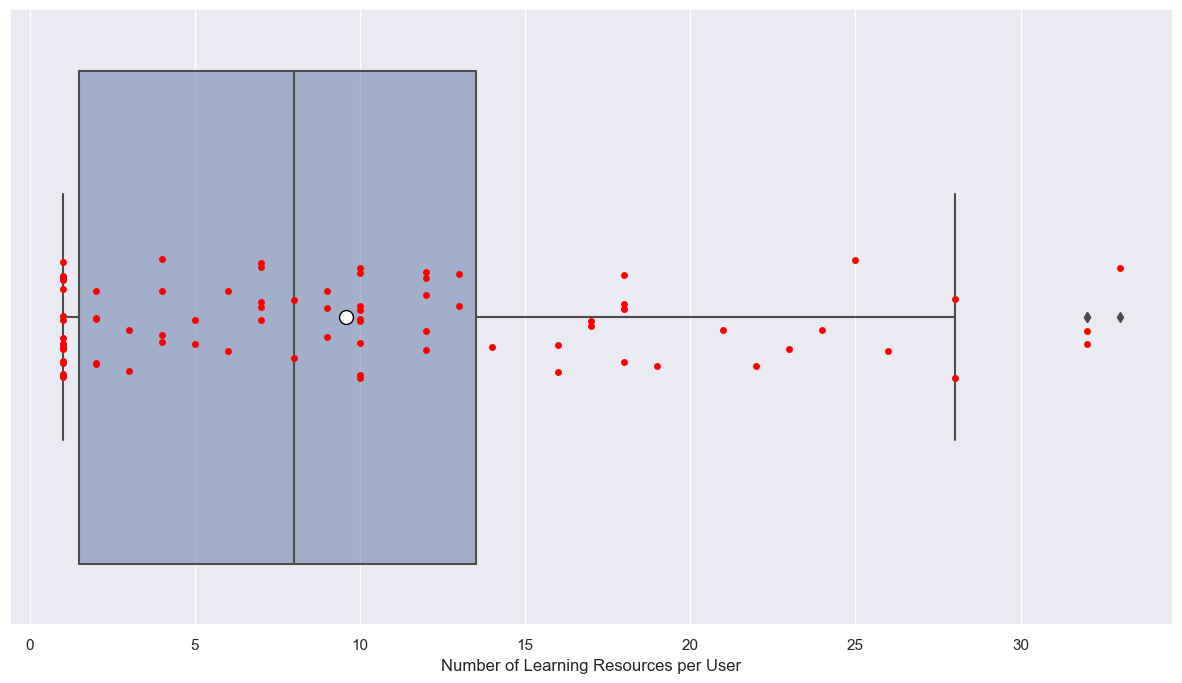

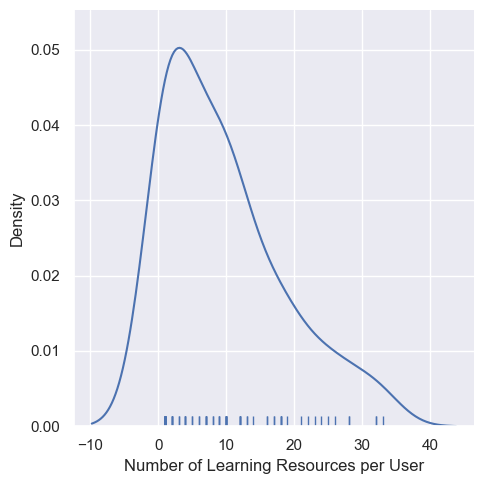

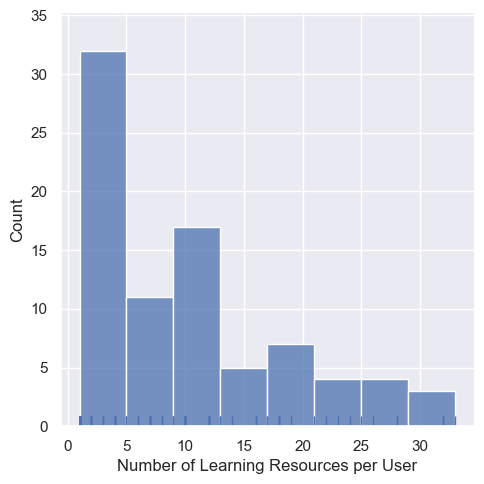

****************************************************************************************************
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Number of Unique Topics per User:
----------------------------------------------------------------------------------------------------
mean: Number of Unique Topics per User: 1.0
median: Number of Unique Topics per User: 1.0
max: Number of Unique Topics per User: 1
min: Number of Unique Topics per User: 1
std: Number of Unique Topics per User: 0.0
iqr: Number of Unique Topics per User: 0.0


Plots:


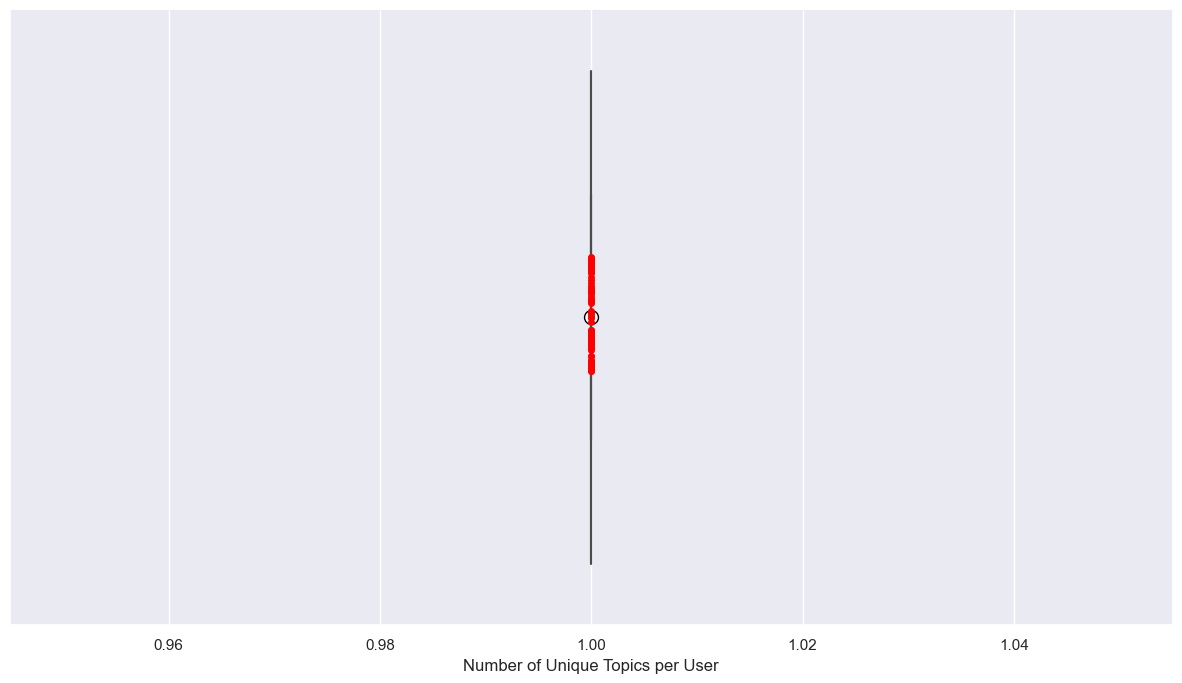

/Users/stefanschmerda/stefan/code/repos/know_center/ddia_dataset_analysis/dataset_analysis/notebooks/../utilities/functions.py:1188: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=data,


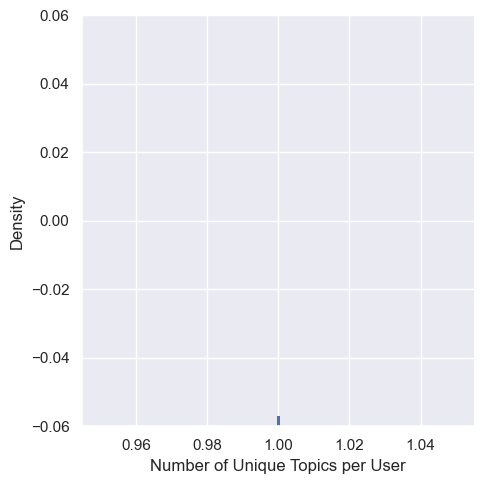

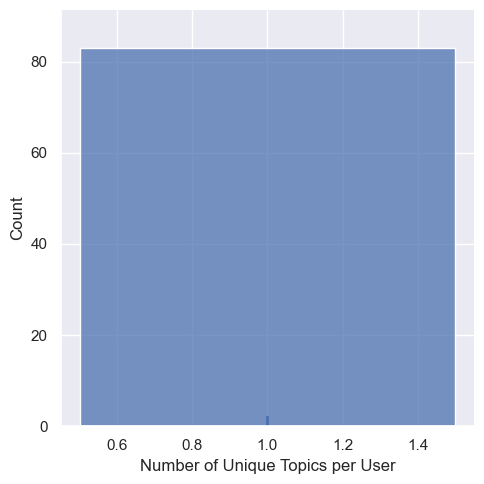

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Unique Learning Resources per User:
----------------------------------------------------------------------------------------------------
mean: Number of Unique Learning Resources per User: 9.120481927710843
median: Number of Unique Learning Resources per User: 7.0
max: Number of Unique Learning Resources per User: 30
min: Number of Unique Learning Resources per User: 1
std: Number of Unique Learning Resources per User: 8.245320314092506
iqr: Number of Unique Learning Resources per User: 11.5


Plots:


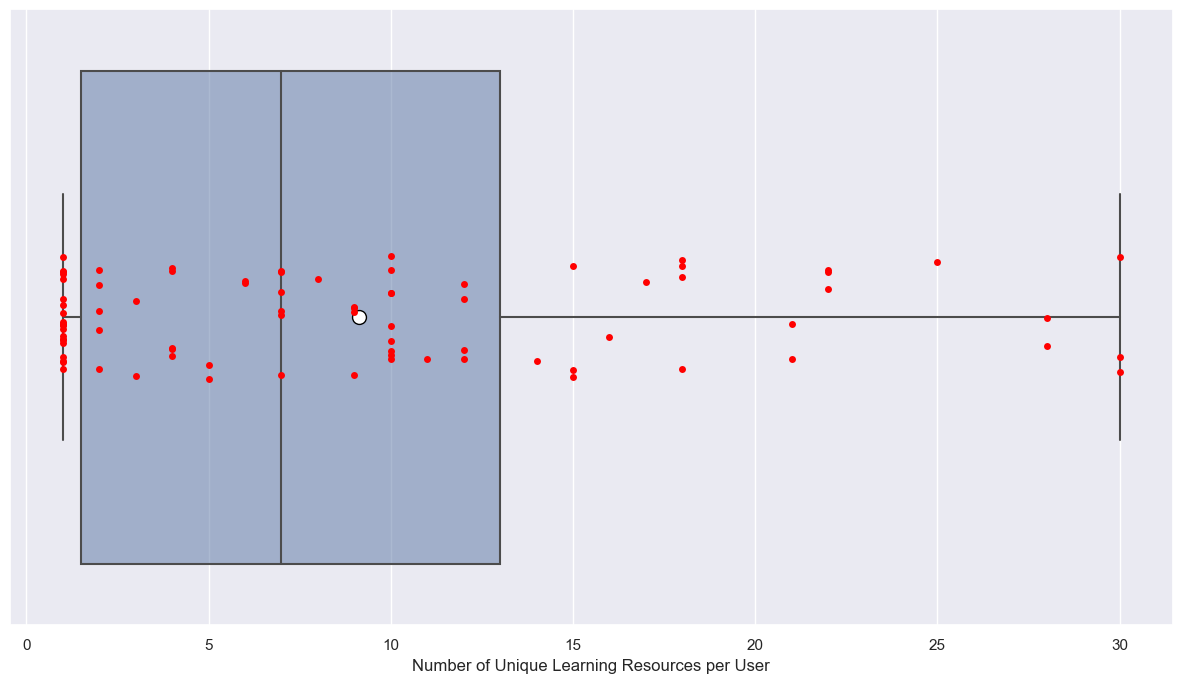

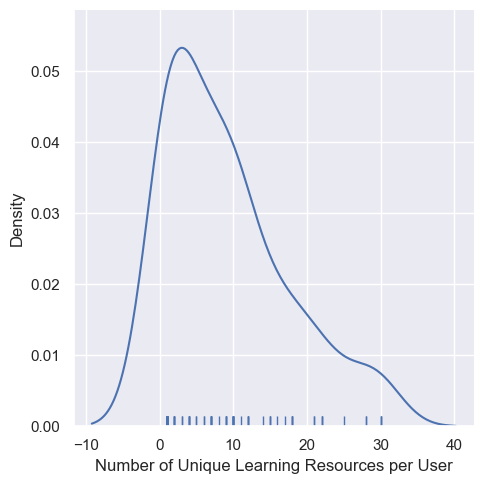

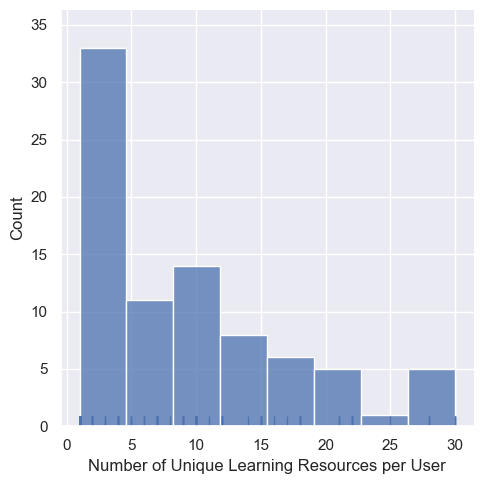

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Unique Users per Topic:
----------------------------------------------------------------------------------------------------
mean: Number of Unique Users per Topic: 83.0
median: Number of Unique Users per Topic: 83.0
max: Number of Unique Users per Topic: 83
min: Number of Unique Users per Topic: 83
std: Number of Unique Users per Topic: nan
iqr: Number of Unique Users per Topic: 0.0


Plots:


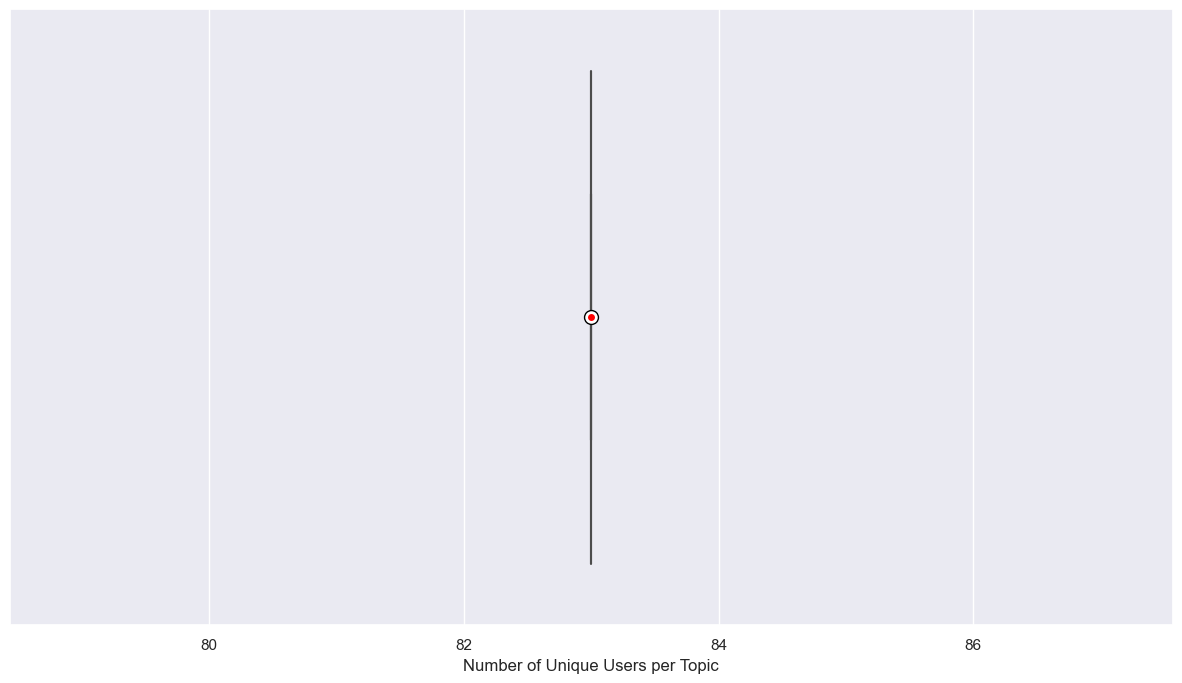

/Users/stefanschmerda/stefan/code/repos/know_center/ddia_dataset_analysis/dataset_analysis/notebooks/../utilities/functions.py:1188: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=data,


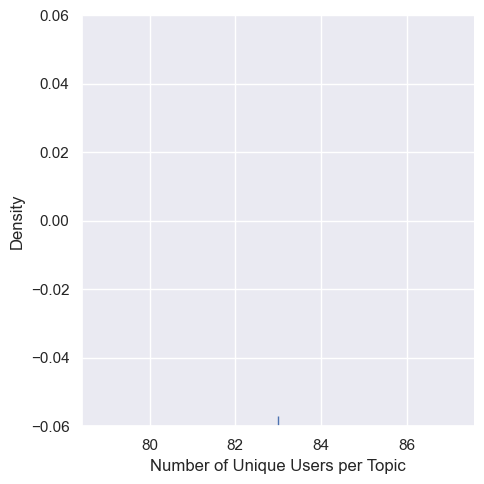

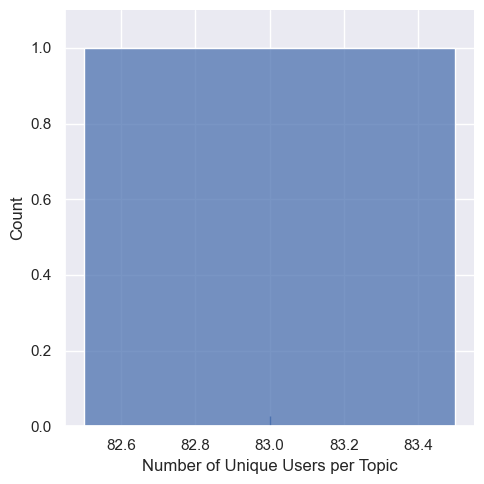

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Unique Learning Resources per Topic:
----------------------------------------------------------------------------------------------------
mean: Number of Unique Learning Resources per Topic: 35.0
median: Number of Unique Learning Resources per Topic: 35.0
max: Number of Unique Learning Resources per Topic: 35
min: Number of Unique Learning Resources per Topic: 35
std: Number of Unique Learning Resources per Topic: nan
iqr: Number of Unique Learning Resources per Topic: 0.0


Plots:


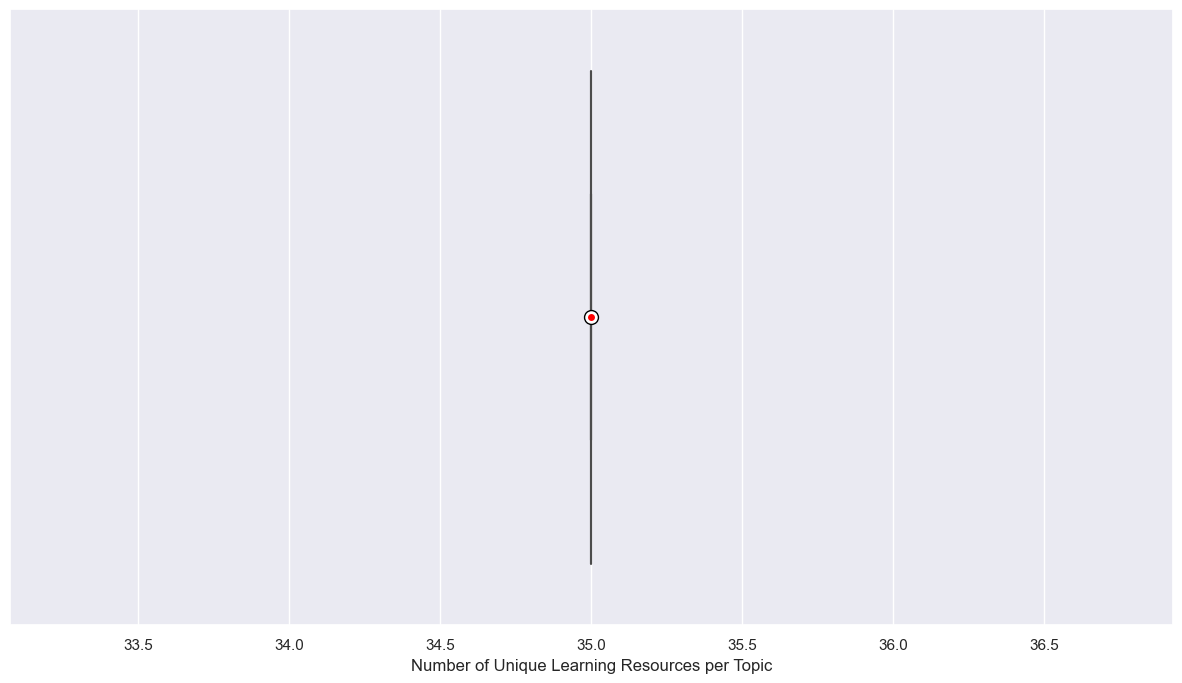

/Users/stefanschmerda/stefan/code/repos/know_center/ddia_dataset_analysis/dataset_analysis/notebooks/../utilities/functions.py:1188: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=data,


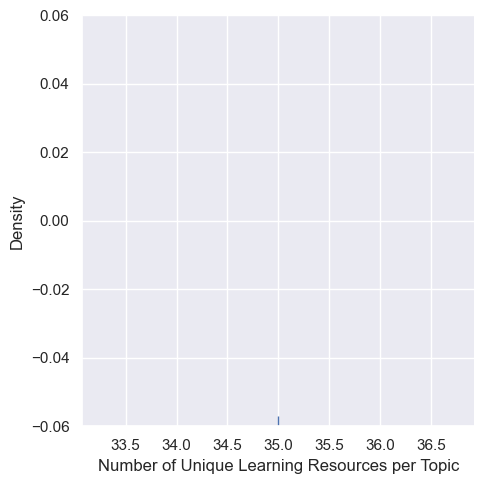

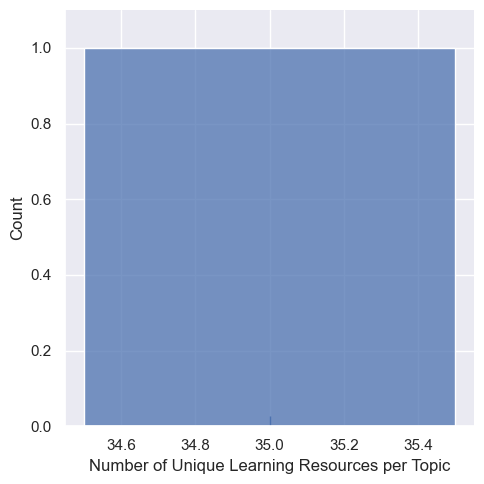

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Unique Users per Learning Resource:
----------------------------------------------------------------------------------------------------
mean: Number of Unique Users per Learning Resource: 21.62857142857143
median: Number of Unique Users per Learning Resource: 18.0
max: Number of Unique Users per Learning Resource: 68
min: Number of Unique Users per Learning Resource: 1
std: Number of Unique Users per Learning Resource: 17.814544147782097
iqr: Number of Unique Users per Learning Resource: 22.0


Plots:


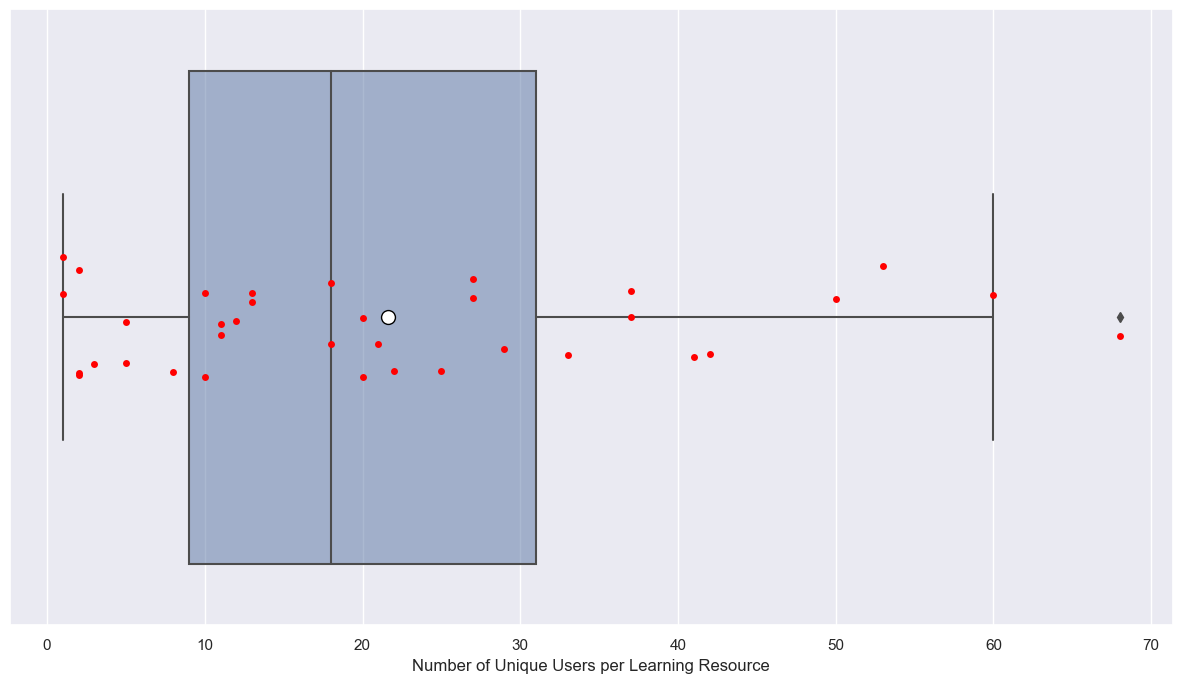

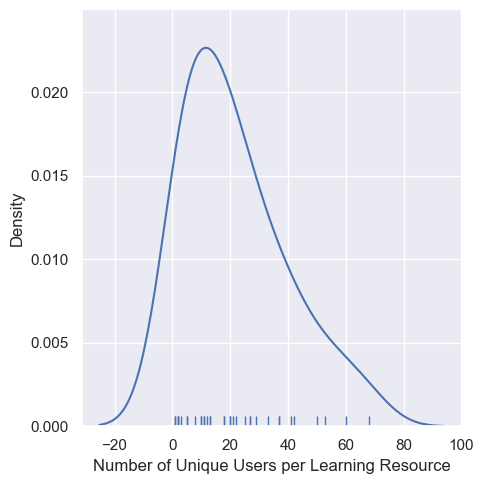

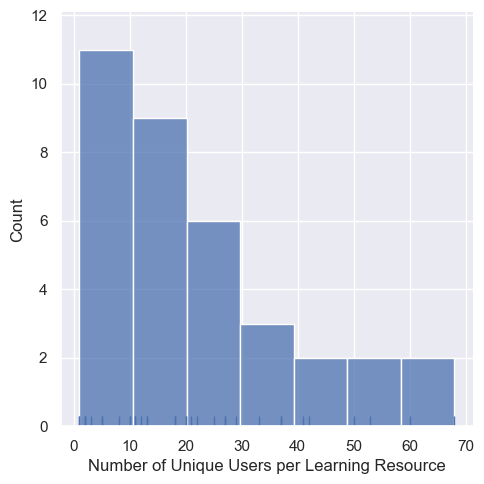

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Unique Topics per Learning Resource:
----------------------------------------------------------------------------------------------------
mean: Number of Unique Topics per Learning Resource: 1.0
median: Number of Unique Topics per Learning Resource: 1.0
max: Number of Unique Topics per Learning Resource: 1
min: Number of Unique Topics per Learning Resource: 1
std: Number of Unique Topics per Learning Resource: 0.0
iqr: Number of Unique Topics per Learning Resource: 0.0


Plots:


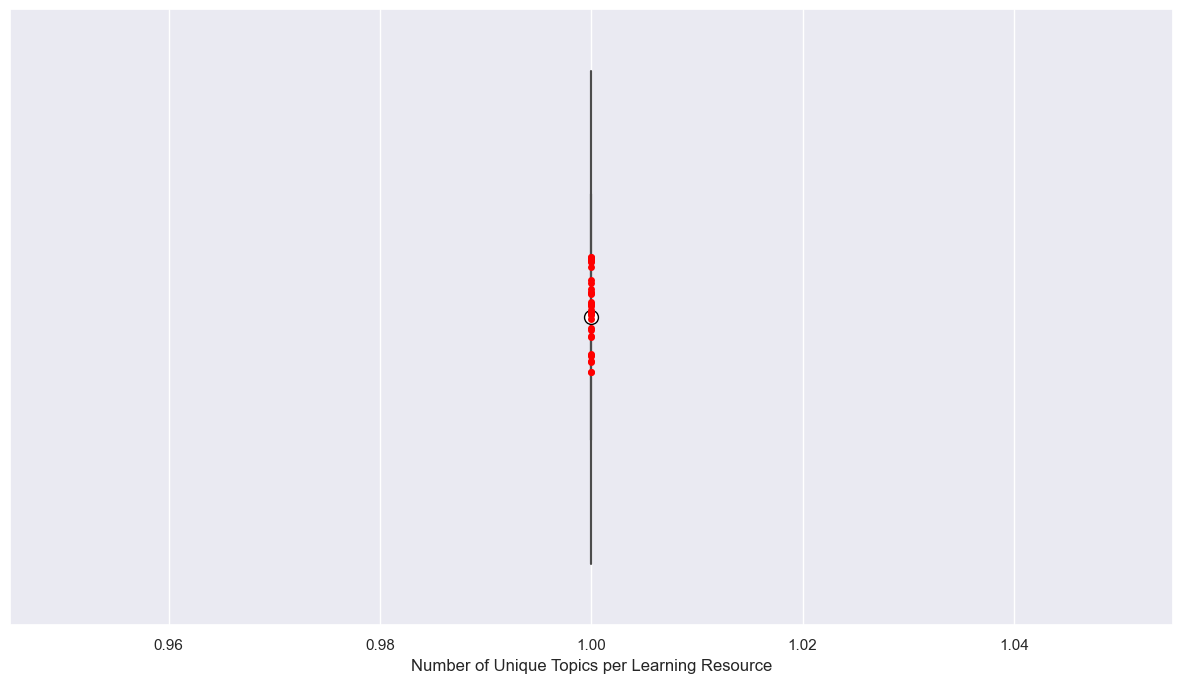

/Users/stefanschmerda/stefan/code/repos/know_center/ddia_dataset_analysis/dataset_analysis/notebooks/../utilities/functions.py:1188: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=data,


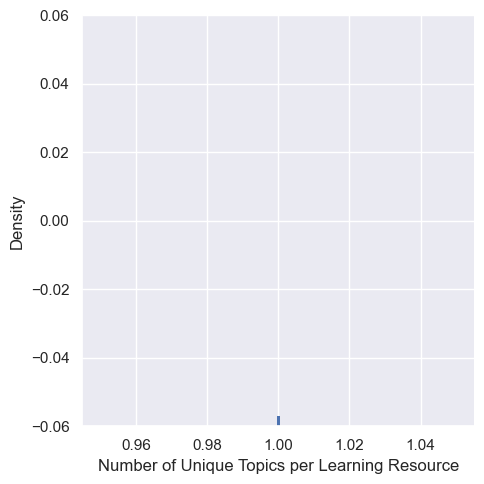

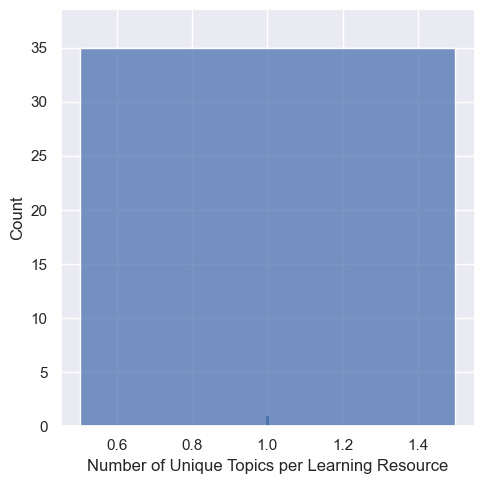

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Mean/Median Number of Interactions per Topic for a User:
----------------------------------------------------------------------------------------------------
mean of Mean Number of Interactions per Topic for a User: 9.566265060240964
median of Mean Number of Interactions per Topic for a User: 8.0
max of Mean Number of Interactions per Topic for a User: 33.0
min of Mean Number of Interactions per Topic for a User: 1.0
std of Mean Number of Interactions per Topic for a User: 8.697059737361107
iqr of Mean Number of Interactions per Topic for a User: 12.0

____________________________________________________________________________________________________

mean of Median Number of Interacti

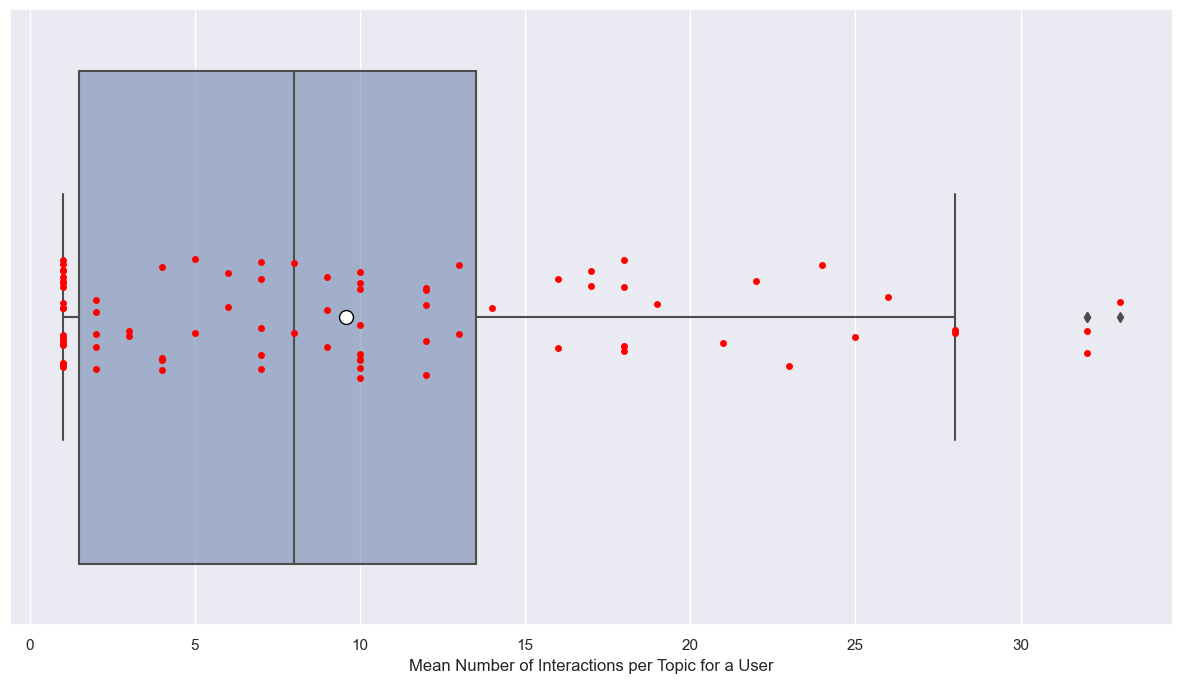

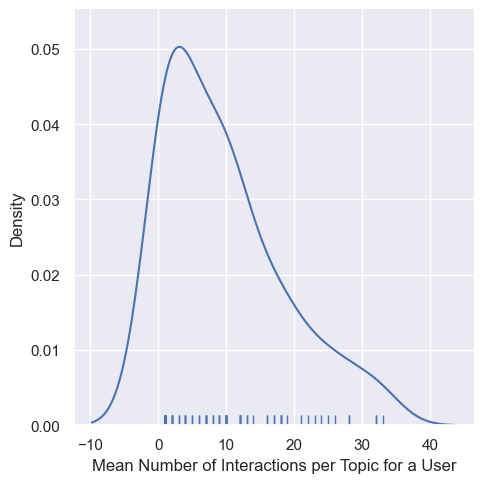

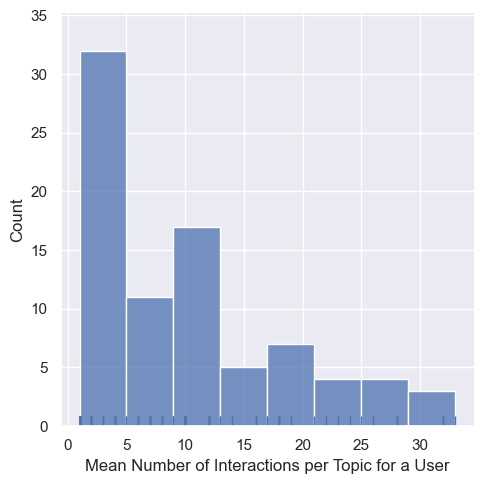



Median:


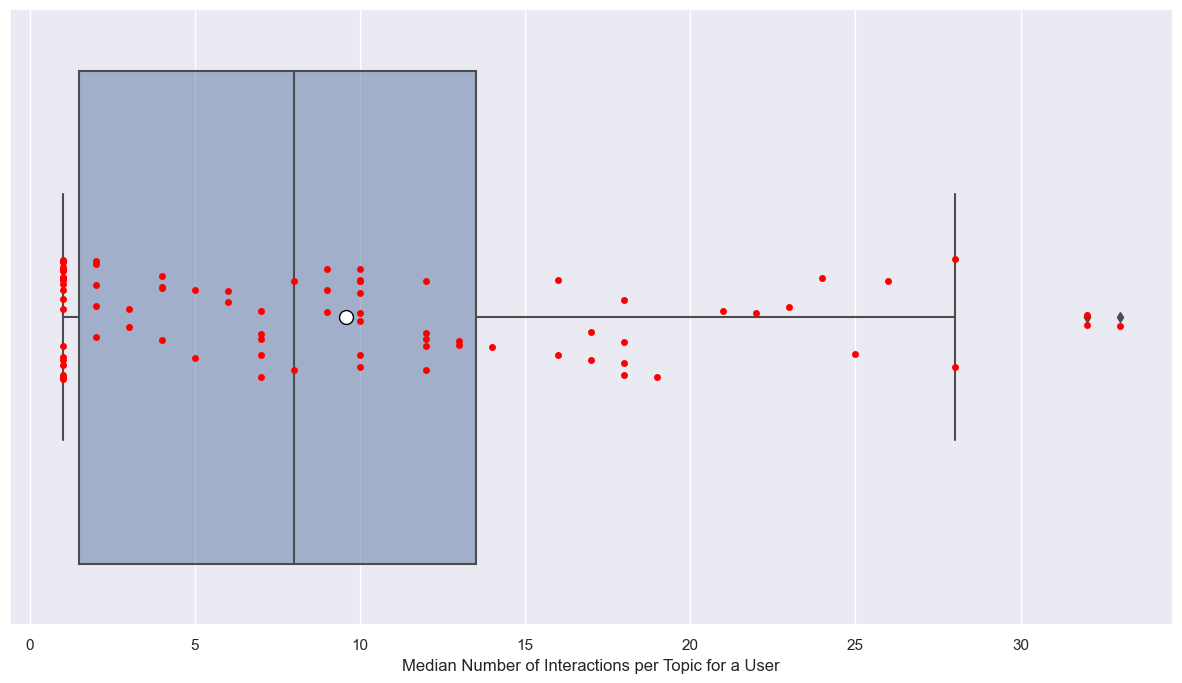

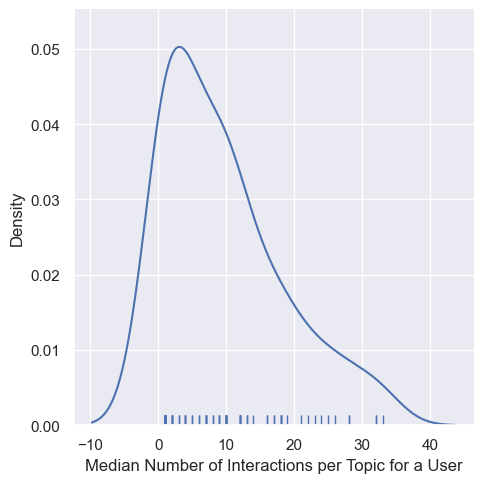

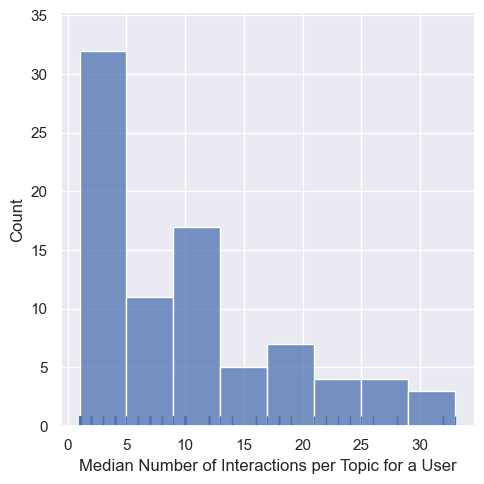

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Mean/Median Number of Interactions per User for a Topic:
----------------------------------------------------------------------------------------------------
mean of Mean Number of Interactions per User for a Topic: 9.566265060240964
median of Mean Number of Interactions per User for a Topic: 9.566265060240964
max of Mean Number of Interactions per User for a Topic: 9.566265060240964
min of Mean Number of Interactions per User for a Topic: 9.566265060240964
std of Mean Number of Interactions per User for a Topic: nan
iqr of Mean Number of Interactions per User for a Topic: 0.0

____________________________________________________________________________________________________

mean of 

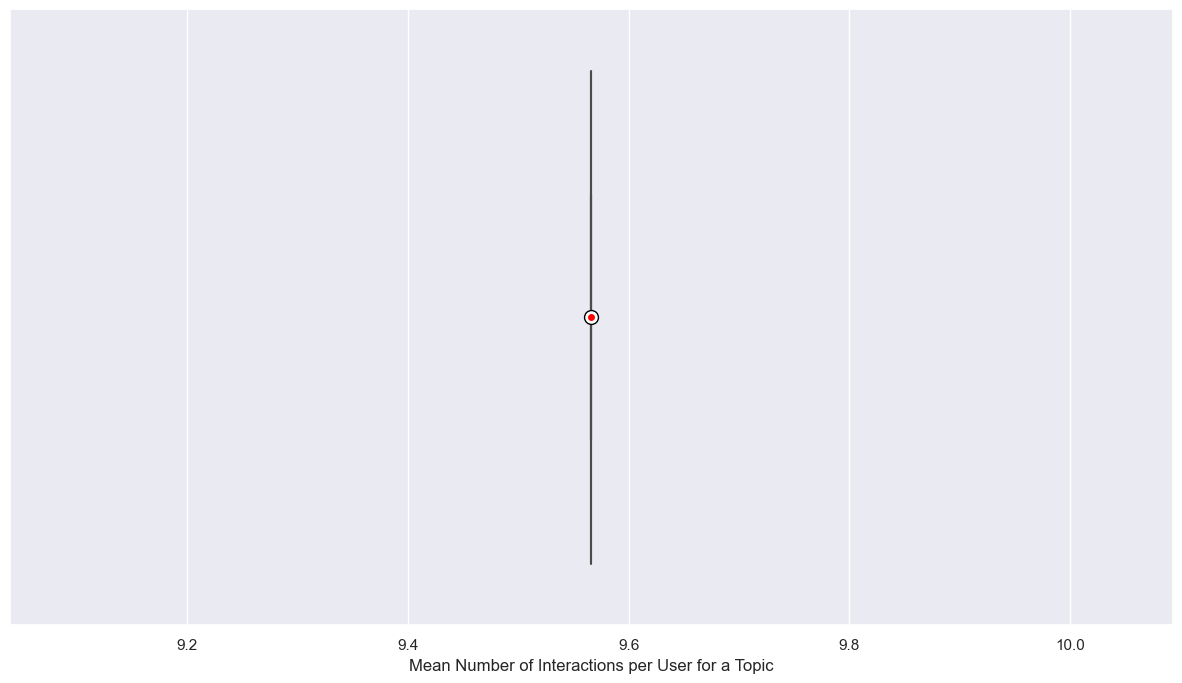

/Users/stefanschmerda/stefan/code/repos/know_center/ddia_dataset_analysis/dataset_analysis/notebooks/../utilities/functions.py:1188: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=data,


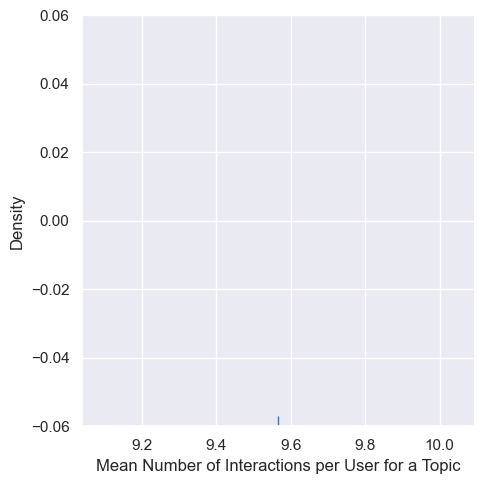

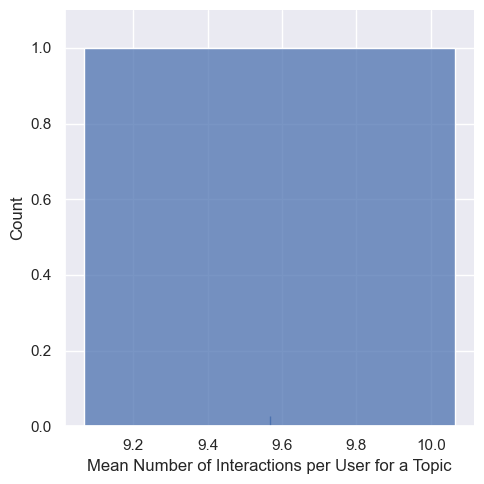



Median:


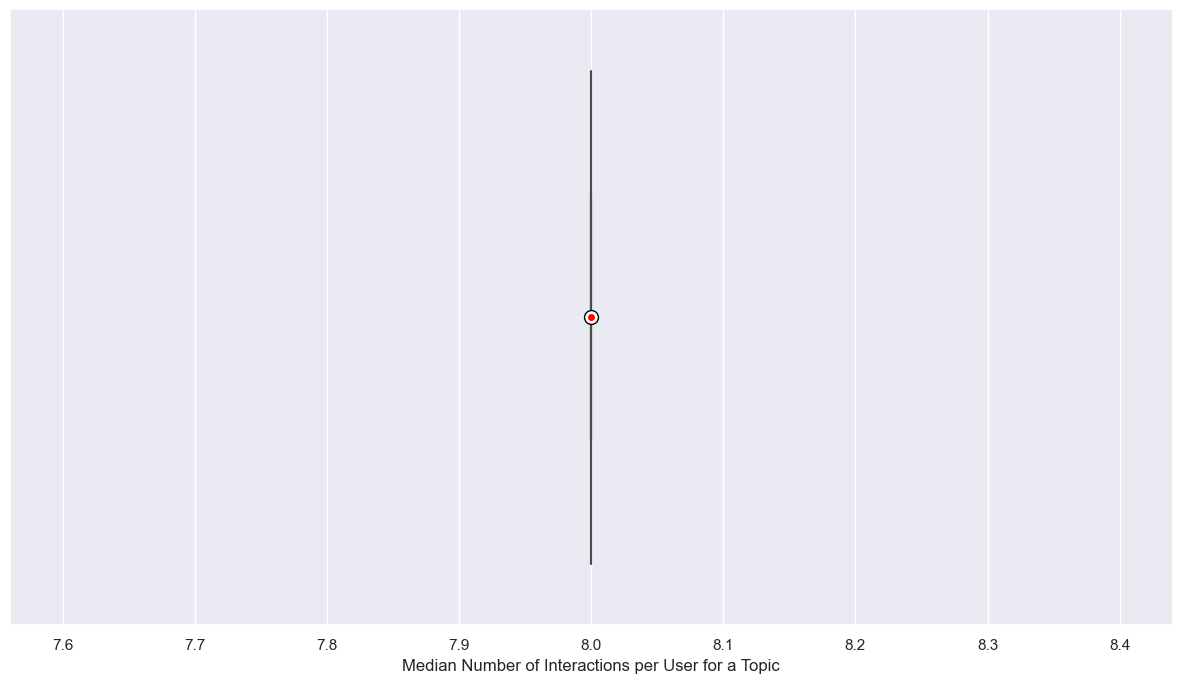

/Users/stefanschmerda/stefan/code/repos/know_center/ddia_dataset_analysis/dataset_analysis/notebooks/../utilities/functions.py:1188: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=data,


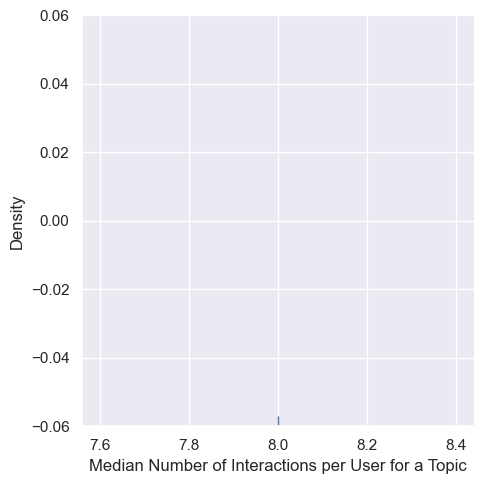

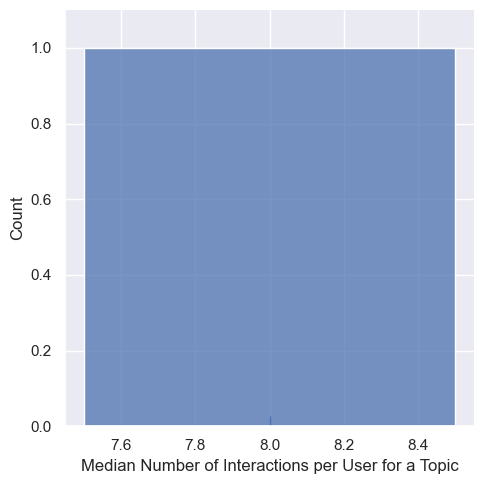

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Mean/Median Number of Unique Learning Resources per Topic for a User:
----------------------------------------------------------------------------------------------------
mean of Mean Number of Unique Learning Resources per Topic for a User: 9.120481927710843
median of Mean Number of Unique Learning Resources per Topic for a User: 7.0
max of Mean Number of Unique Learning Resources per Topic for a User: 30.0
min of Mean Number of Unique Learning Resources per Topic for a User: 1.0

____________________________________________________________________________________________________

mean of Median Number of Unique Learning Resources per Topic for a User: 9.120481927710843
median of Media

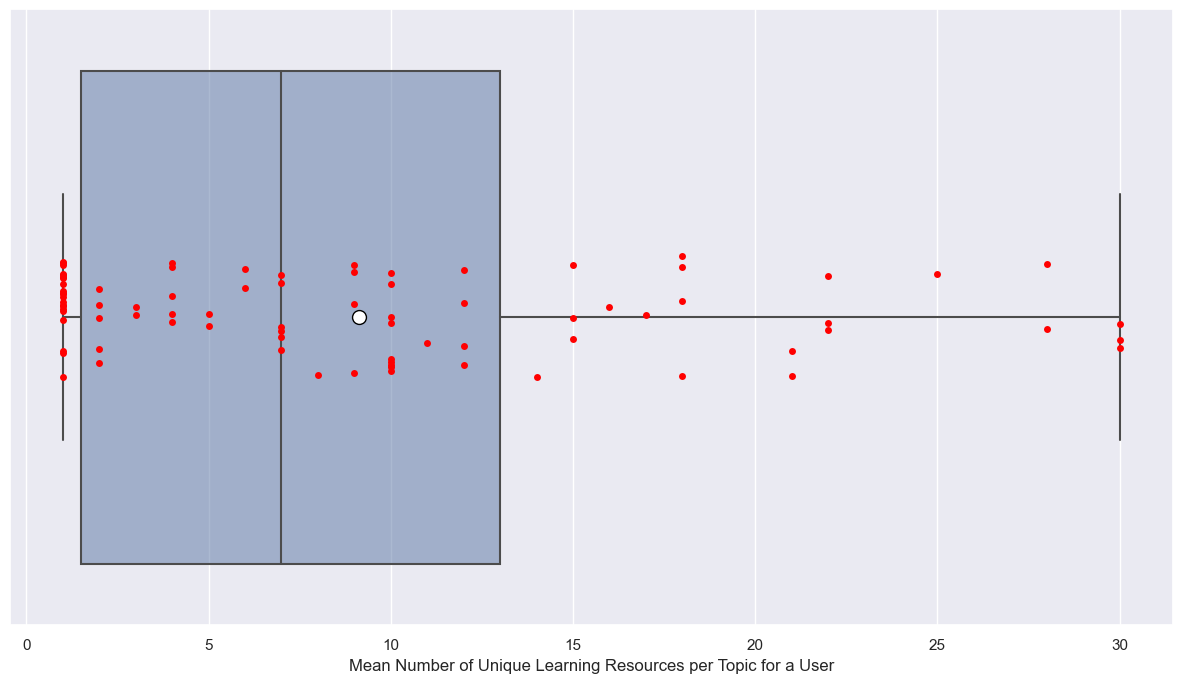

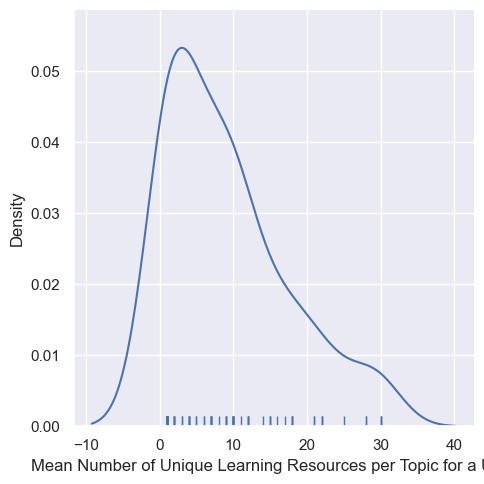

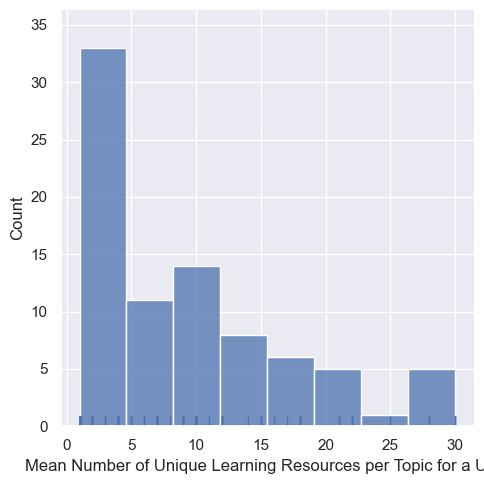



Median:


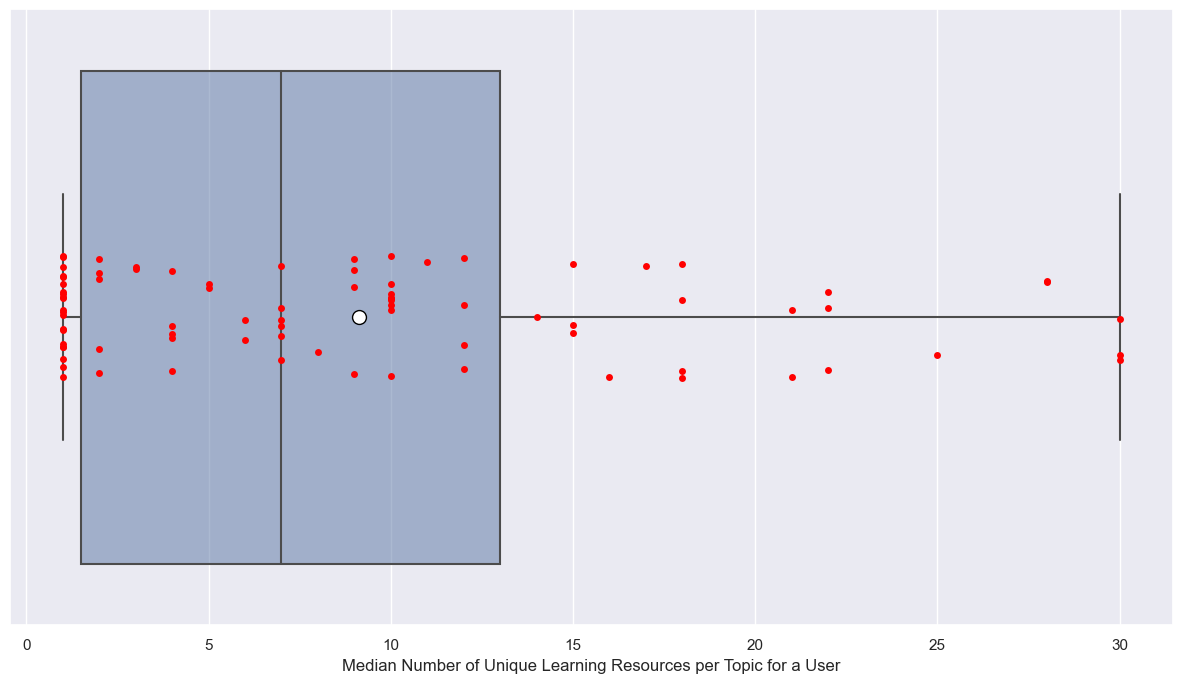

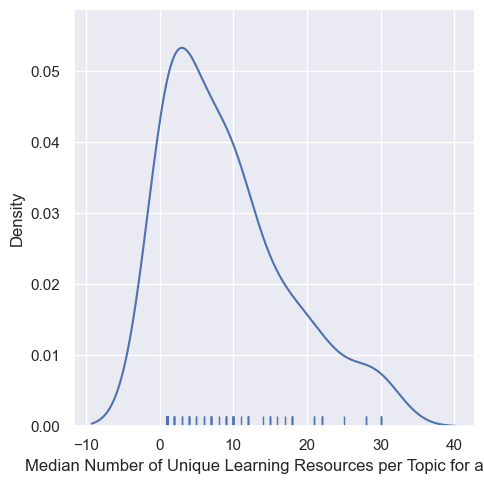

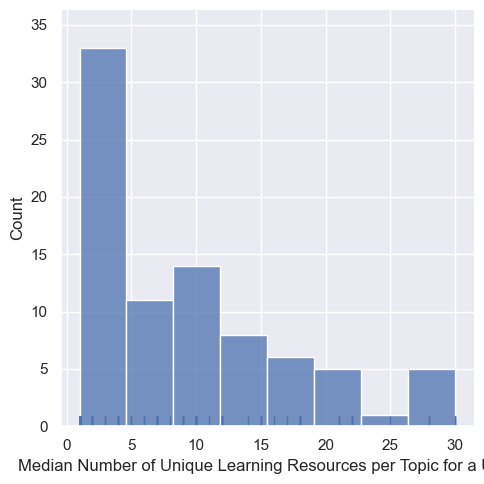

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Mean/Median Number of Unique Learning Resources per User for a Topic:
----------------------------------------------------------------------------------------------------
mean of Mean Number of Unique Learning Resources per User for a Topic: 9.120481927710843
median of Mean Number of Unique Learning Resources per User for a Topic: 9.120481927710843
max of Mean Number of Unique Learning Resources per User for a Topic: 9.120481927710843
min of Mean Number of Unique Learning Resources per User for a Topic: 9.120481927710843

____________________________________________________________________________________________________

mean of Median Number of Unique Learning Resources per User for a

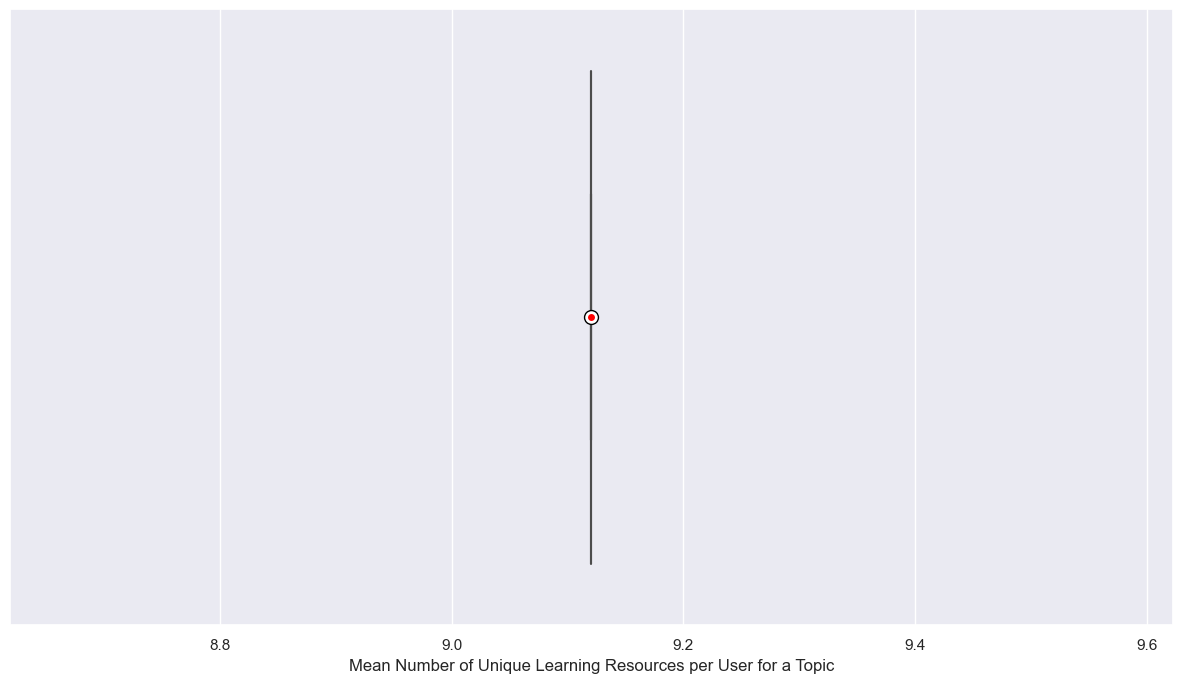

/Users/stefanschmerda/stefan/code/repos/know_center/ddia_dataset_analysis/dataset_analysis/notebooks/../utilities/functions.py:1188: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=data,


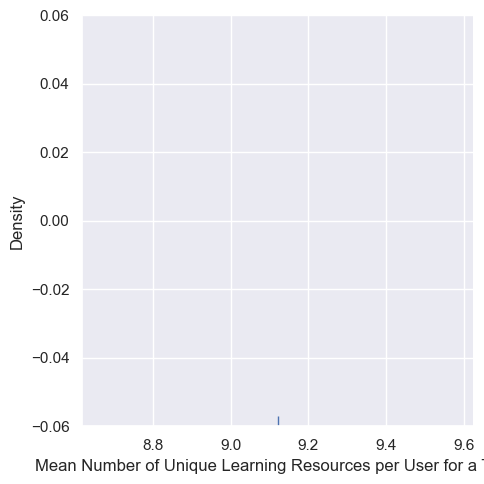

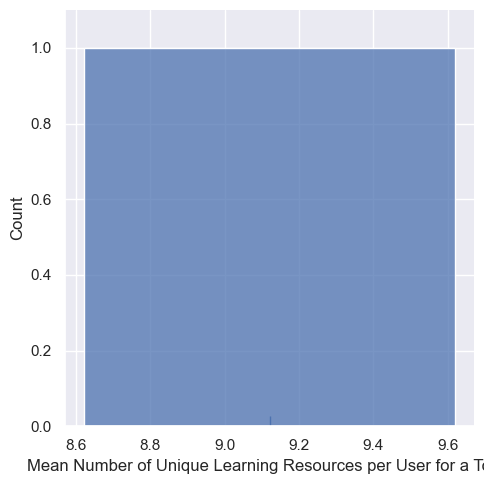



Median:


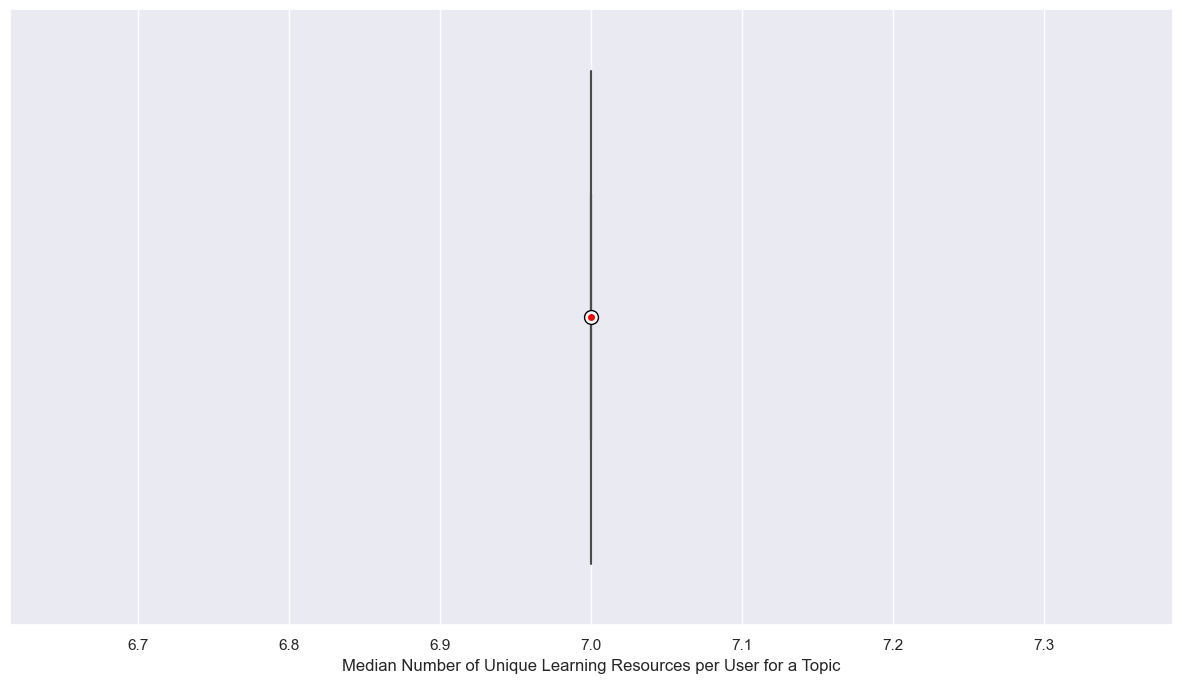

/Users/stefanschmerda/stefan/code/repos/know_center/ddia_dataset_analysis/dataset_analysis/notebooks/../utilities/functions.py:1188: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=data,


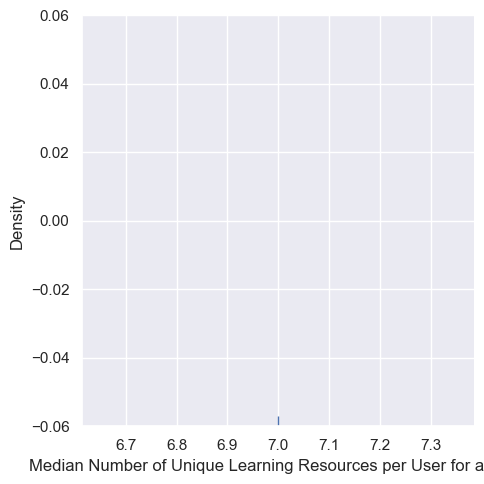

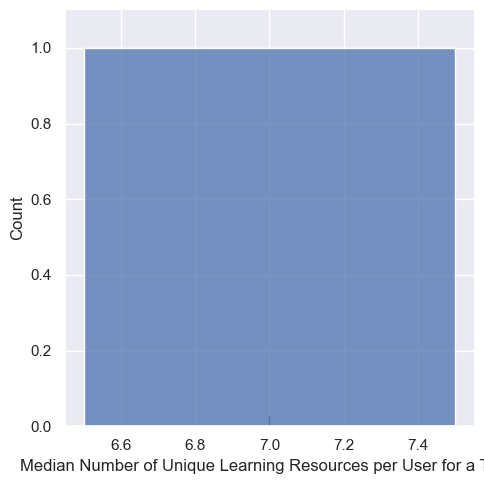

****************************************************************************************************
****************************************************************************************************
 


In [25]:
print_and_plot_group_user_learning_activity_relationship(interactions,
                                                         GROUP_FIELD,
                                                         False)

## Unique Sequence Statistics

In [26]:
learning_activity_sequence_stats_per_group = return_learning_activity_sequence_stats_over_user_per_group(interactions,
                                                                                                         DATASET_NAME,
                                                                                                         None, 
                                                                                                         USER_FIELD_NAME_STR, 
                                                                                                         LEARNING_ACTIVITY_FIELD_NAME_STR,
                                                                                                         TIMESTAMP_FIELD_NAME_STR)

In [27]:
pickle_write(learning_activity_sequence_stats_per_group,
             PATH_TO_SEQUENCE_STATISTICS_PICKLE_FOLDER,
             DATASET_NAME + SEQUENCE_STATISTICS_TABLES_PICKLE_NAME)

### Unique Sequence Statistics

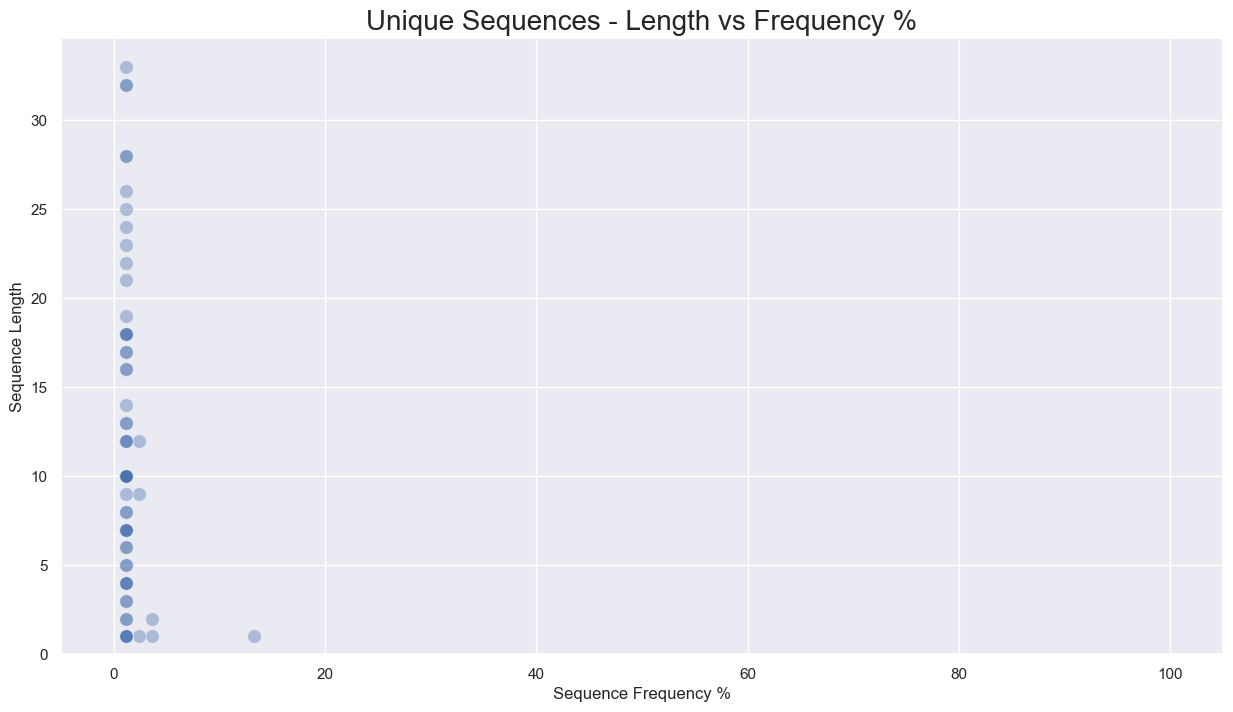

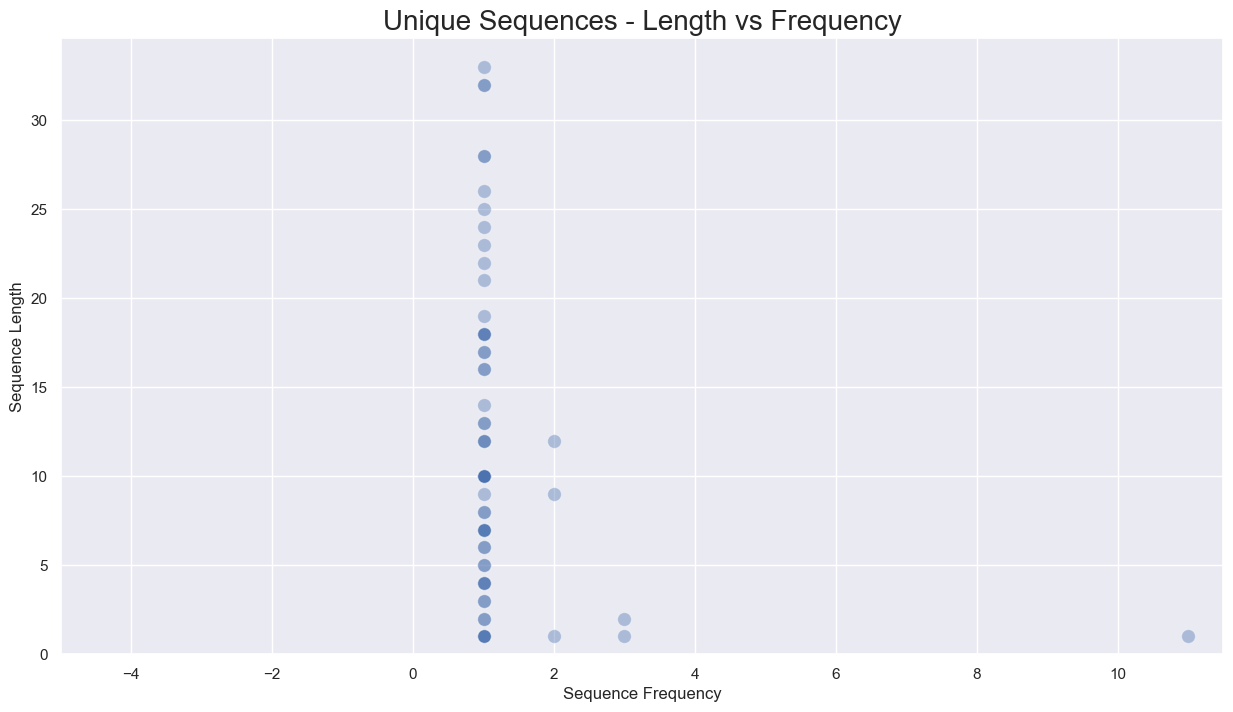

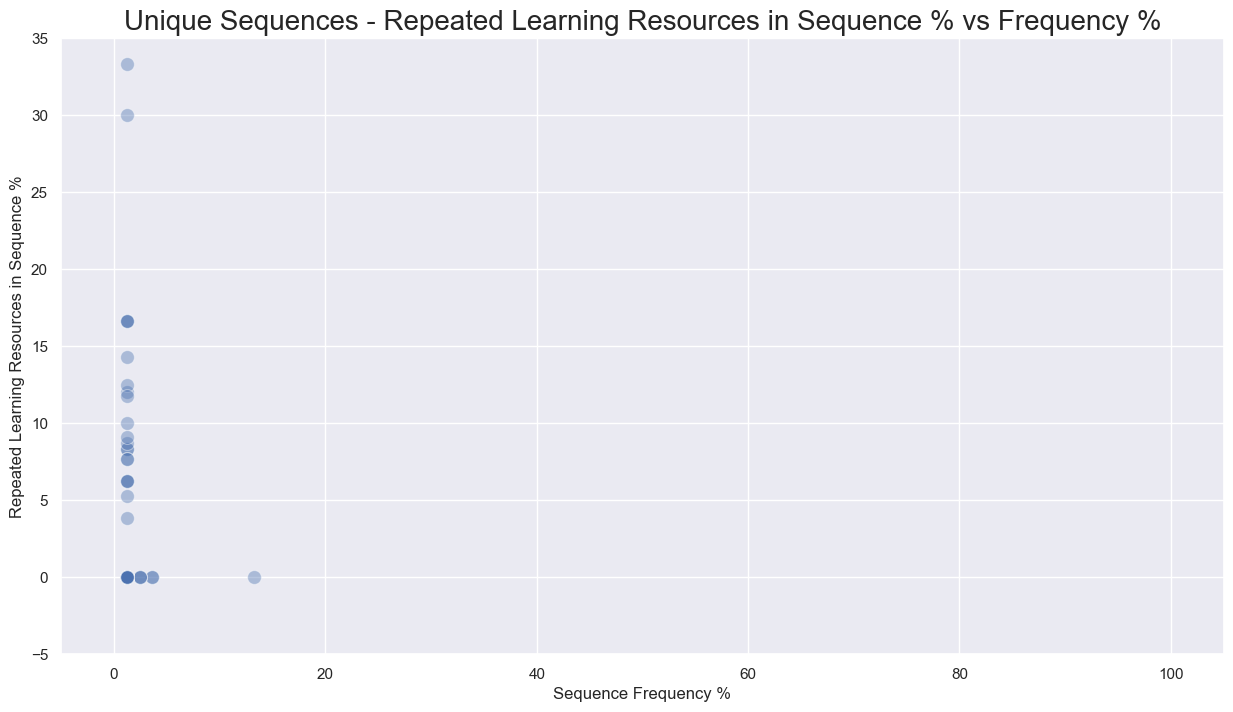

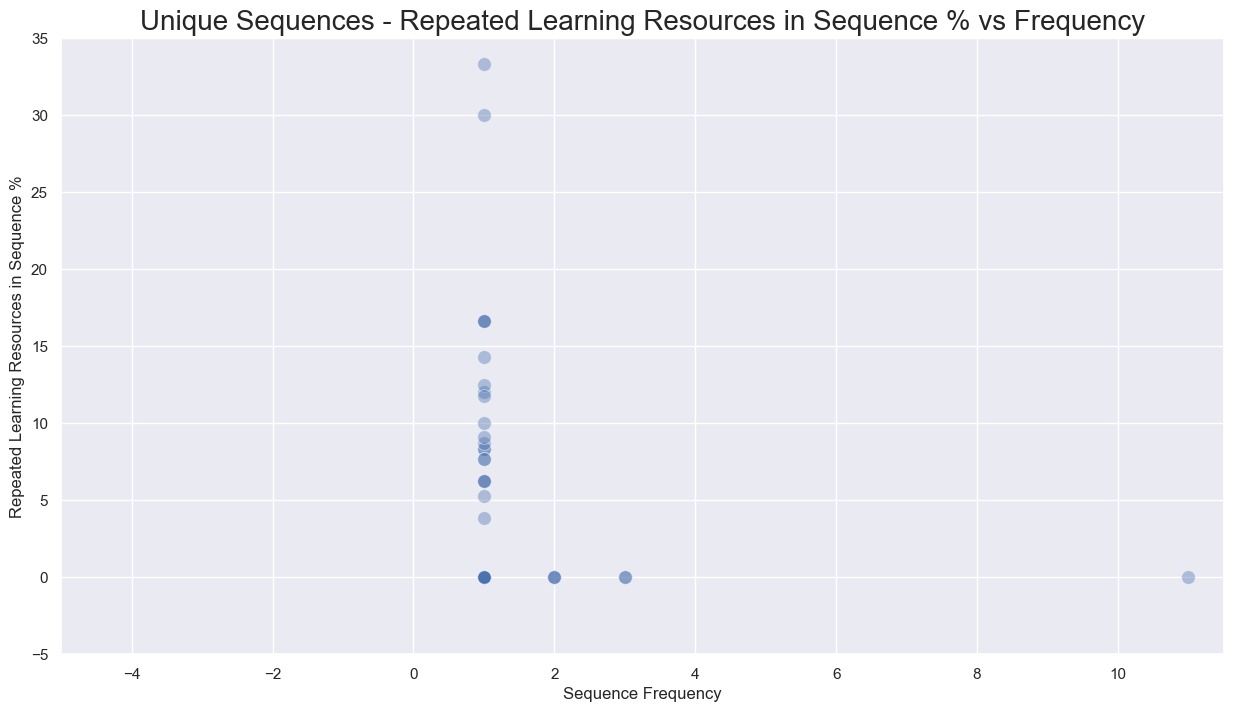

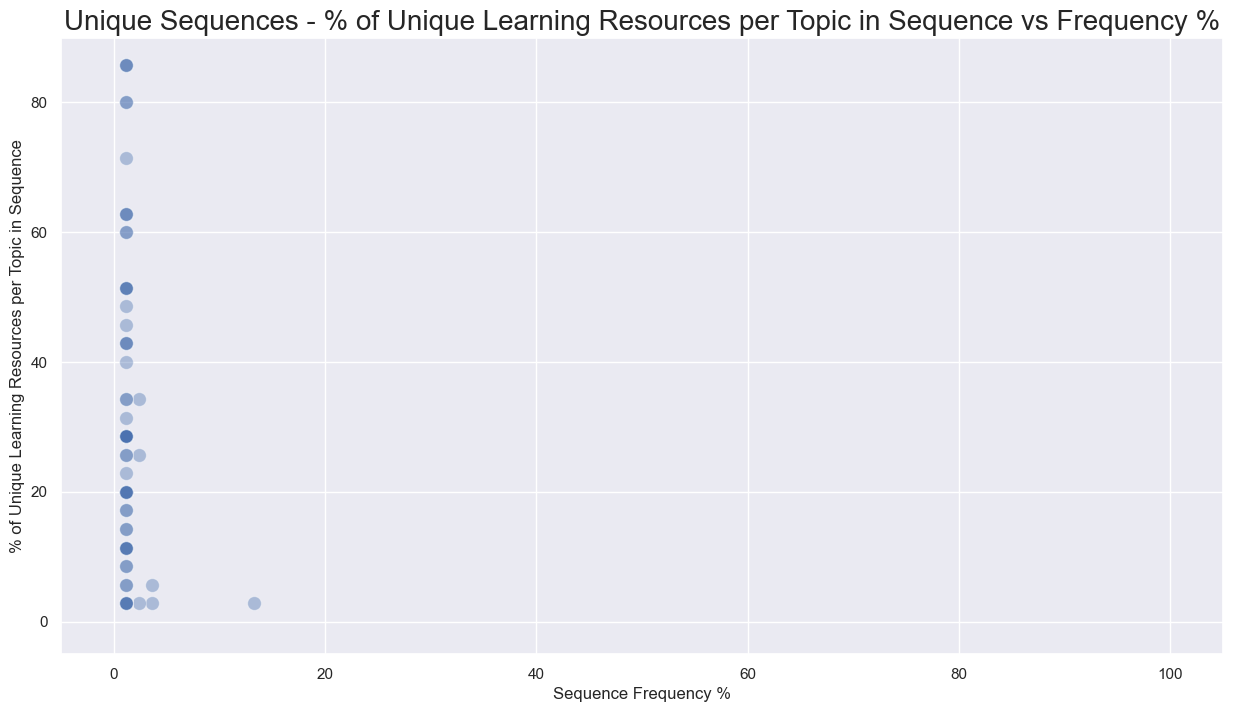

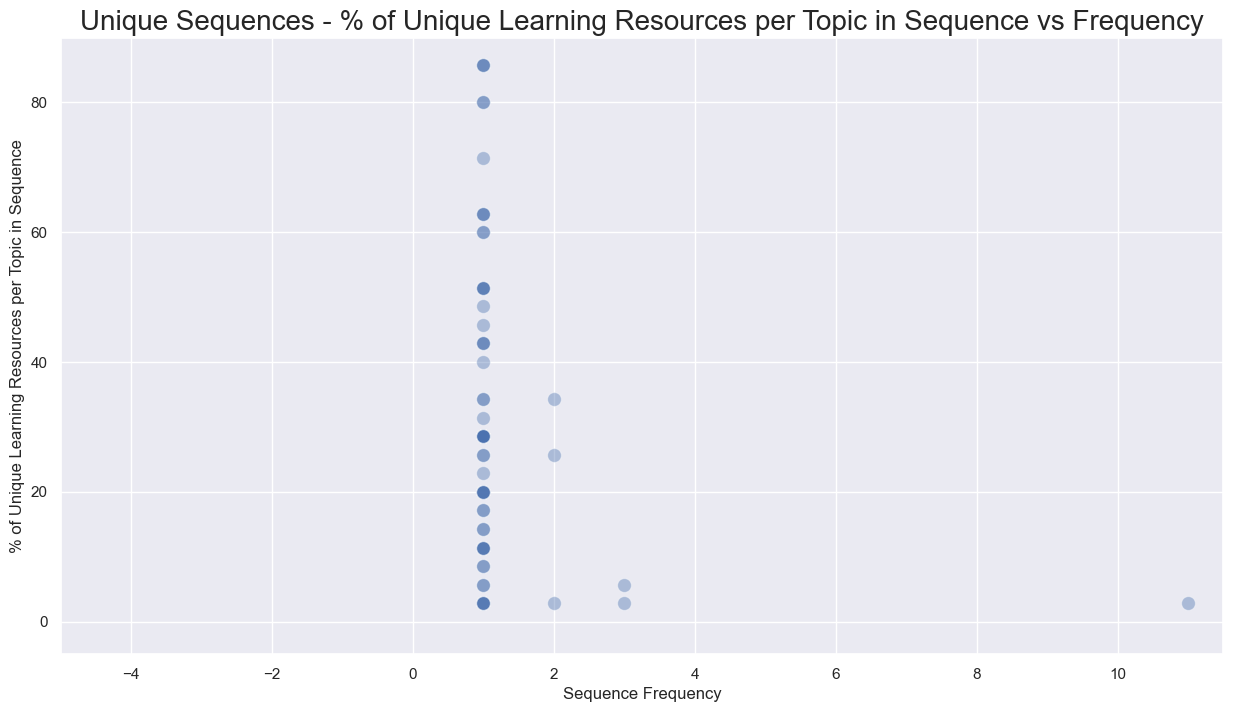

In [28]:
plot_sequence_stats(learning_activity_sequence_stats_per_group)

### Unique Sequence Statistics per Group

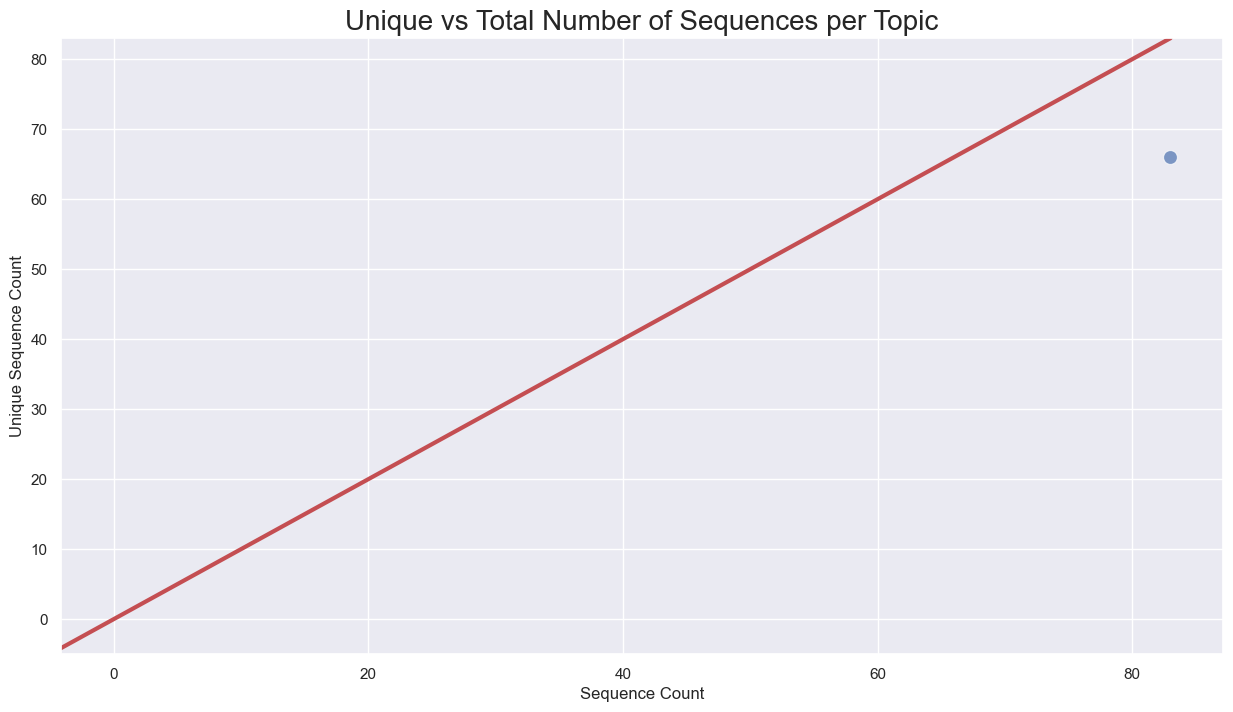

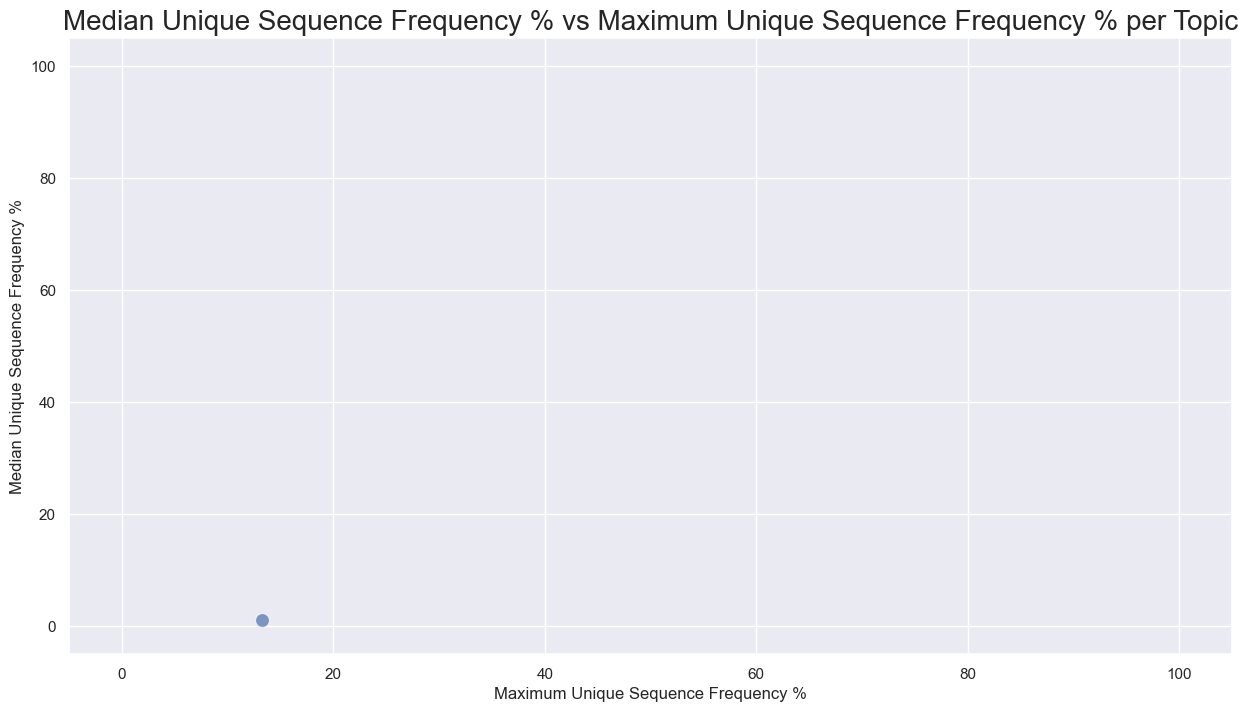

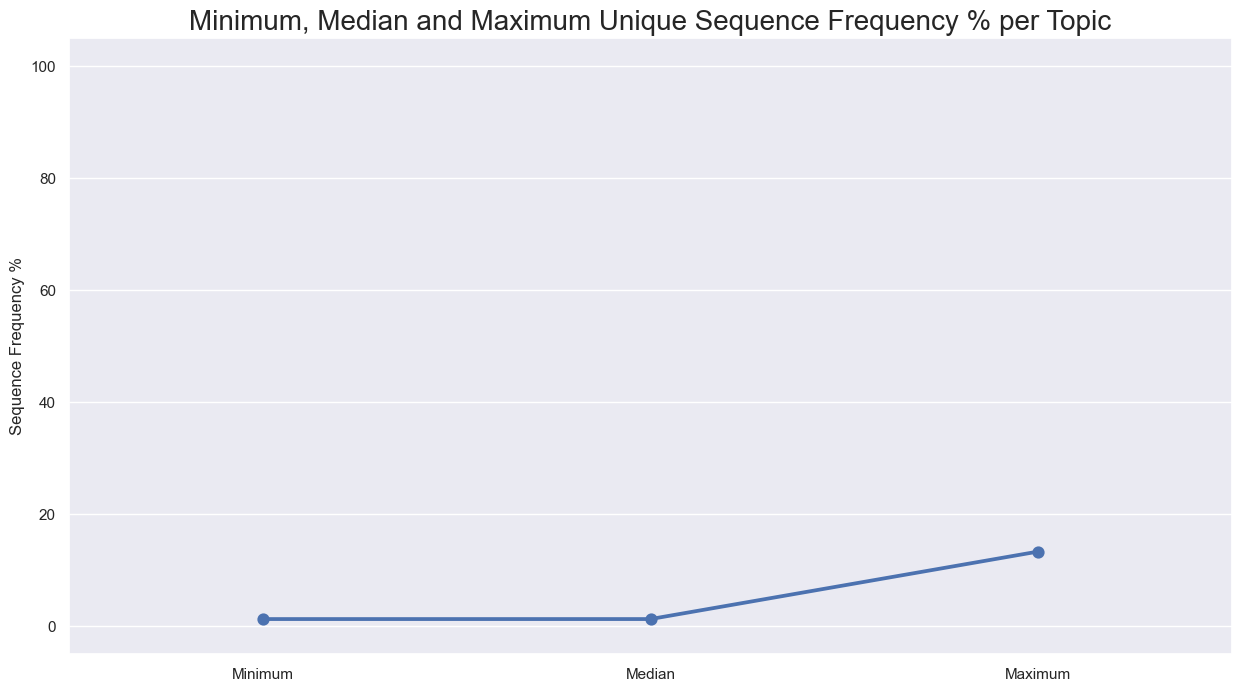

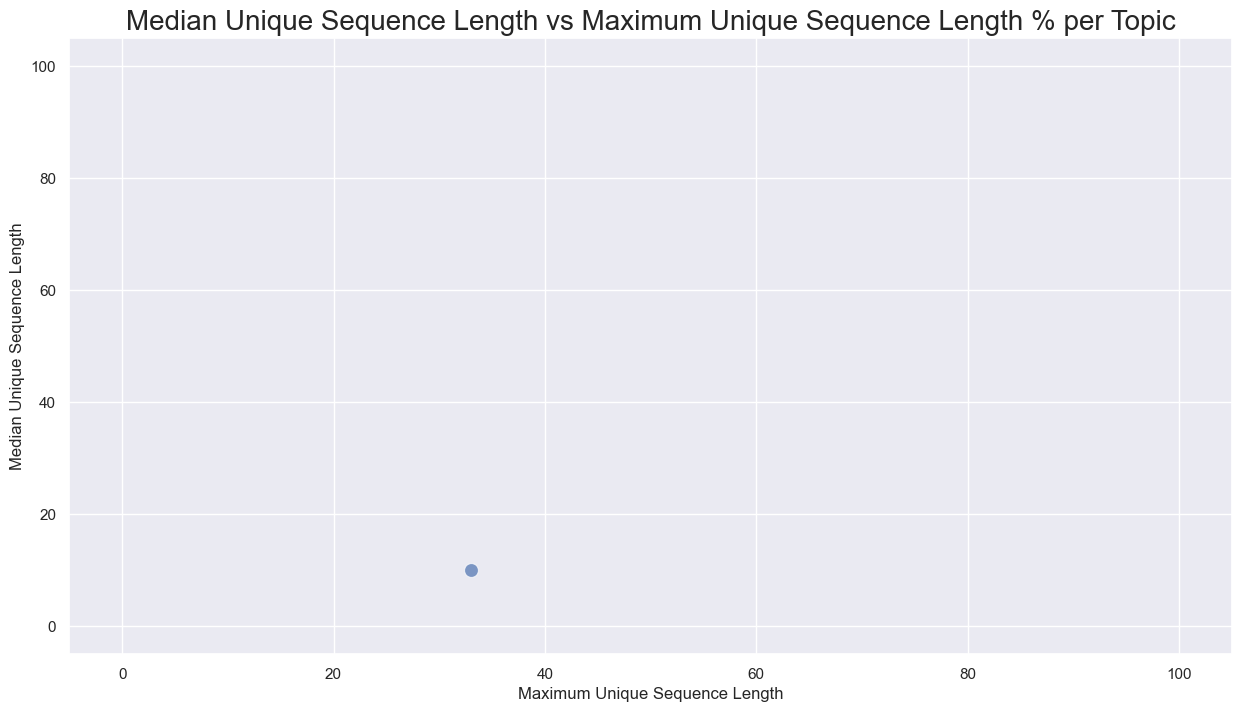

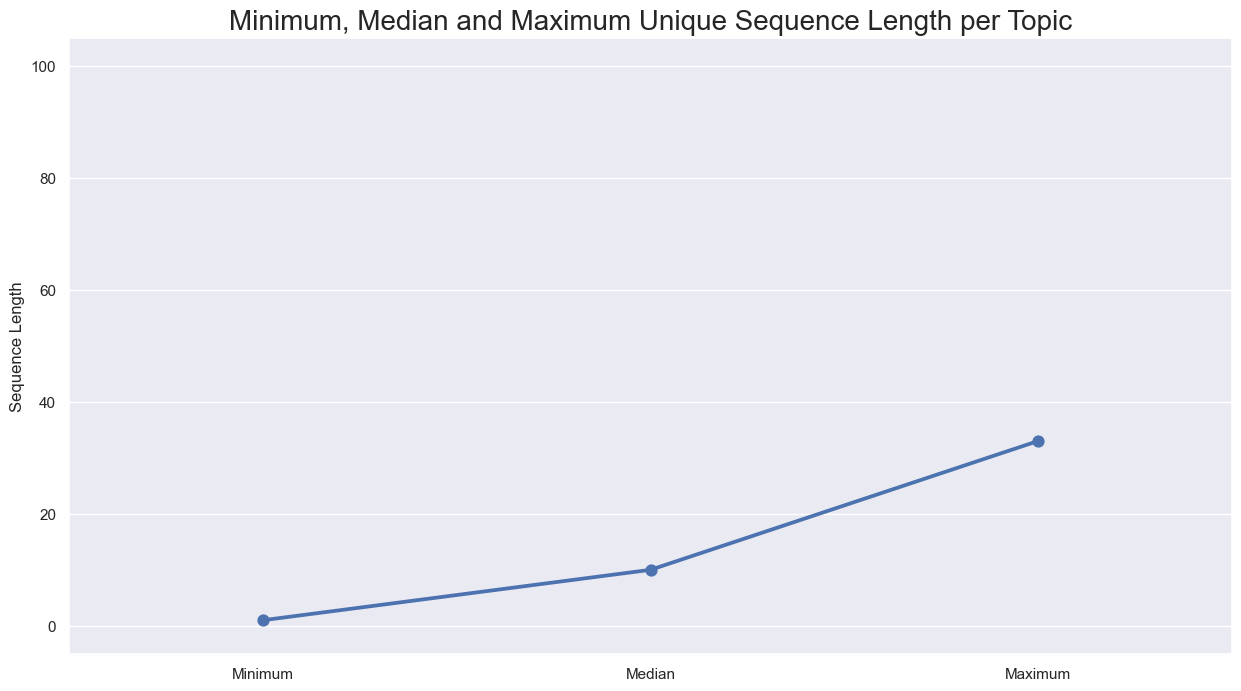

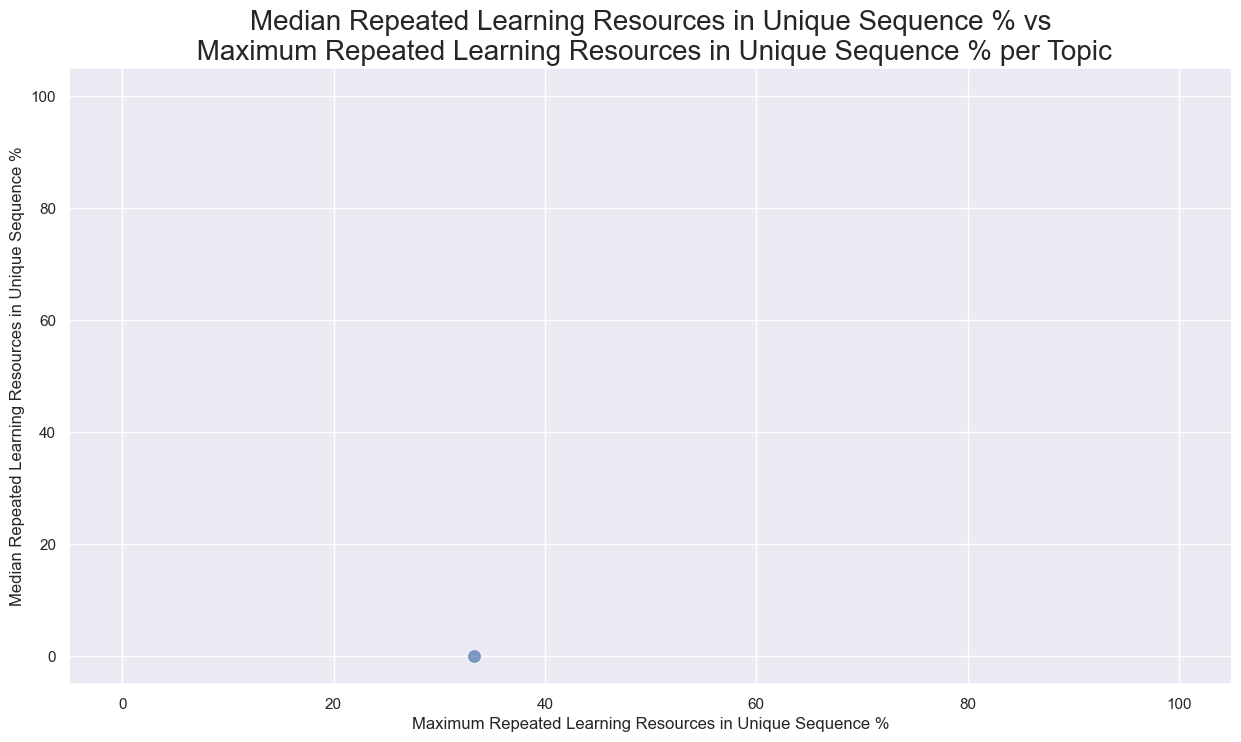

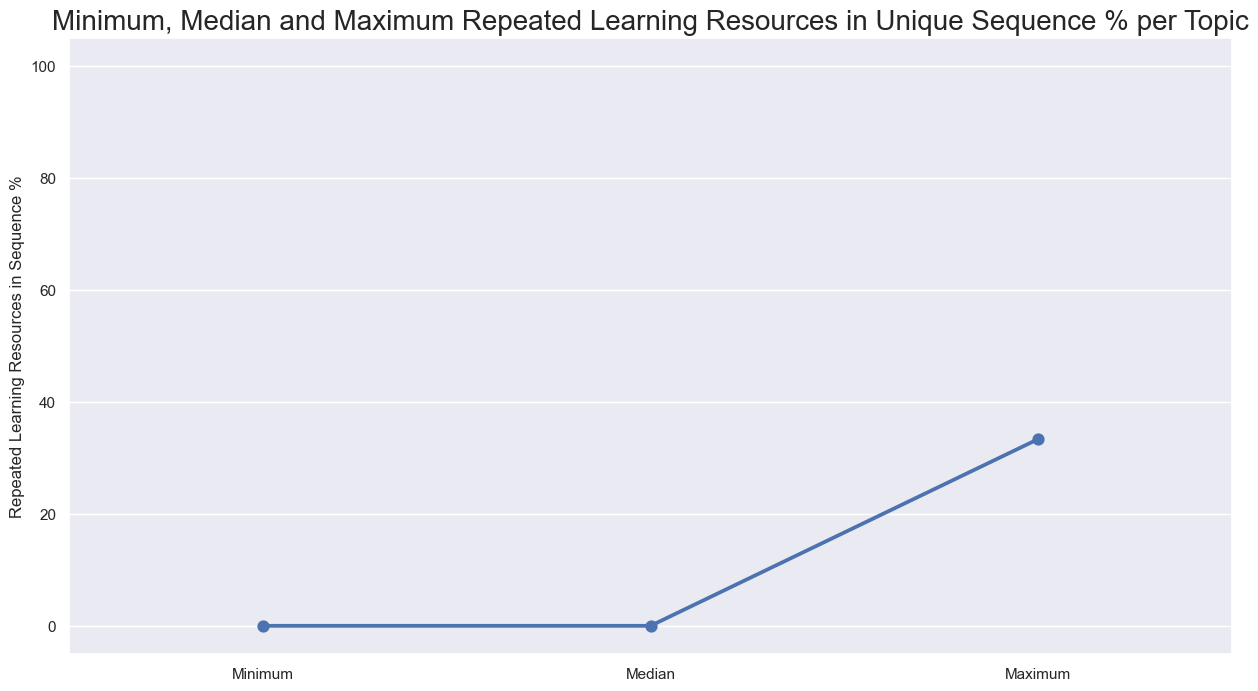

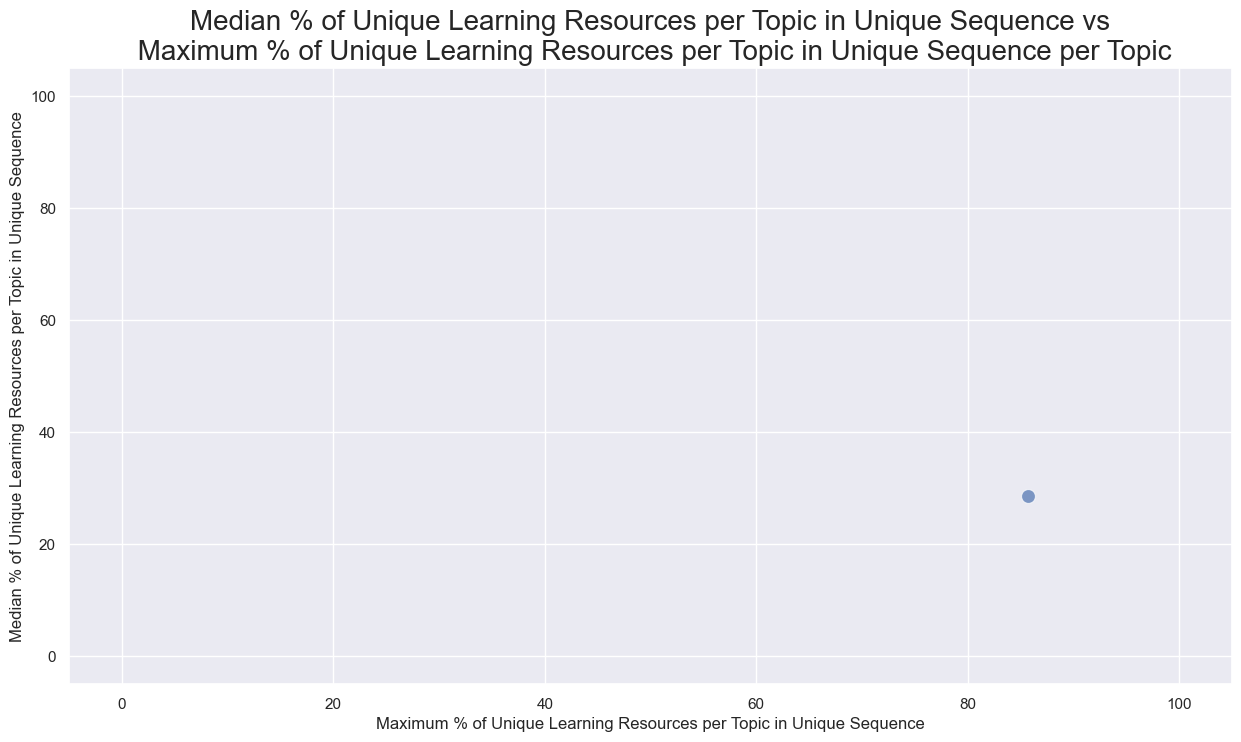

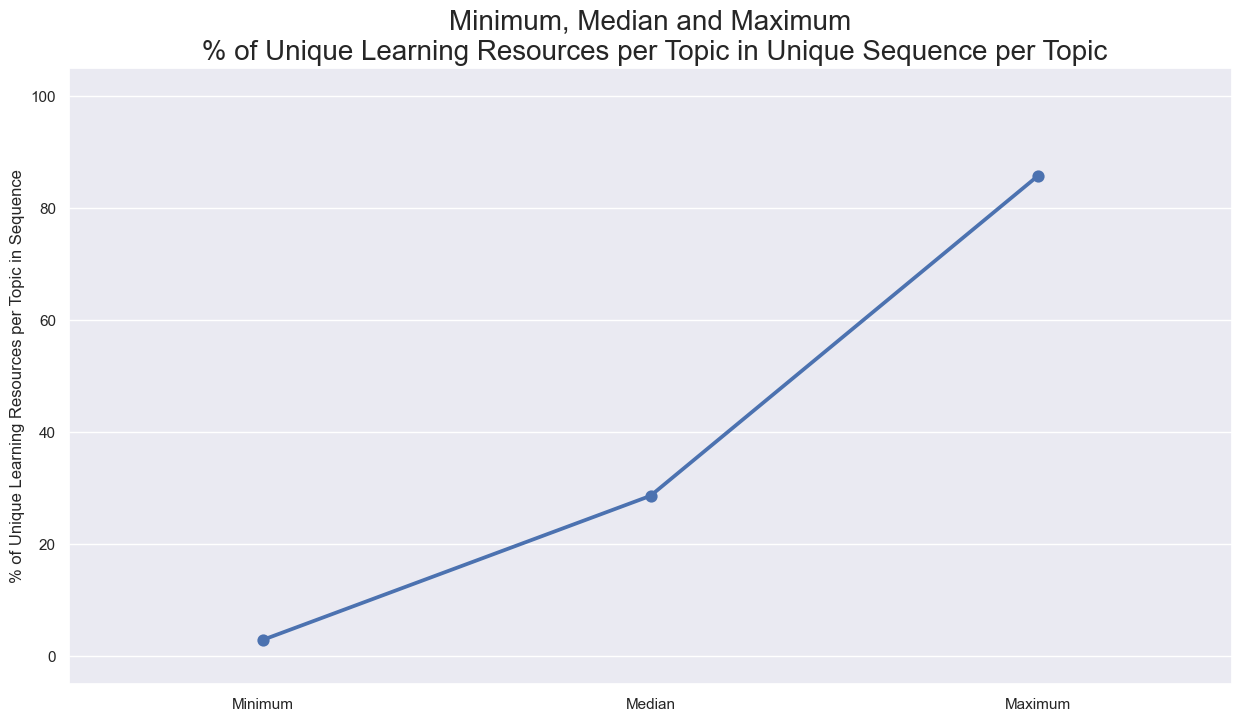

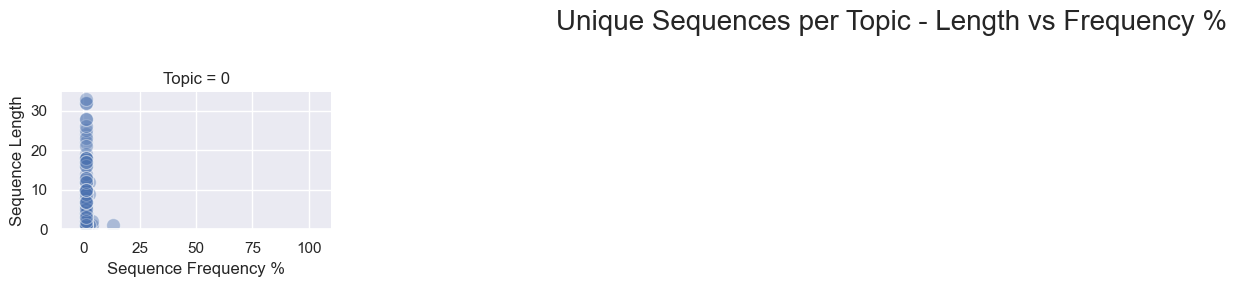

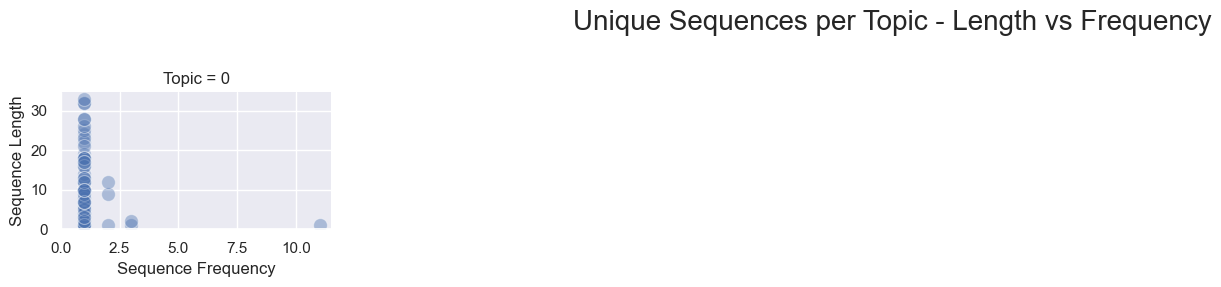

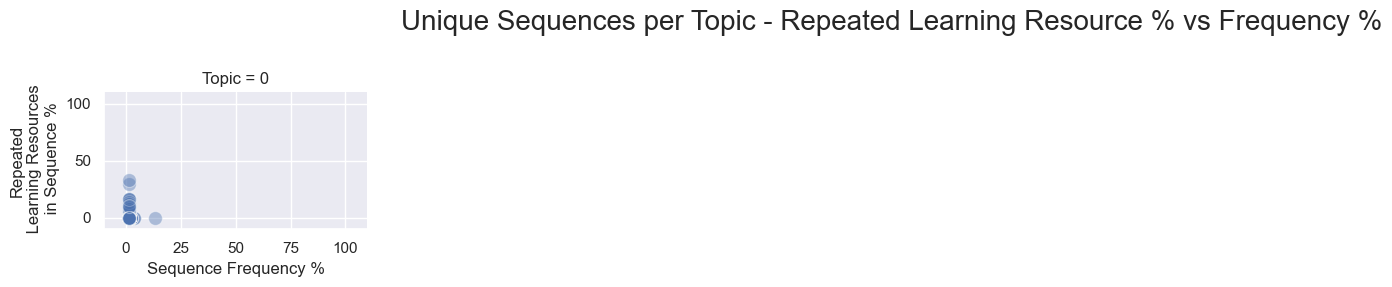

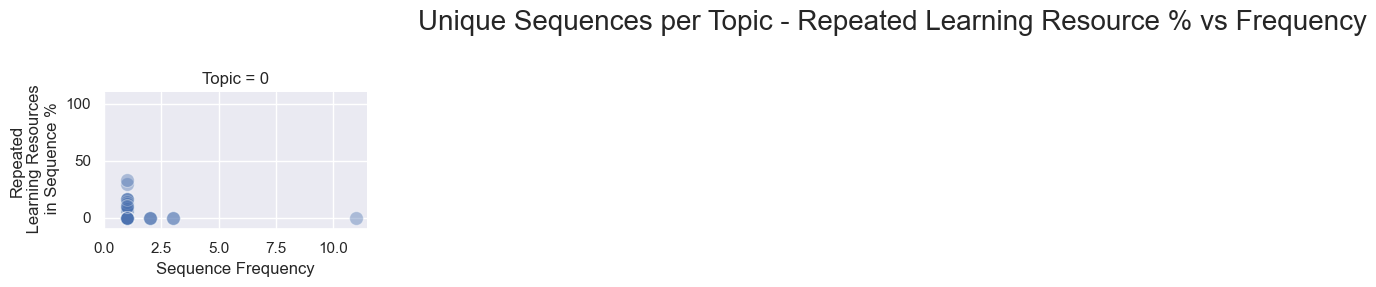

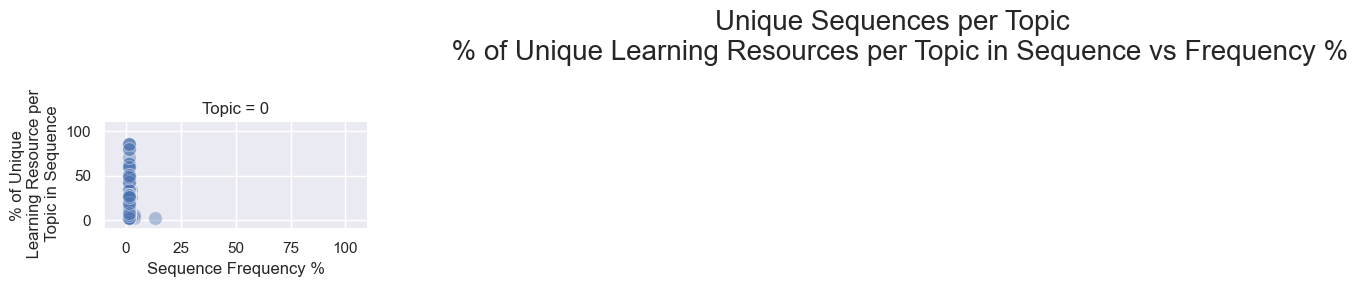

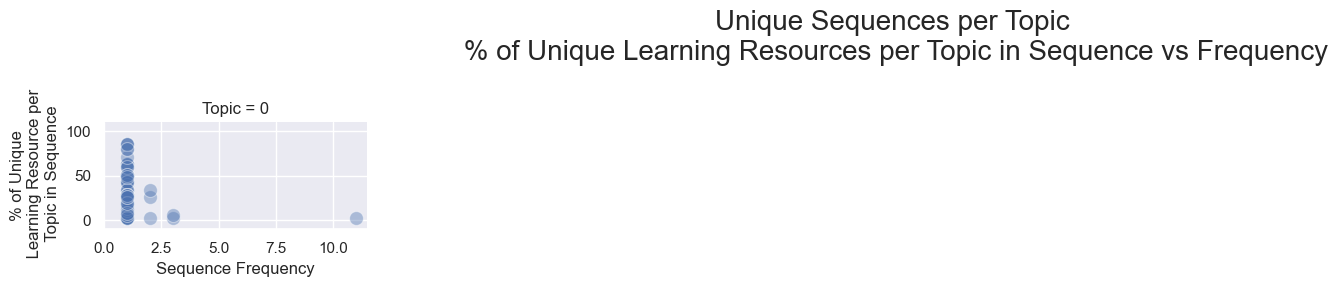

In [29]:
plot_sequence_stats_per_group(learning_activity_sequence_stats_per_group,
                              GROUP_FIELD_NAME_STR)

## Sequence Distance

In [30]:
seq_distances = calculate_sequence_distances(interactions, 
                                             USER_FIELD_NAME_STR, 
                                             None, 
                                             LEARNING_ACTIVITY_FIELD_NAME_STR, 
                                             SEQUENCE_ID_FIELD_NAME_STR)

--------------------
Topic-Field NOT Available:
Calulate Sequence Distances
--------------------
--------------------------------------------------
Total number of users: 83
--------------------------------------------------
--------------------------------------------------
Final number of Users: 83
Final number of interactions: 794
--------------------------------------------------


2211it [00:00, 1497191.82it/s]

--------------------------------------------------
Duration in seconds: 0.007616996765136719
--------------------------------------------------


In [31]:
pickle_write(seq_distances,
             PATH_TO_SEQUENCE_DISTANCES_PICKLE_FOLDER,
             DATASET_NAME + SEQUENCE_DISTANCE_DICT_PER_GROUP_PICKLE_NAME)

100%|██████████| 1/1 [00:00<00:00, 3498.17it/s]

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Sequence Distance per Topic:
Base: All User-Sequence Combinations
----------------------------------------------------------------------------------------------------


Plots:


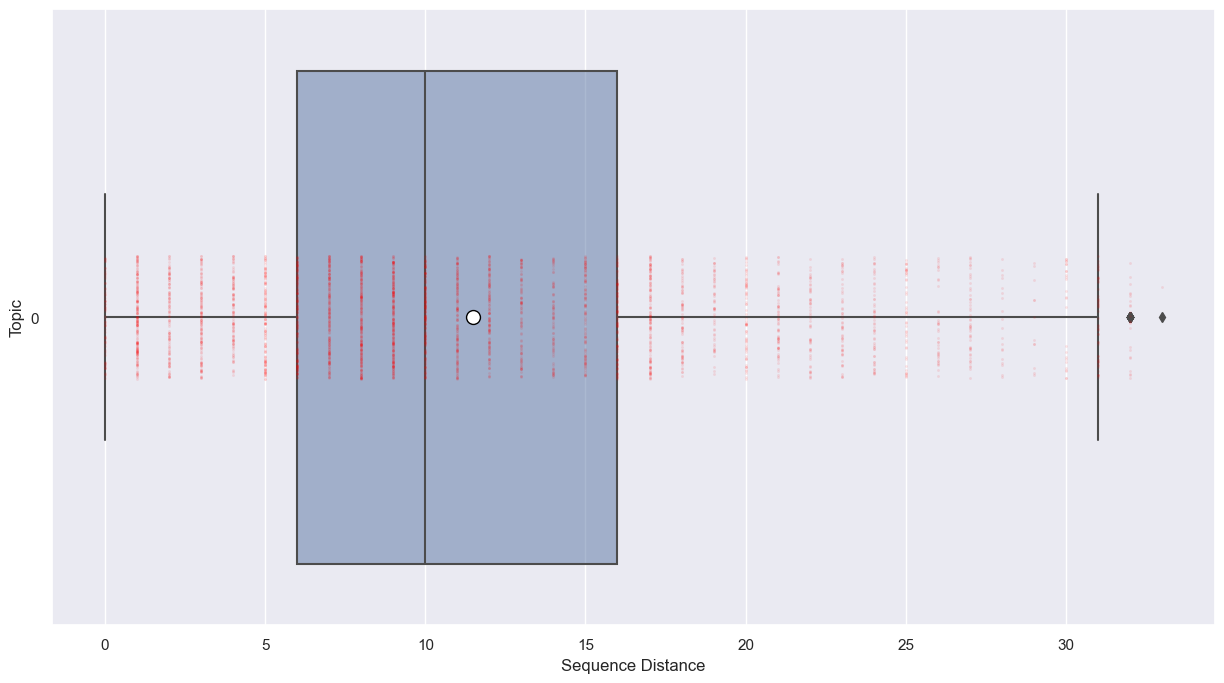

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Normalized Sequence Distance per Topic:
Base: All User-Sequence Combinations
----------------------------------------------------------------------------------------------------


Plots:


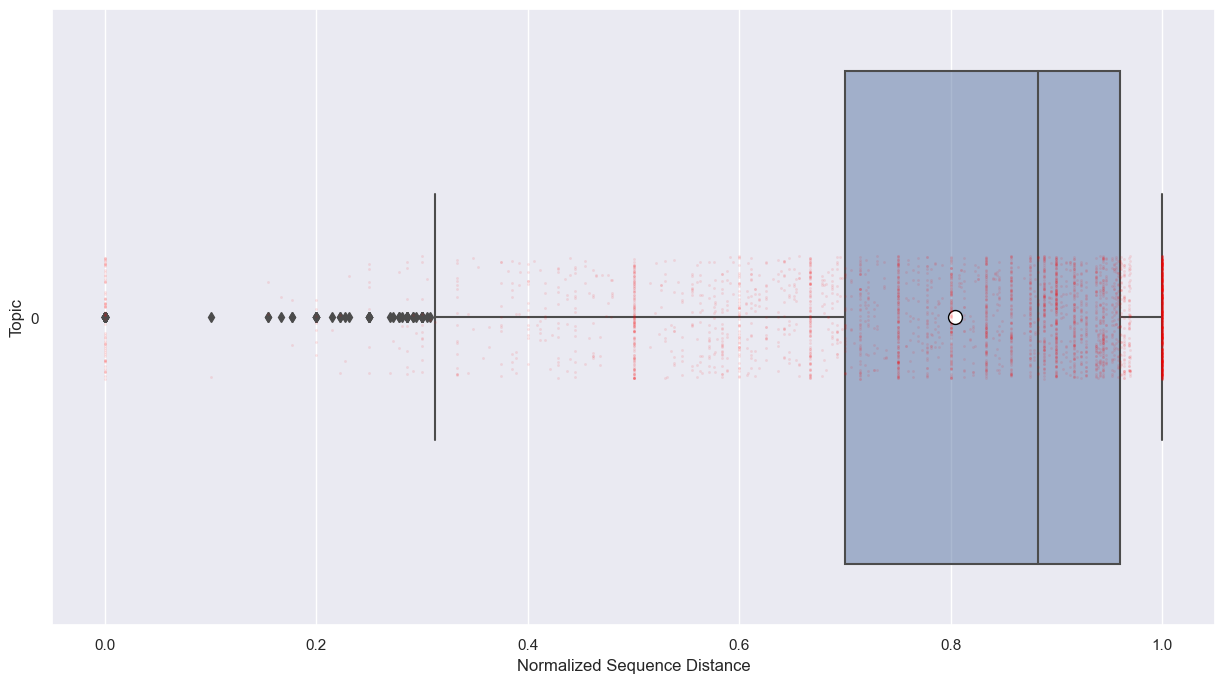

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Mean Sequence Distance per Topic:
----------------------------------------------------------------------------------------------------


Plots:


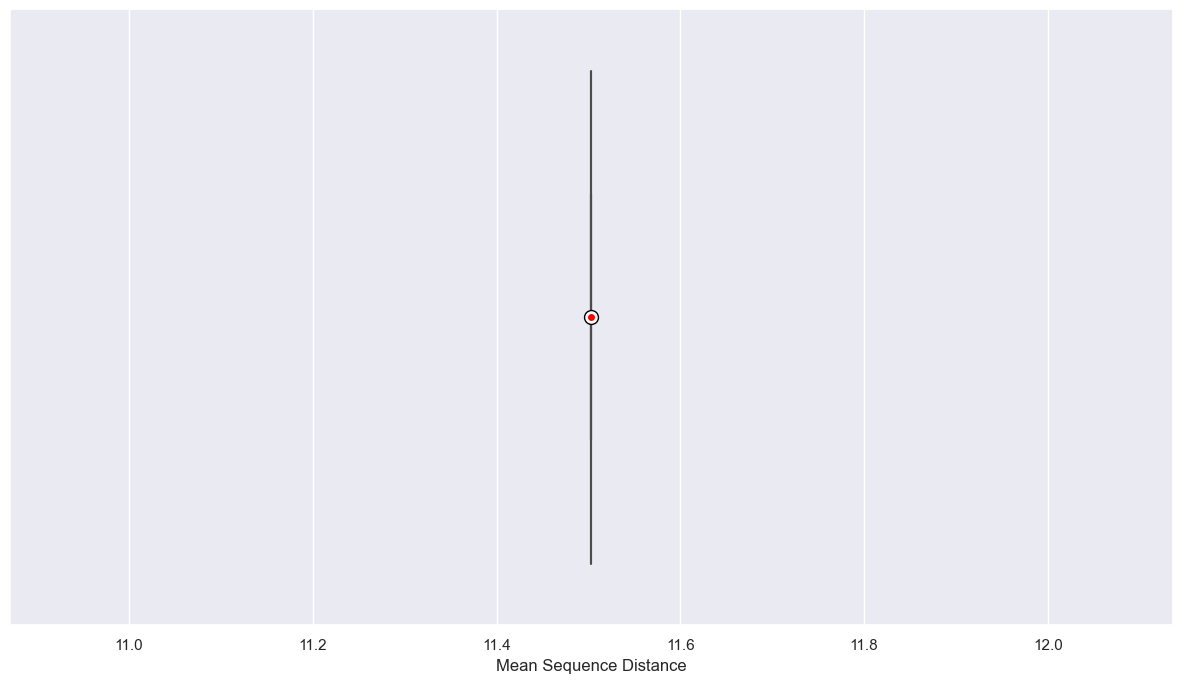

/Users/stefanschmerda/stefan/code/repos/know_center/ddia_dataset_analysis/dataset_analysis/notebooks/../utilities/functions.py:1221: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=data,


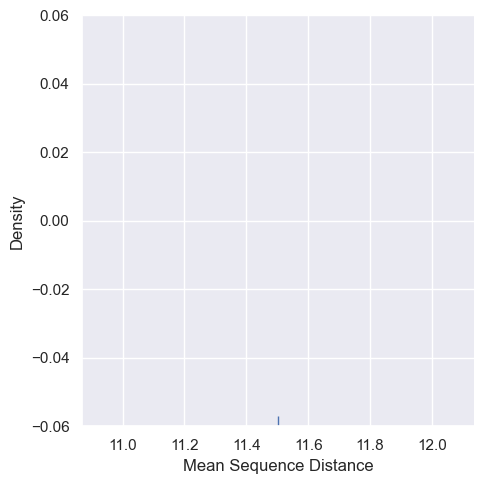

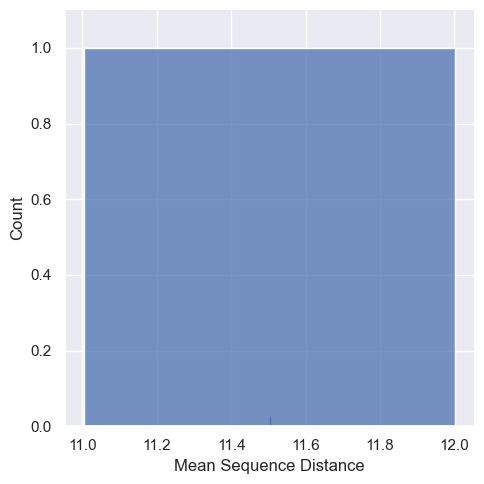

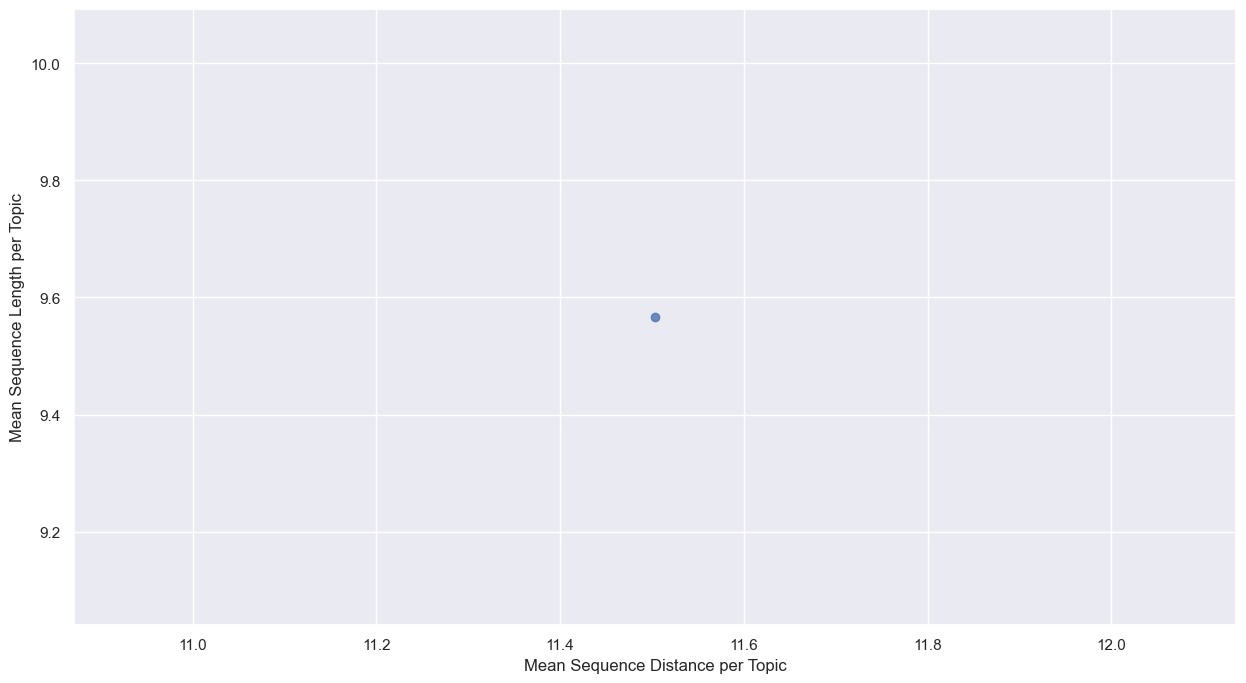

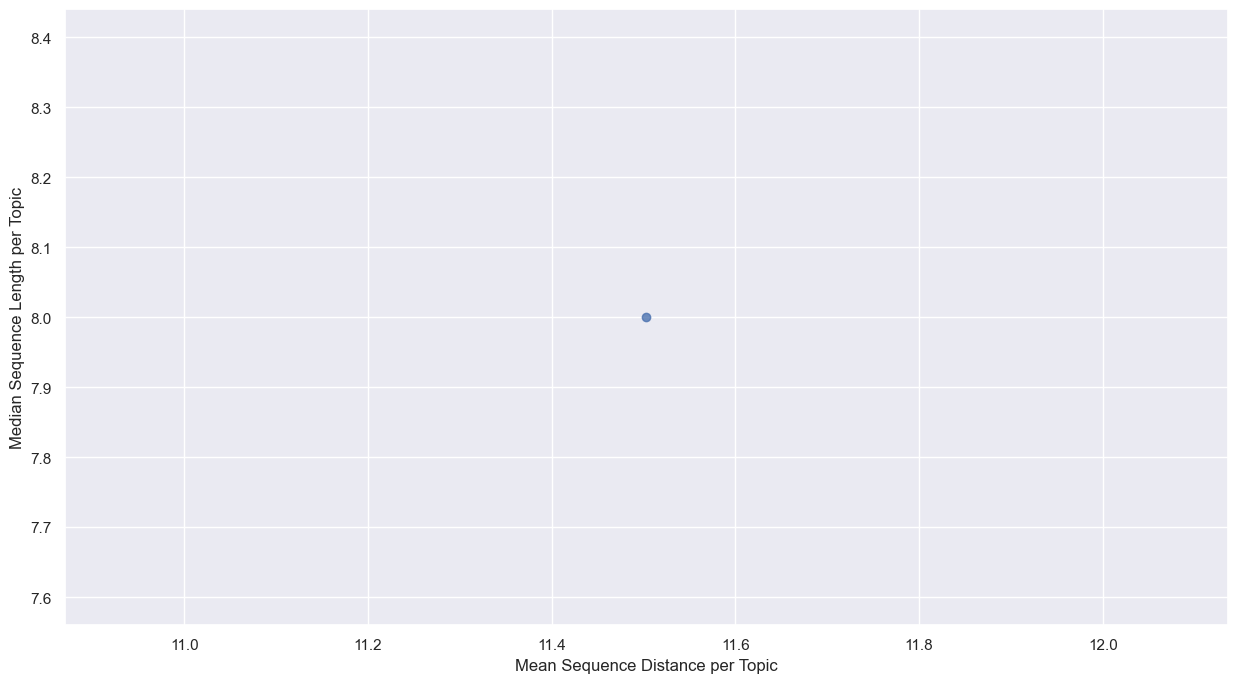

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Median Sequence Distance per Topic:
----------------------------------------------------------------------------------------------------


Plots:


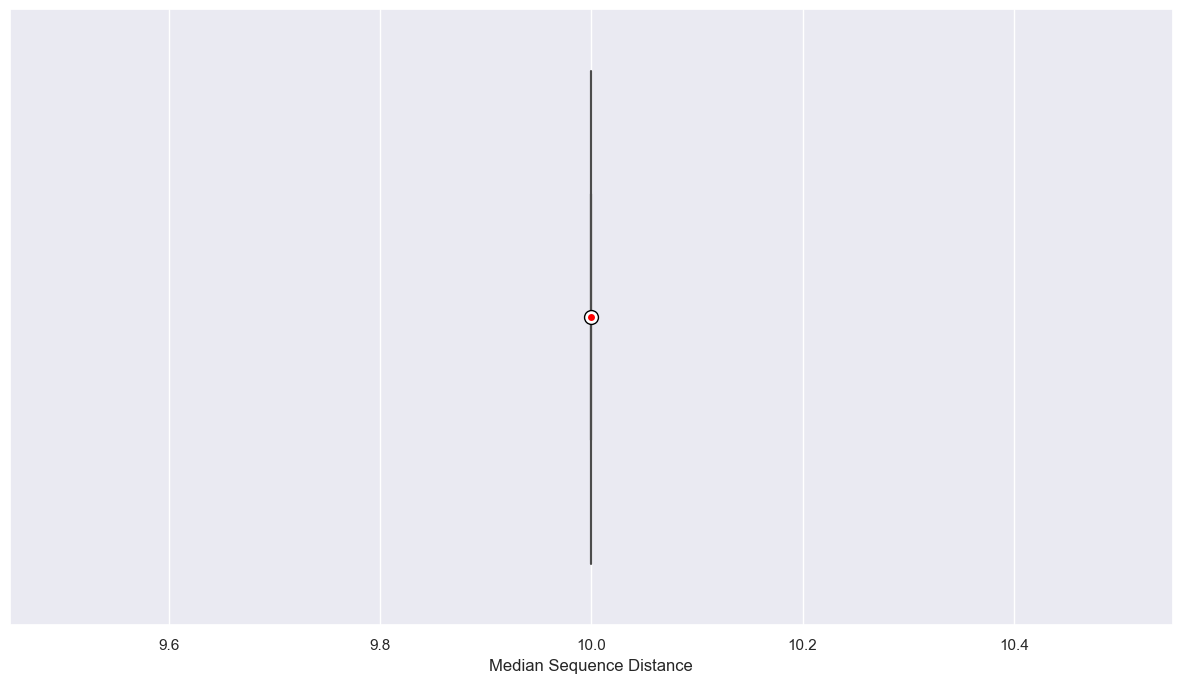

/Users/stefanschmerda/stefan/code/repos/know_center/ddia_dataset_analysis/dataset_analysis/notebooks/../utilities/functions.py:1221: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=data,


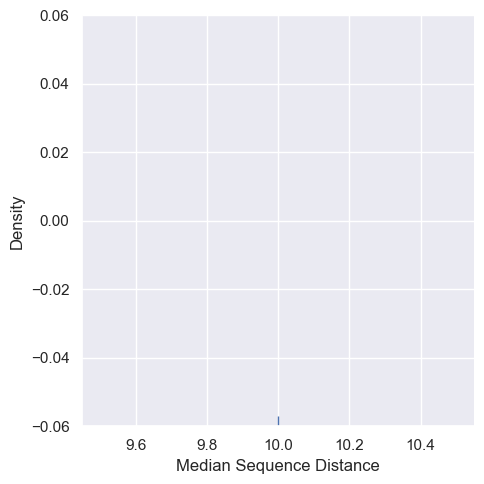

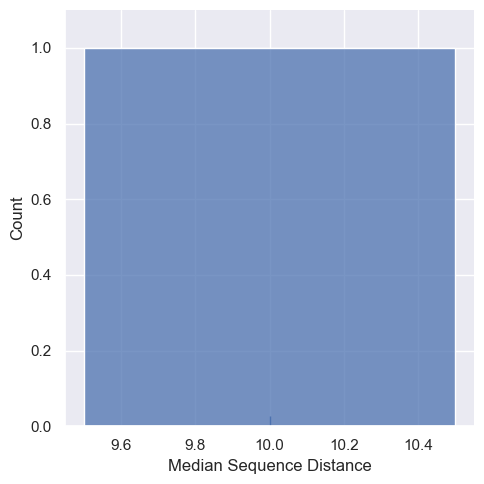

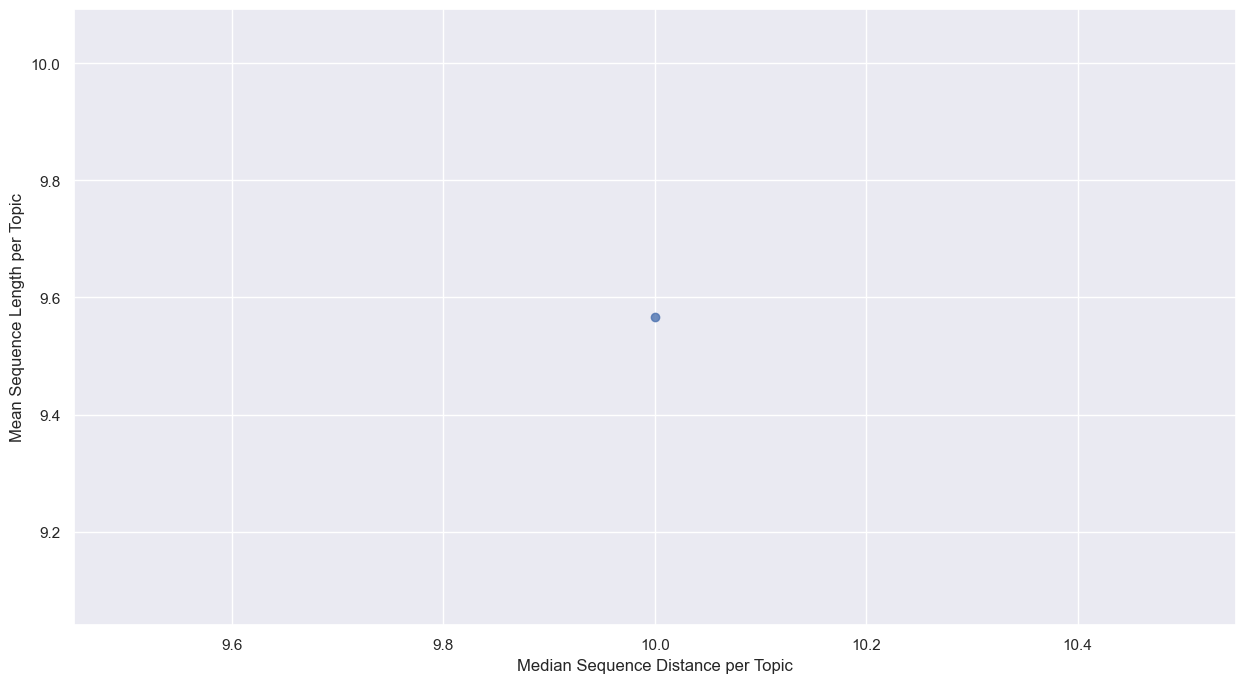

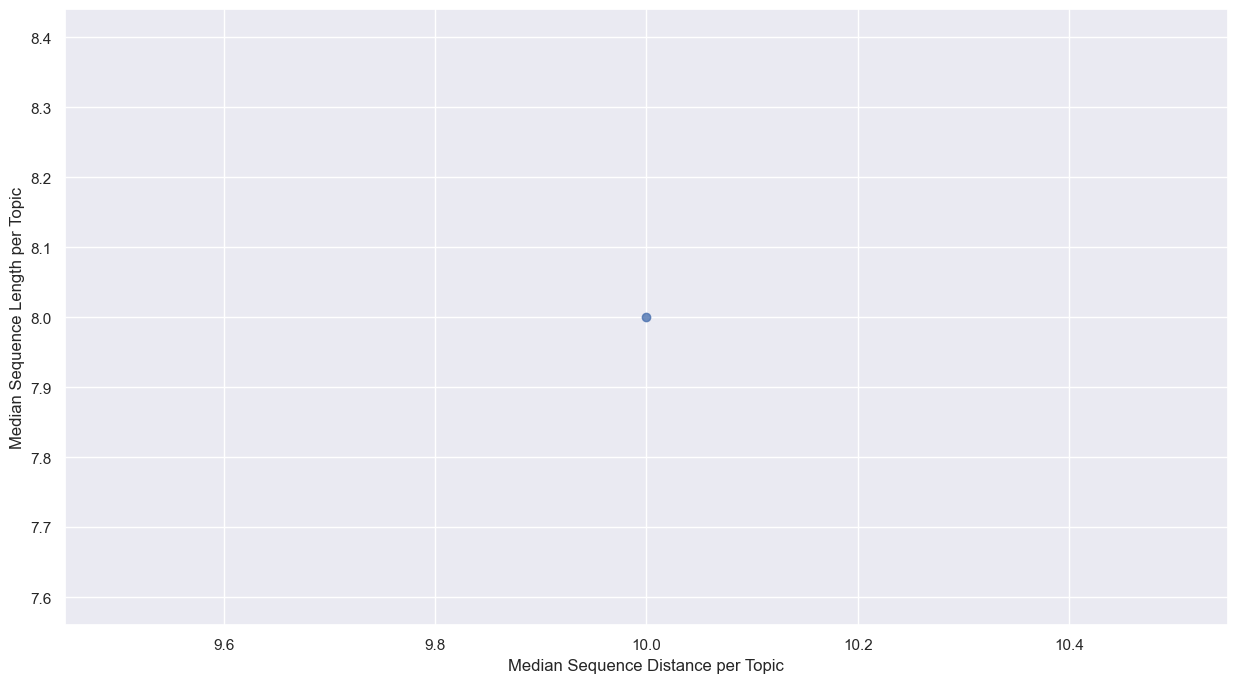

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Mean Normalized Sequence Distance per Topic:
----------------------------------------------------------------------------------------------------


Plots:


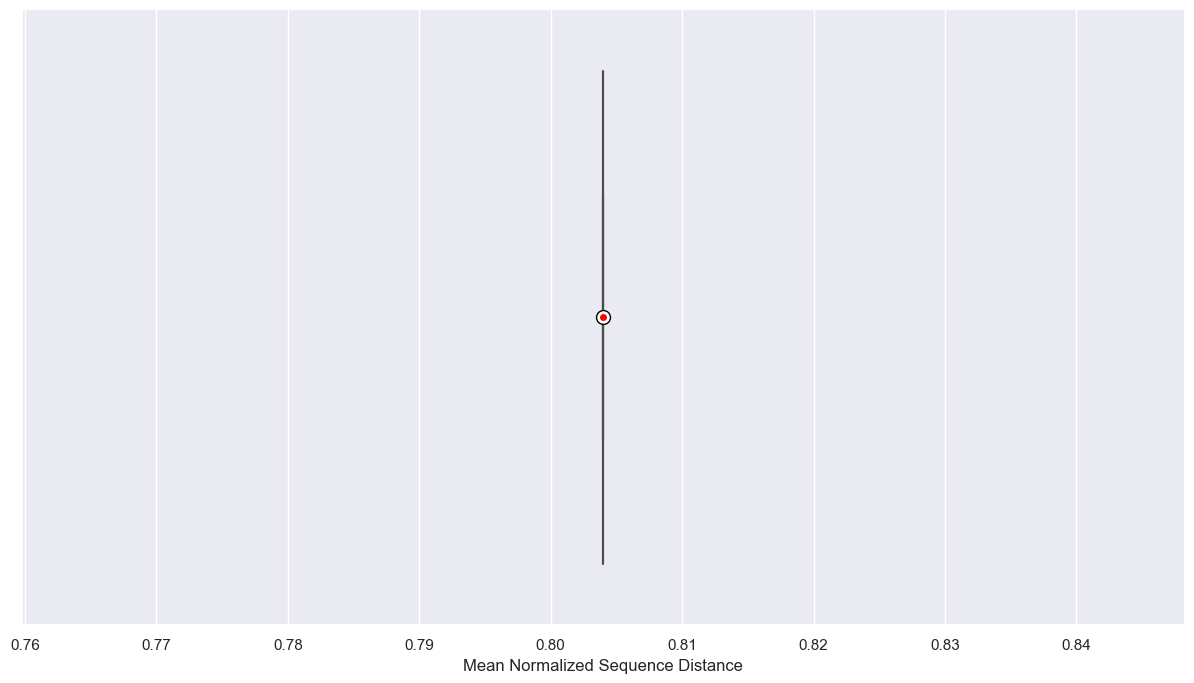

/Users/stefanschmerda/stefan/code/repos/know_center/ddia_dataset_analysis/dataset_analysis/notebooks/../utilities/functions.py:1221: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=data,


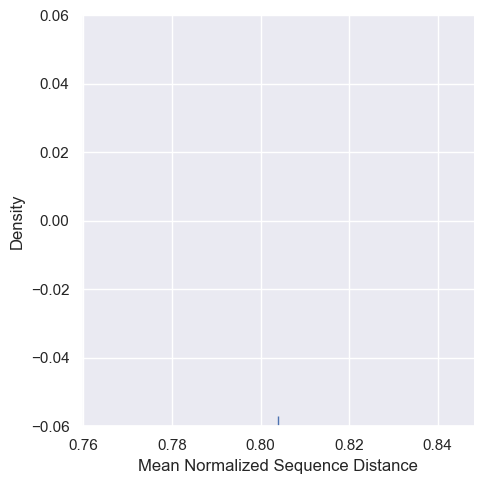

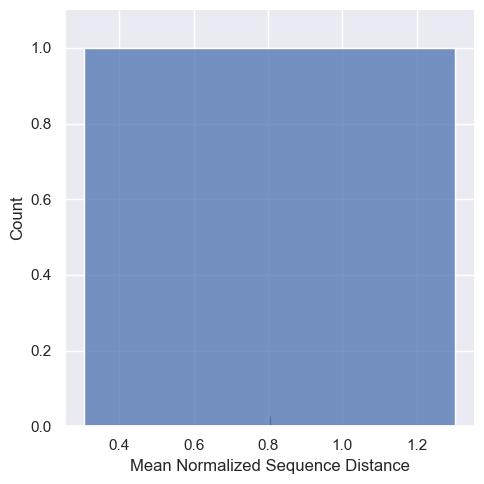

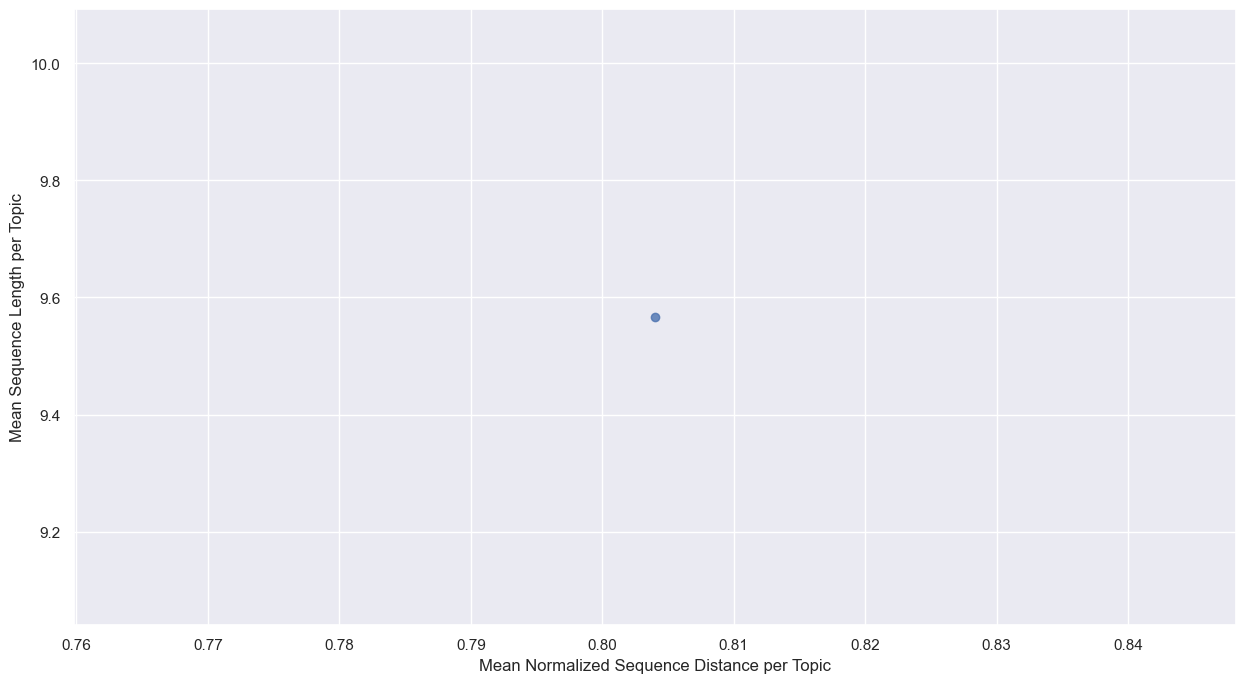

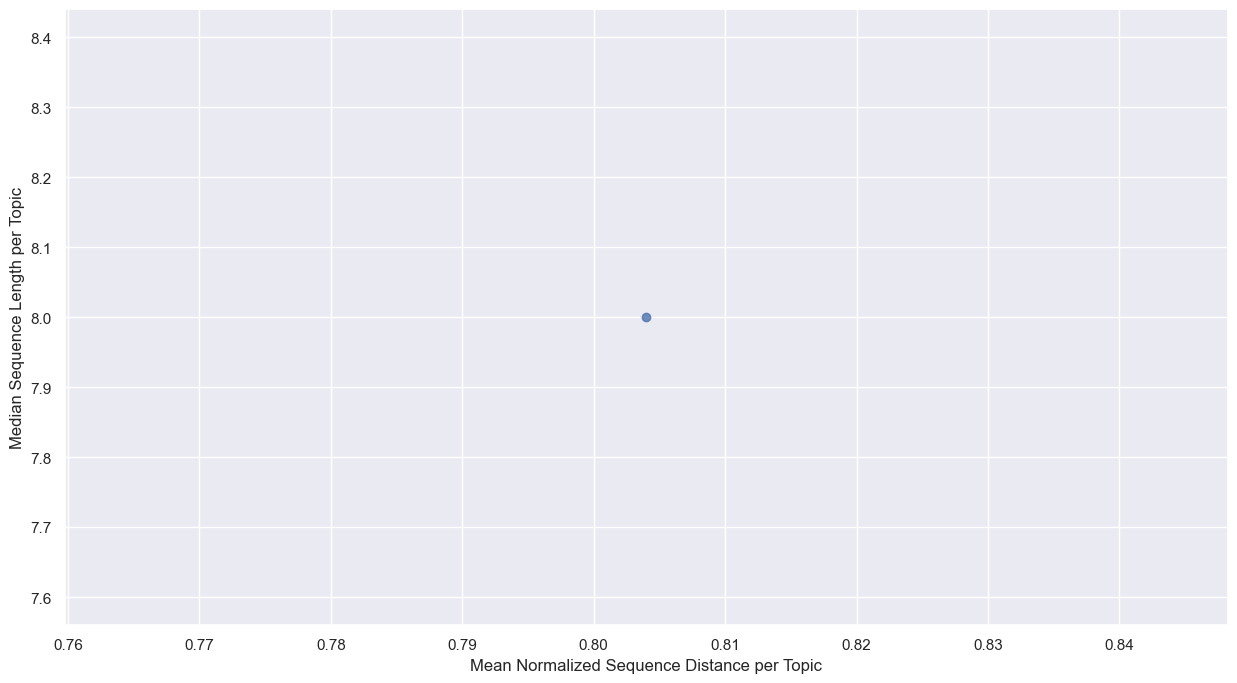

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Median Normalized Sequence Distance per Topic:
----------------------------------------------------------------------------------------------------


Plots:


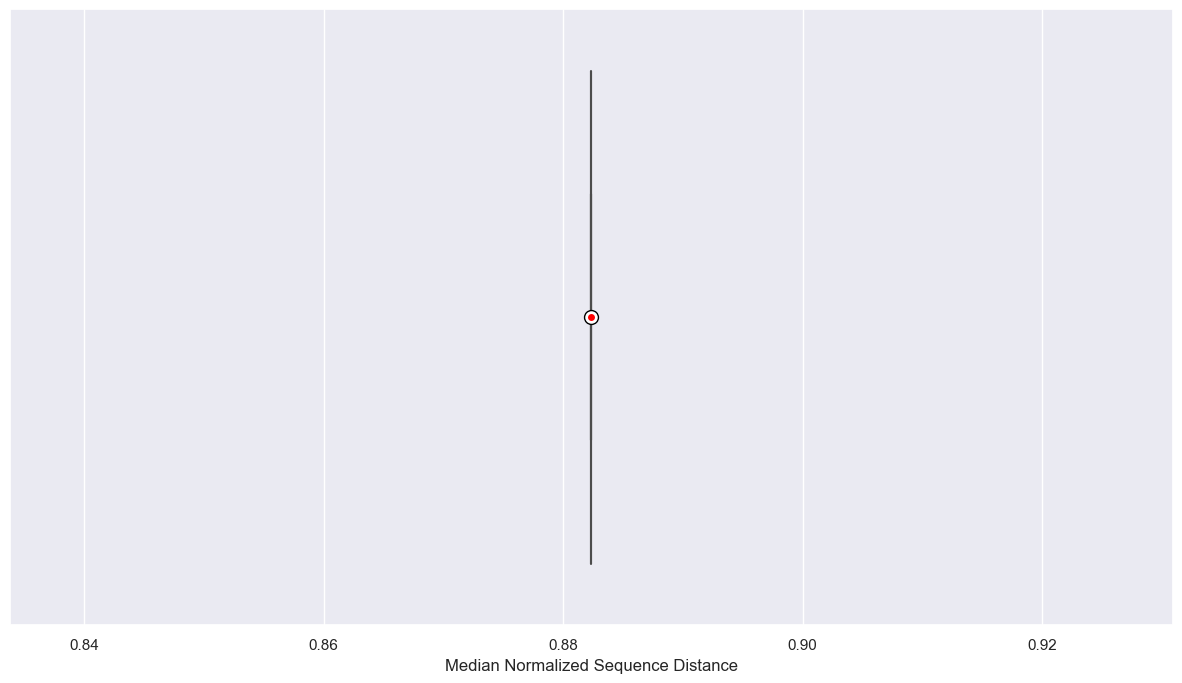

/Users/stefanschmerda/stefan/code/repos/know_center/ddia_dataset_analysis/dataset_analysis/notebooks/../utilities/functions.py:1221: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=data,


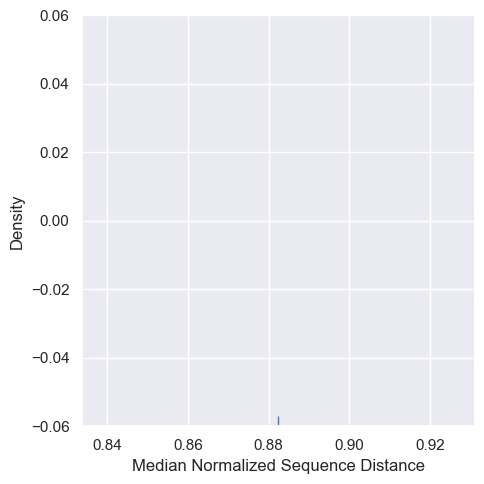

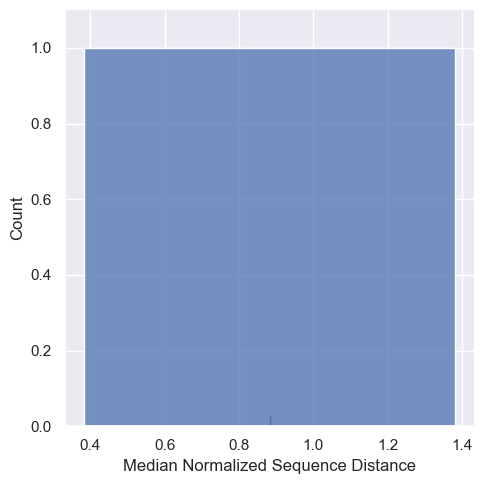

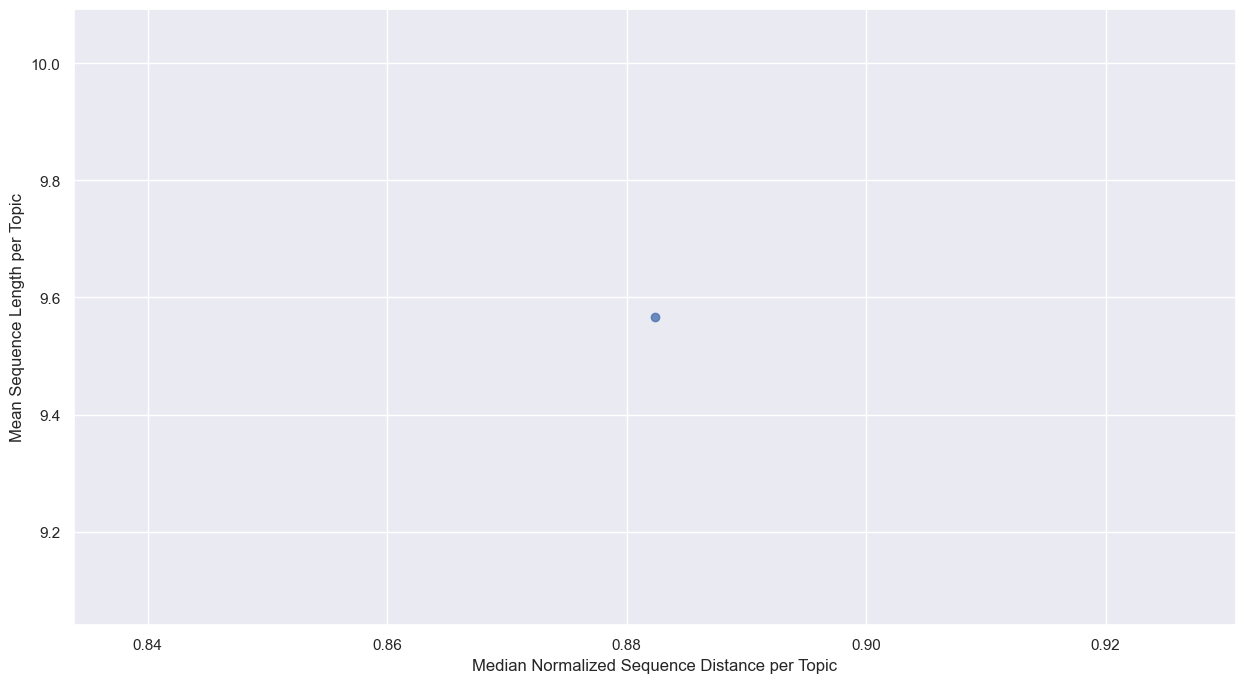

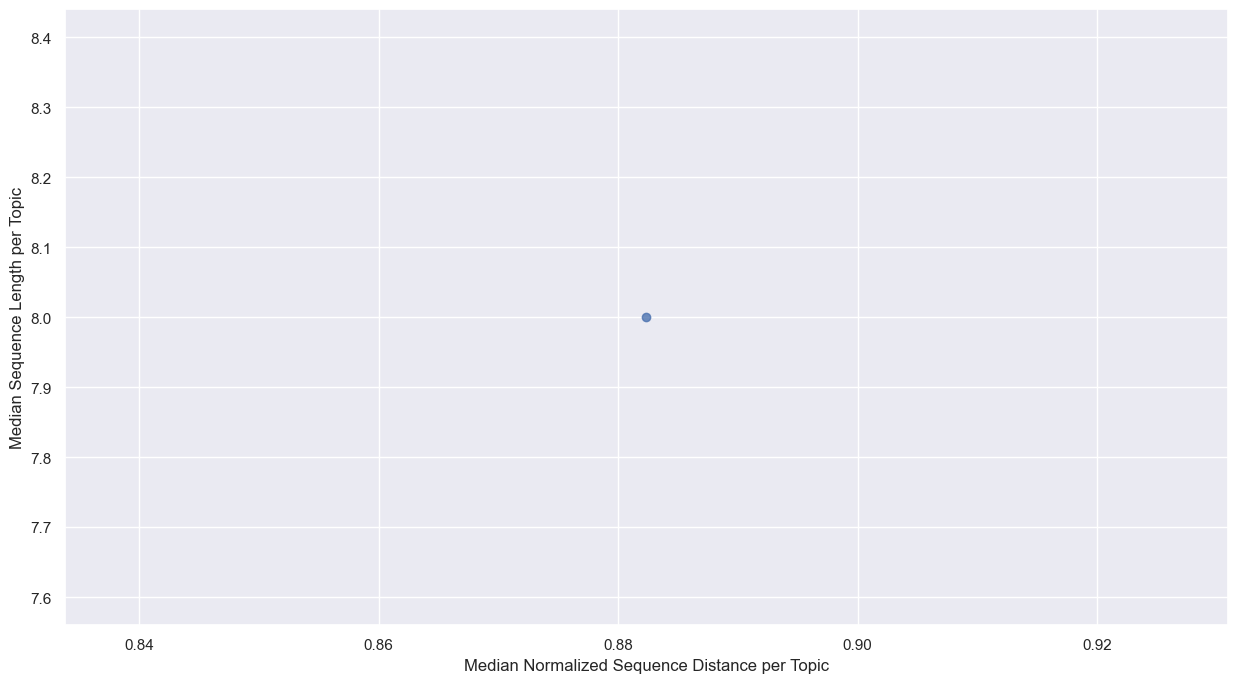

****************************************************************************************************
****************************************************************************************************
 


In [32]:
plot_sequence_distances(seq_distances)

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Sequence Distance Matrix per Topic:
----------------------------------------------------------------------------------------------------


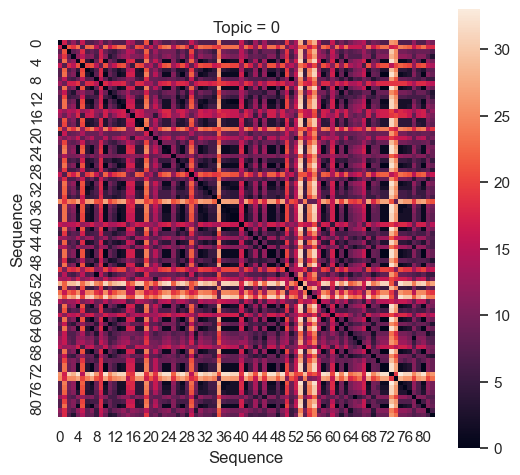

In [33]:
plot_sequence_distance_matrix_all_group(seq_distances,
                                        False,
                                        5)

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Normalized Sequence Distance Matrix per Topic:
----------------------------------------------------------------------------------------------------


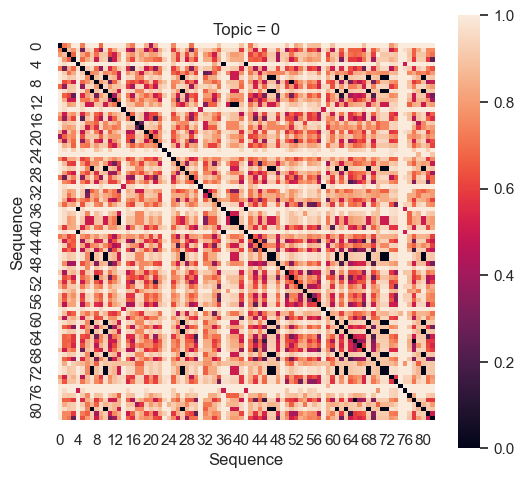

In [34]:
plot_sequence_distance_matrix_all_group(seq_distances,
                                        True,
                                        5)

## Clustering of Sequence Distances and Testing for Evaluation Metric Central Tendency Differences between Clusters 

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Cluster Analysis - Topic Selection Criteria
----------------------------------------------------------------------------------------------------
 
Unique vs Total Number of Sequences per Topic:


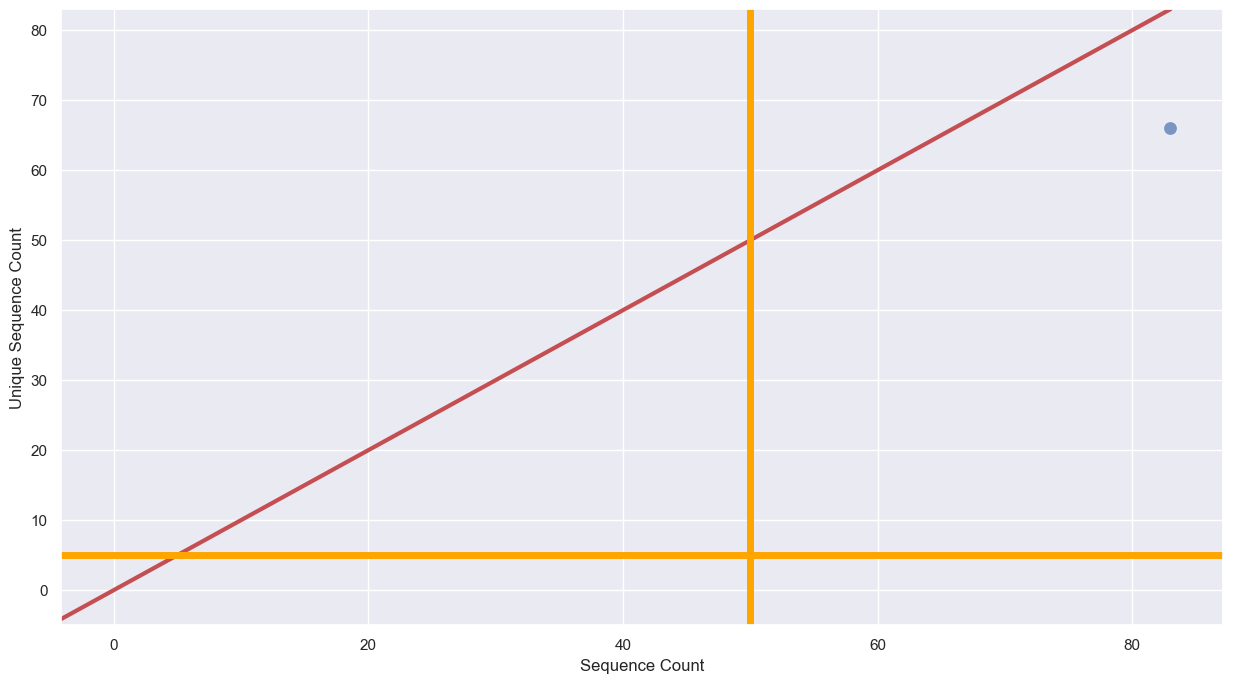

Normalized Sequence Distance per Topic:
Base: All User-Sequence Combinations


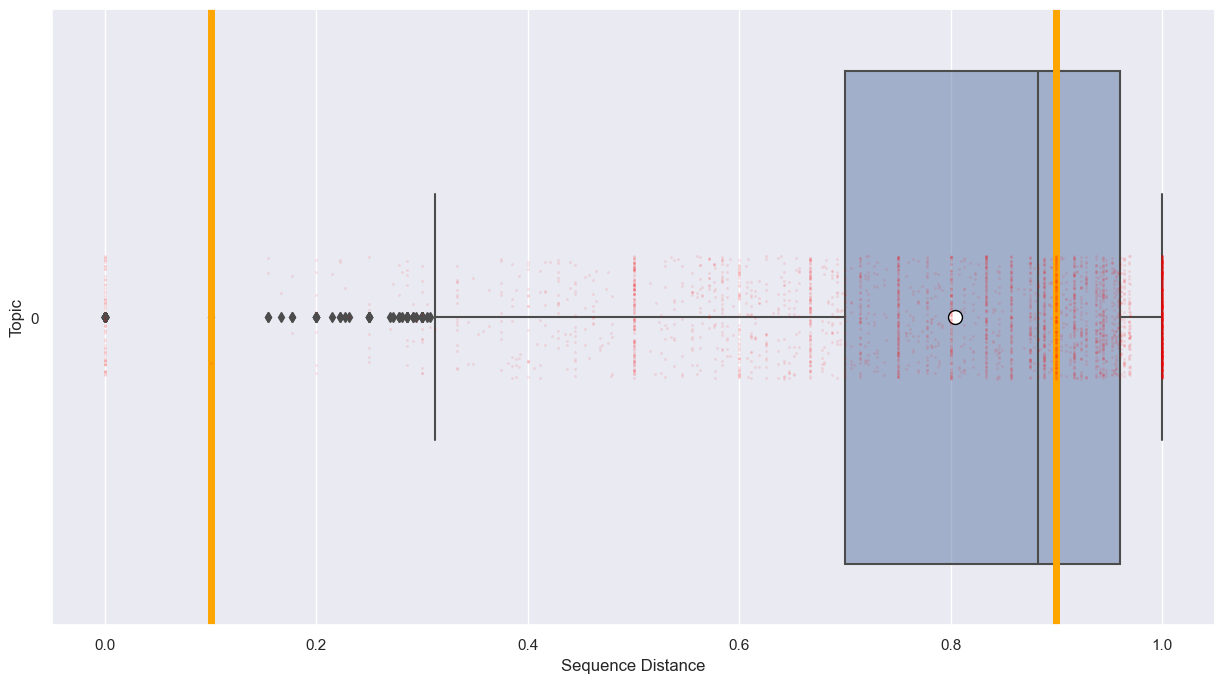

 
****************************************************************************************************
****************************************************************************************************


In [35]:
ClusterAnalysisPlotGroupSelectionCriteria(DATASET_NAME,
                                          learning_activity_sequence_stats_per_group,
                                          seq_distances,
                                          True,
                                          50,
                                          5,
                                          (0.1, 0.9)).display_group_selection_criteria()

In [36]:
cluster_eval = ClusterEvaluation(DATASET_NAME, 
                                 interactions, 
                                 USER_FIELD_NAME_STR, 
                                 GROUP_FIELD_NAME_STR, 
                                 EVALUATION_COURSE_IS_CORRECT_WITHOUT_HINTS_ALL_LEARNING_ACTIVITIES_MEAN_FIELD_NAME_STR,
                                 seq_distances,
                                 True,
                                 50,
                                 5,
                                 (0.1, 0.9),
                                 hdbscan.HDBSCAN,
                                 0.035,
                                 0.05,
                                 0.05,
                                 metric='precomputed',
                                 cluster_selection_method='eom')

In [37]:
cluster_eval.cluster_sequences_and_test_eval_metric_diff()
cluster_eval.aggregate_sequence_clustering_and_eval_metric_diff_test_over_groups()

100%|██████████| 1/1 [00:00<00:00, 94.81it/s]


In [38]:
pickle_write(cluster_eval,
             PATH_TO_SEQUENCE_CLUSTER_EVALUATION_METRIC_ANALYSIS_PICKLE_FOLDER,
             DATASET_NAME + SEQUENCE_CLUSTER_EVALUATION_METRIC_ANALYSIS_PER_GROUP_OBJECT_PICKLE_NAME)

In [39]:
cluster_stats_per_group = cluster_eval.cluster_stats_per_group
cluster_eval_metric_central_tendency_differences_per_group = cluster_eval.cluster_eval_metric_central_tendency_differences_per_group
aggregate_sequence_clustering_and_eval_metric_diff_test = cluster_eval.aggregate_sequence_clustering_and_eval_metric_diff_test
group_cluster_analysis_inclusion_status = cluster_eval.group_cluster_analysis_inclusion_status
min_cluster_size_correction_df = cluster_eval.min_cluster_size_correction_df

In [40]:
cluster_stats_per_group.head(1)

,Dataset Name,Topic,Number of Sequences,Number of Unique Sequences,Percentage Clustered,Cluster,Number of Sequences per Cluster,Number of Unique Sequences per Cluster,User,Sequence ID,Sequence Length,Sequence Array,Mean Evaluation Metric,Median Evaluation Metrice,Min Evaluation Metric Value,Max Evaluation Metric Value,STD Evaluation Metric Value,IQR Evaluation Metric Value
0,csedm_2019,0,83,66,79.518072,-1,17,16,"[0, 22, 29, 30, 31, 32, 33, 4, 41, 57, 61, 66,...","[0, 13, 19, 21, 22, 23, 24, 29, 31, 41, 45, 29...","[7, 2, 10, 10, 1, 1, 12, 1, 6, 1, 5, 1, 9, 33,...","[(0, 1, 2, 3, 4, 5, 6), (18, 29), (7, 8, 1, 14...",0.428414,0.5,0.0,1.0,0.392523,0.606061


In [41]:
cluster_eval_metric_central_tendency_differences_per_group.head(1)

,Dataset Name,Topic,Number of Sequences,Number of Unique Sequences,Mean Normalized Sequence Distance,Median Normalized Sequence Distance,Min Normalized Sequence Distance,Max Normalized Sequence Distance,STD Normalized Sequence Distance,IQR Normalized Sequence Distance,Clustering Algorithm,HDBSCAN Min Cluster Size,Number of Clusters,Percentage Clustered,Mean Cluster Size,Median Cluster Size,Min Cluster Size,Max Cluster Size,STD Cluster Size,IQR Cluster Size,Cluster Comparision Evaluation Metric,Normality Test Shapiro P-Value,Normality Test Jarque-Bera P-Value,Normality Test D'Agostion-Pearson P-Value,Homoscedasticity Test Levene P-Value,Homoscedasticity Test Bartlett P-Value,Central Tendency Differences Test Type,Central Tendency Differences Test P-Value
0,csedm_2019,0,83,66,0.804003,0.882353,0.0,1.0,0.212232,0.26,HDBSCAN,3,5,79.518072,13.2,5.0,3,43,15.157836,7.0,Course Is Correct Without Hints All Learning R...,0.009522,0.865389,0.751243,0.002473,0.000004,kruskal_wallis_test,0.006053


In [42]:
aggregate_sequence_clustering_and_eval_metric_diff_test.head(1)

,Unfiltered Number of Topics,Number of Topics,Percentage of Unfiltered Topics,Number of Topics with Multiple Clusters,Mean Number of Sequences per Topic,Median Number of Sequences per Topic,Min Number of Sequences per Topic,Max Number of Sequences per Topic,STD Number of Sequences per Topic,IQR Number of Sequences per Topic,Mean Number of Unique Sequences per Topic,Median Number of Unique Sequences per Topic,Min Number of Unique Sequences per Topic,Max Number of Unique Sequences per Topic,STD Number of Unique Sequences per Topic,IQR Number of Unique Sequences per Topic,Mean Number of Clusters per Topic,Median Number of Clusters per Topic,Min Number of Clusters per Topic,Max Number of Clusters per Topic,STD Number of Clusters per Topic,IQR Number of Clusters per Topic,Mean Number of Sequences per Topic with Multiple Clusters,Median Number of Sequences per Topic with Multiple Clusters,Min Number of Sequences per Topic with Multiple Clusters,Max Number of Sequences per Topic with Multiple Clusters,STD Number of Sequences per Topic with Multiple Clusters,IQR Number of Sequences per Topic with Multiple Clusters,Mean Number of Unique Sequences per Topic with Multiple Clusters,Median Number of Unique Sequences per Topic with Multiple Clusters,Min Number of Unique Sequences per Topic with Multiple Clusters,Max Number of Unique Sequences per Topic with Multiple Clusters,STD Number of Unique Sequences per Topic with Multiple Clusters,IQR Number of Unique Sequences per Topic with Multiple Clusters,Mean Number of Clusters per Topic with Multiple Clusters,Median Number of Clusters per Topic with Multiple Clusters,Min Number of Clusters per Topic with Multiple Clusters,Max Number of Clusters per Topic with Multiple Clusters,STD Number of Clusters per Topic with Multiple Clusters,IQR Number of Clusters per Topic with Multiple Clusters,Number of Topics Significant Differeces Eval Metric Central Tendencies between Clusters,Percentage of Topics Significant Differeces Eval Metric Central Tendencies between Clusters,Percentage of Topics with Multiple Clusters Significant Differeces Eval Metric Central Tendencies between Clusters
Dataset Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
csedm_2019,1,1,1.0,1,83.0,83.0,83,83,NaN,0.0,66.0,66.0,66,66,NaN,0.0,5.0,5.0,5,5,NaN,0.0,83.0,83.0,83,83,NaN,0.0,66.0,66.0,66,66,NaN,0.0,5.0,5.0,5,5,NaN,0.0,1,100.0,100.0


In [43]:
group_cluster_analysis_inclusion_status.head(1)

,Dataset Name,Topic,Topic Included in Cluster Analysis,Minium Sequence Number Threshold Value,Minium Sequence Number Violated,Minium Unique Sequence Number Threshold Value,Minium Unique Sequence Number Violated,Sequence Distance Range Threshold Value,Sequence Distance Range Violated
0,csedm_2019,0,True,50,False,5,False,"(0.1, 0.9)",False


In [44]:
min_cluster_size_correction_df.head(1)

,Dataset Name,Topic,Minimum Cluster Size Is Corrected,Uncorrected Minimum Cluster Size,Corrected Minimum Cluster Size
0,csedm_2019,0,False,3,3


****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Cluster Analysis - Included Topics
----------------------------------------------------------------------------------------------------
 
1 Topics out of 1 are included in Cluster Analysis:


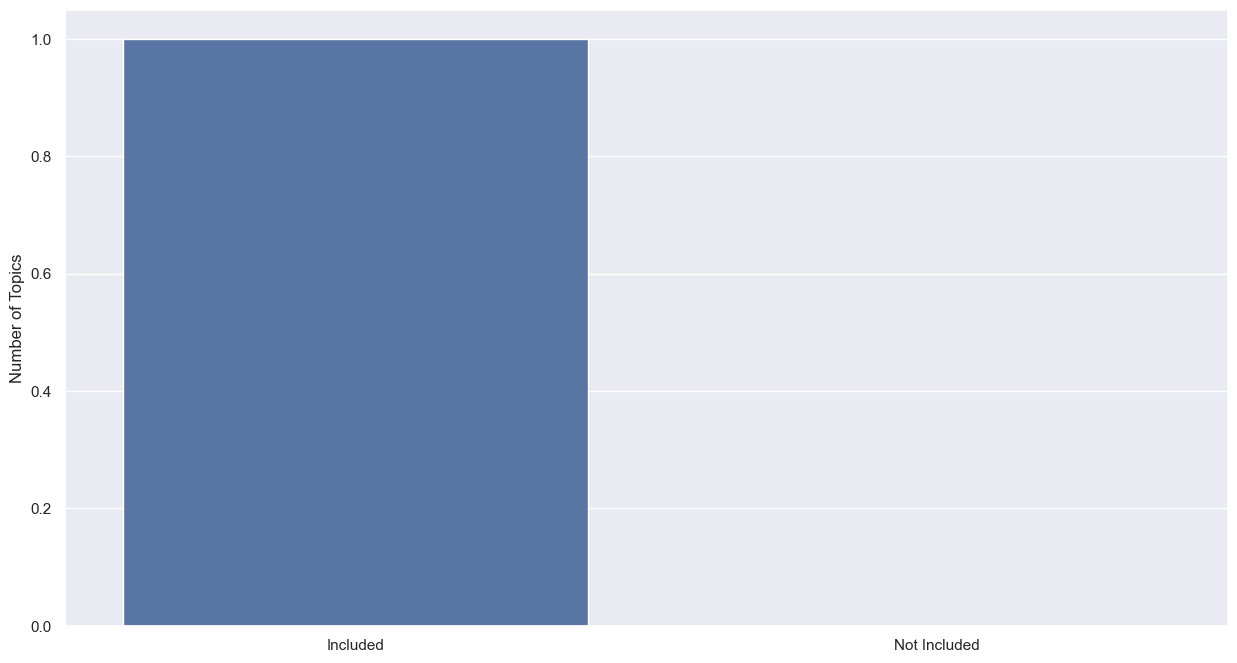

100.0% of Topics are included in Cluster Analysis:


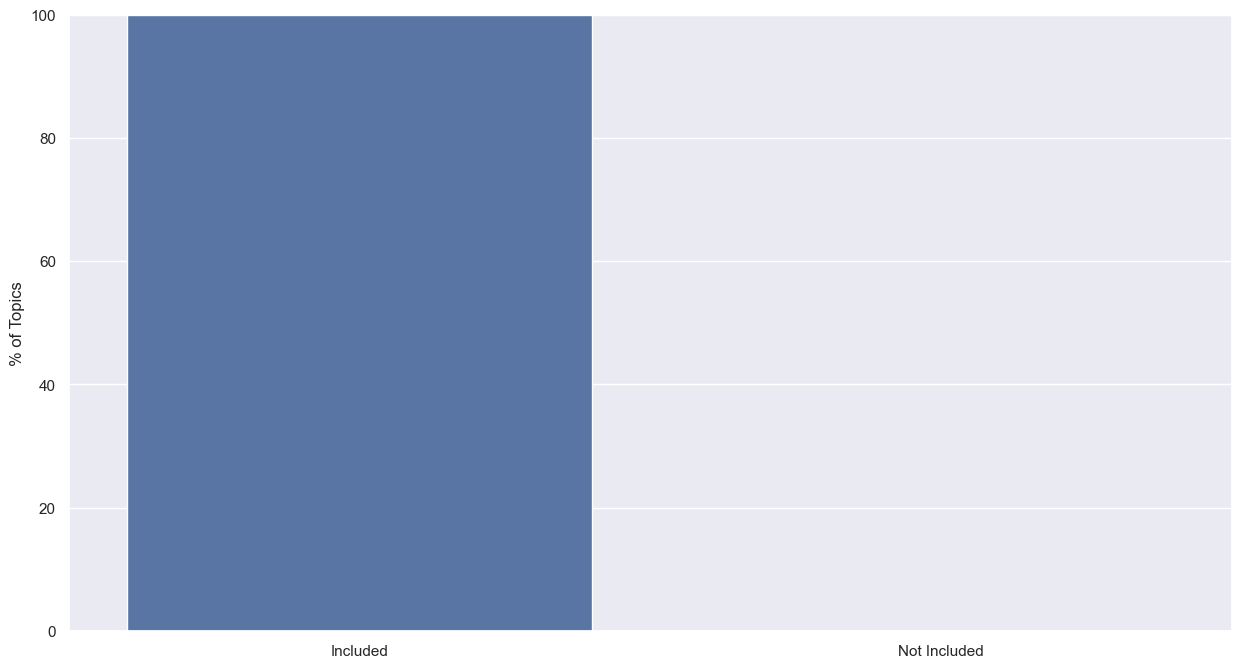

In [45]:
cluster_eval.display_included_groups()

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Clusters per Topic:
----------------------------------------------------------------------------------------------------


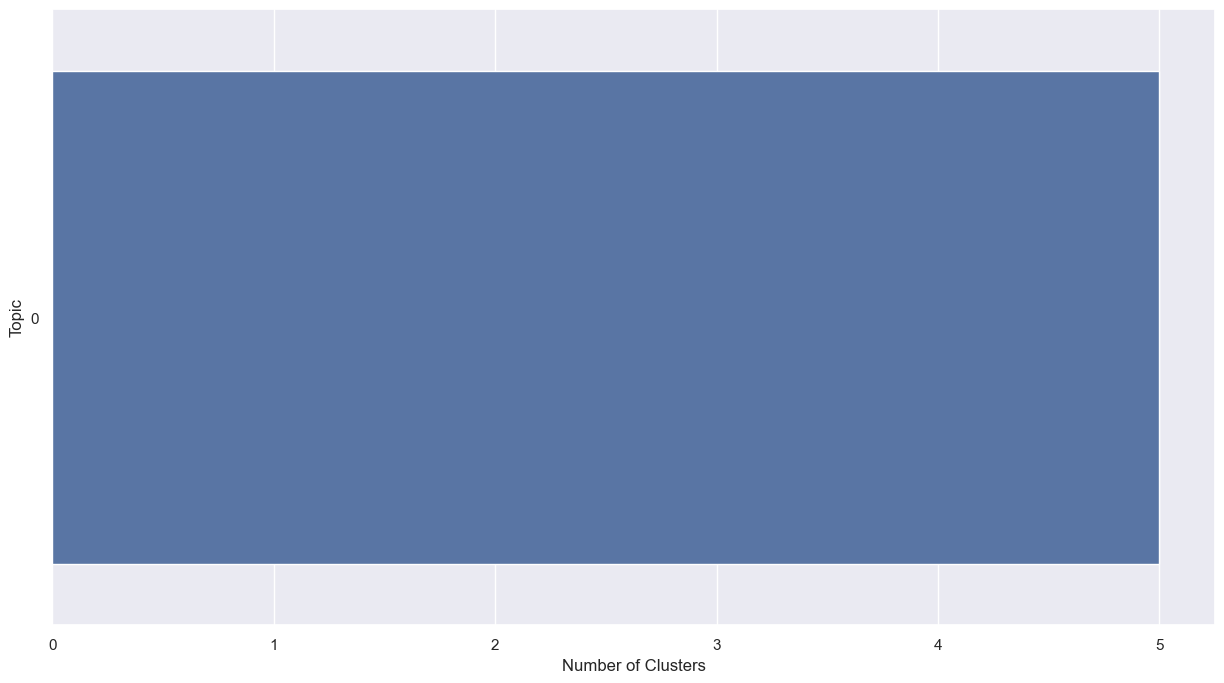

In [46]:
cluster_eval.display_number_of_clusters_all_group()

In [47]:
cluster_eval.print_number_of_clusters_all_group()

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Clusters for each Topic:
----------------------------------------------------------------------------------------------------
Topic  Number of Clusters
    0                   5


****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Min Cluster Size per Topic:
----------------------------------------------------------------------------------------------------


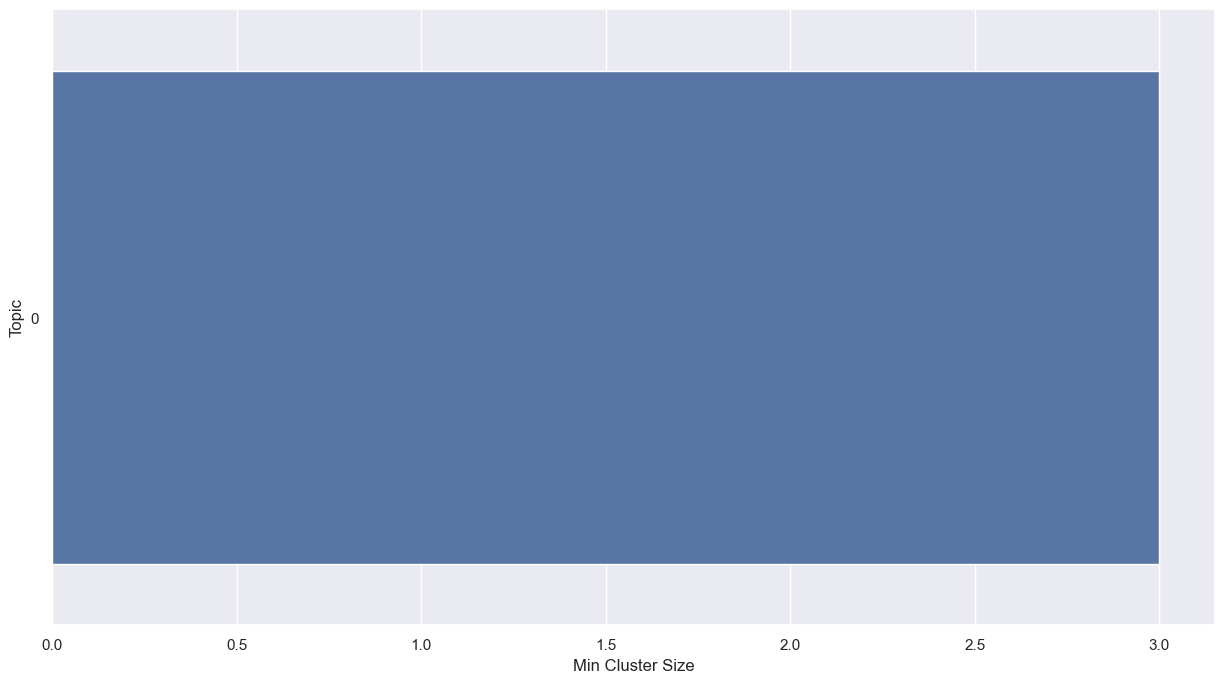

In [48]:
cluster_eval.display_min_cluster_size_all_group()

In [49]:
cluster_eval.print_min_cluster_sizes_all_group()

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Min Cluster Size per Topic:
----------------------------------------------------------------------------------------------------
Topic  Min Cluster Size
    0                 3


****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Percentage Clustered per Topic:
----------------------------------------------------------------------------------------------------


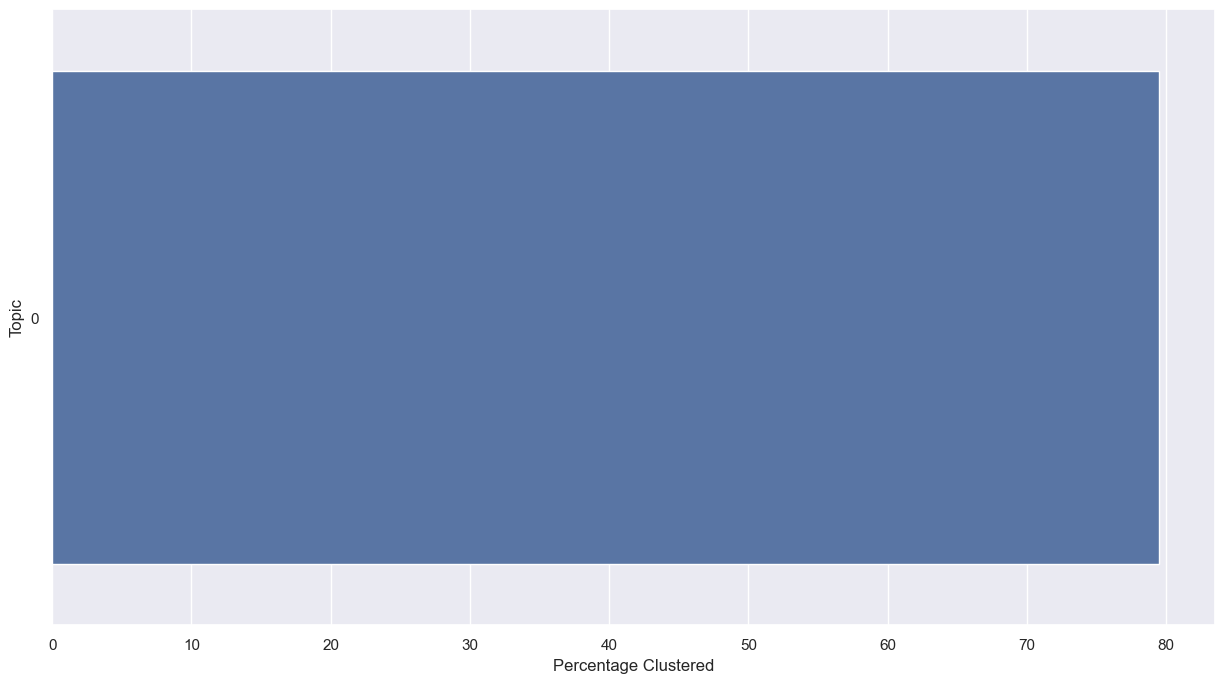

In [50]:
cluster_eval.display_percentage_clustered_all_group()

In [51]:
cluster_eval.print_percentage_clustered_all_group()

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Percentage Clustered per Topic:
----------------------------------------------------------------------------------------------------
Topic  Percentage Clustered
    0             79.518072


****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Sequences per Cluster for each Topic:
----------------------------------------------------------------------------------------------------
Plots:


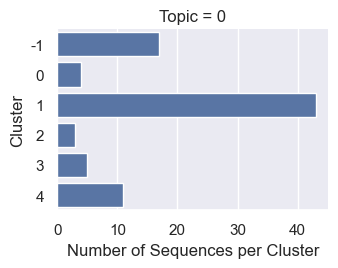

In [52]:
cluster_eval.display_number_sequences_per_cluster_all_group(height=3)

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Unique Sequences per Cluster for each Topic:
----------------------------------------------------------------------------------------------------
Plots:


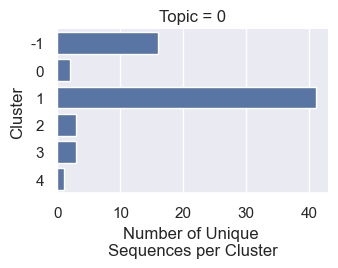

In [53]:
cluster_eval.display_number_unique_sequences_per_cluster_all_group(height=3)

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Number of Unique Sequences vs Number of Sequences per Cluster for each Topic:
----------------------------------------------------------------------------------------------------
Plots:


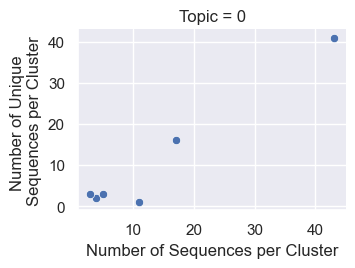

In [54]:
cluster_eval.display_number_unique_sequences_vs_number_sequences_per_cluster_all_group(height=3)

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Central Tendency Differences in Evaluation Metric between Clusters per Topic:
Chosen Evaluation Metric: "Course Is Correct Without Hints All Learning Resources Mean"
----------------------------------------------------------------------------------------------------


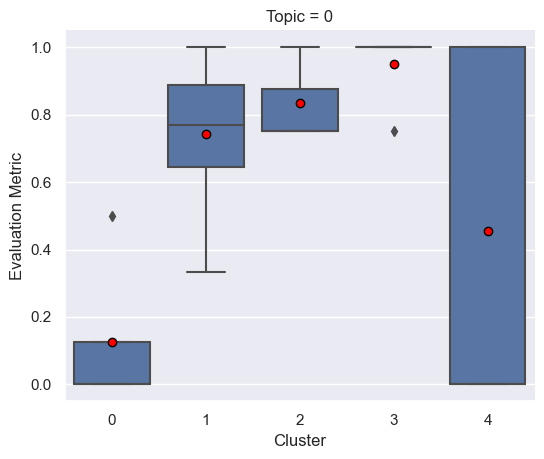

In [55]:
cluster_eval.display_eval_metric_dist_between_cluster_all_groups(height=5)

****************************************************************************************************
****************************************************************************************************
 
----------------------------------------------------------------------------------------------------
Clusters per Topic
Dimensionality Reducer: UMAP
----------------------------------------------------------------------------------------------------


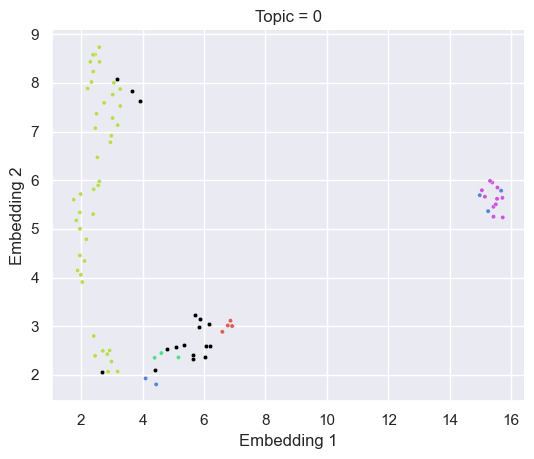

In [56]:
cluster_eval.display_clusters_all_group_umap(height=5)